In [1]:
import numpy as np
import pandas as pd
import os
import rasterio
from GeoDS import hypercube
from GeoDS.prospectivity import hyperparameterstuning
from GeoDS import utilities
from GeoDS.supervised import mapclass
from GeoDS.prospectivity import reporting 
from GeoDS.prospectivity import featureimportance as fe
from GeoDS import eda
from GeoDS import datawrangle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from joblib import dump, load
import glob
from dask import dataframe as dd

import optuna
from optuna import pruners
from imblearn.pipeline import Pipeline

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

#import tensorflow as tf
#import tensorflow_data_validation as tfdv
#from tensorflow_metadata.proto.v0 import schema_pb2

#print('TFDV Version: {}'.format(tfdv.__version__))
#print('Tensorflow Version: {}'.format(tf.__version__))

plt.rcParamsDefault["figure.figsize"] = [20., 20.]
plt.rcParams["figure.facecolor"] = 'white'
plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams["savefig.facecolor"] = 'white'

from new_util import *


In [2]:
def replace_classes(actual_classes, correspondance_dict):
    original_classes = [correspondance_dict[code] for code in actual_classes]
    return original_classes

In [3]:
crs = 'epsg:26918'
AOI = 'Inputs/AOI/shape/AOI_geol.shp'
pixel_size = 5
xRes = pixel_size
yRes = pixel_size

# Random seed
random_state = 42

In [4]:
trial_name = 'Baseline_Model_July28_Li'

reporting_folder = os.path.join(trial_name, 'reporting/')
output_folder = os.path.join(trial_name, 'outputs/')
predictions_folder = os.path.join(trial_name, 'predictions/')
CatBoost_predictions_folder = os.path.join(predictions_folder, 'CatBoost_predictions/')
RF_predictions_folder = os.path.join(predictions_folder, 'RF_predictions/')
LGBM_predictions_folder = os.path.join(predictions_folder, 'LGBM_predictions/')
SVM_predictions_folder = os.path.join(predictions_folder, 'SVM_predictions/')

if not os.path.exists(reporting_folder):
    os.makedirs(reporting_folder)
        
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

if not os.path.exists(predictions_folder):
    os.makedirs(predictions_folder) 

if not os.path.exists(CatBoost_predictions_folder):
    os.makedirs(CatBoost_predictions_folder)

if not os.path.exists(RF_predictions_folder):
    os.makedirs(RF_predictions_folder)
    
if not os.path.exists(LGBM_predictions_folder):
    os.makedirs(LGBM_predictions_folder)

if not os.path.exists(SVM_predictions_folder):
    os.makedirs(SVM_predictions_folder) 

In [5]:
import glob
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import warnings
from pathlib import Path
import rioxarray
from osgeo import gdal, gdalconst
from GeoDS import utilities
import subprocess
import xarray
import json


def _reproject_tif_folder(input_folder, output_folder, crs, xRes, yRes):
    #tifs = glob.glob(os.path.join(input_folder, '*.tif'))
    tifs = input_folder

    if not len(tifs) > 0:
        raise ValueError(
            "The input folder you provided do not contain any geotiffs. Please check your spelling.")

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for t in tifs:
        filename, ext, directory = utilities.Path_Info(t)
        newname = filename + '.tif'
        newpath = os.path.join(output_folder, newname)

        utilities.warp(input_geotiff=t, output_geotiff=newpath,
                       dstSRS=crs, xRes=xRes, yRes=yRes)


def _get_geotiff_information(input_tif):
    src = rasterio.open(input_tif)
    if(src.crs == None):
        # In case no CRS exists
        crs = 'INVALID CRS. CRS = None. PLEASE CHECK.'
    else:
        try:
            # We need a try statement in case the CRS is a weird output by oasis montaj. Could not repeat the exact issue I had with the output from Michael Cain but I think this will handle future issues.
            crs = src.crs['init']
        except:
            crs = 'INVALID CRS. CANNOT ACCES [\'init\'] property. PLEASE CHECK.'
            pass

    shape = src.shape
    nb_bands = src.count
    types = src.dtypes
    nodata_values_by_bands = src.nodatavals
    nodata_value = src.nodata
    # not using the src.transform
    try:
        gt = src.transform
        pixelSizeX = gt[0]
        pixelSizeY = -gt[4]
        resolution = (pixelSizeX, pixelSizeY)
    except:
        resolution = ('error cannot access transform attribute',
                      'error cannot access transform attribute')
        pass

    from shapely.geometry import box
    bounds = src.bounds
    geom = box(*bounds)
    src.close()

    return crs, shape, nb_bands, types, nodata_values_by_bands, nodata_value, resolution, geom


def sanity_check(input_directories, working_aoi, working_crs, output_directory='Sanity_Report/'):
    """
    Performs a validation on each on the input layers. Will output a csv to assess shape, crs, nb_bands, resolution, bounding box in working AOI, nodata value
    I suggest you do this and before each project, make sure that all the layers have the right and same CRS, the same no-data value, are single-bands, non corrupt and contained in the working AOI.
    Parameters
    ----------
    input_directory : list
        list where each element is a string of the path to the directory which contains all the input geotiff
    working_aoi : str
        path to a shapefile containing a sole polygon of the aoi. That polygon should have only one field called 'value' and set to 1
    working_crs : str
        the destination CRS, such as "epsg:26921" per example. Not implemented yet, will help to have a column that tells if CRS is good or not.
    Returns
    -------
        None
    Examples
    --------
        Perform a sanity check. Will ouput a report (excel format) in Sanity_Report/ folder .
        >>> datawrangle.sanity_check(input_directories='path_to_input/layers/folder/', working_aoi='path/to/aoi.shp', working_crs='epsg:31981')
    """
    files_names = []
    for dir in input_directories:
        names = glob.glob(os.path.join(dir, "*.tif"))
        files_names.extend(names)

    if (len(files_names) == 0):
        # This means that the input_directory is empty or no data is contained.
        print("Input folder is either empty or you gave the wrong path. Please double check and come back.")
        return None

    df = pd.DataFrame(files_names, columns=['file_name'])
    df['crs'], df['shape'], df['nb_bands'], df['types'], df['nodata_values_by_bands'], df['nodata_value'], df[
        'resolution_x_y'], df['bounding_box'] = zip(
        *df.apply(lambda x: _get_geotiff_information(x['file_name']), axis=1))

    aoi_gdf = gpd.read_file(working_aoi)
    aoi_poly = aoi_gdf['geometry'].loc[0]
    df['is_in_aoi'] = df.apply(
        lambda x: x['bounding_box'].intersects(aoi_poly), axis=1)

    if not os.path.exists(output_directory):
        os.mkdir(output_directory)

    # Save bouding boxes
    d = {'file_name': df['file_name'], 'geometry': df['bounding_box']}
    gdf = gpd.GeoDataFrame(d, crs=working_crs)
    gdf.to_file(os.path.join(output_directory, 'Layers_Bouding_boxes.shp'))

    now = utilities.actual_time_for_file_name()
    final_name = os.path.join(
        output_directory, 'Sanity_Report_' + now + '.xlsx')
    df.to_excel(final_name)
    print("Sanity check completed. Please see the report file %s " % final_name)


def make_abstract_grid_csv(aoi_tif, output_directory):
    """
    Outputs a .csv containing x,y coordinates of all the cells of the AOI rasters (an abstract grid).
    Parameters
    ----------
    aoi_tif : str
        path to the aoi geotiff
    output_directory : str
        path to where the abstract grid will be saved
    Returns
    -------
    grid : str
        path to the abstract grid csv
    """

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    grid = os.path.join(output_directory, 'abstract_grid.csv')
    if os.path.exists(grid):
        os.remove(grid)

    utilities.geotiff_to_csv(aoi_tif, grid)

    return grid


def build_stack_cdf(input_numerical_folder, input_categorical_folder, output_folder, aoi_shapefile, working_crs, x_res, y_res, output_format='csv', ensure_tif_reprojection=True):
    """
    DataWrangle main function. Creates a hypercube csv using NetCDF as internal mechanism for enhanced performances.
    Outputs a .csv of the HyperCube.
    Parameters
    ----------
    input_numerical_folder: str
        directory containing numerical layers
    input_categorical_folder: str
        directory containing categorical layers
    output_folder : str
        directory for the hypercube output
    aoi_shapefile: str
        path to a shapefile that has a polygon representing the area of interest
    working_crs: str
        working CRS, per example 'epsg:26921'
    x_res: int
        x_resolution
    y_res: int
        y_resolution
    output_format : str, default='csv'
        Output format for the cube. Available options are 'csv' or 'netCDF'
    ensure_tif_reprojection : bool, default = True
        Will automatically perform gdal.warp on each of the individual input files to fix unexpected behaviors when it comes to build a VRT. Performance will be decreased but we suggest to keep it this way.
    Returns
    -------
    None
    Examples
    -------
        Build a HyperCube (csv).
        >>> datawrangle.build_stack_cdf(input_numerical_folder='input_layers_numerical/', input_categorical_folder='input_layers_categorical/', output_folder='output/', aoi_shapefile='AOI/AOI_2021.shp', working_crs='epsg:31981', x_res=25, y_res=25)
    """
    warnings.warn(
        "This function is deprecated, Please use cube_vrt if this function throws NetCDF errors", ResourceWarning)
    print("Processing...")
    # QAQC the output format
    formats = ['csv', 'netcdf']
    output_format = output_format.lower()
    if output_format not in formats:
        raise ValueError(
            "Output format you specified is not supported. Supported types : 'csv', 'netcdf'. Processing aborted.")

    # QAQC THE AOI
    if(os.path.isfile(aoi_shapefile)):
        aoi = gpd.read_file(aoi_shapefile)
        if(len(aoi.geom_type) == 0):
            print("Your AOI shapefile is empty. Processing aborted.")
            return
        else:
            for t in aoi.geom_type:
                if t != 'Polygon':
                    print(
                        'There is a geometry that is not a polygon in your AOI. Go in QGIS and fix this. Processing aborted.')
                    return

            for v in aoi['geometry'].is_valid:
                if v == False:
                    print(
                        'There is an invalid geometry in your polygon (self-crossing itself, per example). Go in QGIS and fix this. Processing aborted.')
                    return
    else:
        raise ValueError(
            "The path of the AOI shapefile you provided is wrong. Please double check. Processing aborted.")

    # QAQC if to see if folder provided do exists and are not empty
    #numeric_files = glob.glob(os.path.join(input_numerical_folder, "*.tif"))
    numeric_files = input_numerical_folder
    if (len(numeric_files) == 0):
        raise ValueError(
            "The input NUMERICAL folder path you provided do not contain any geotiffs. Processing aborted.")

    #cat_files = glob.glob(os.path.join(input_categorical_folder, "*.tif"))
    cat_files = input_categorical_folder
    if (len(cat_files) == 0):
        raise ValueError(
            "The input CATEGORICAL folder path you provided do not contain any geotiffs. Processing aborted.")

    if(ensure_tif_reprojection == True):
        print("Reprojecting your numerical files")
        output_folder_numerical_warped = os.path.join(
            output_folder, 'datawrangle_reprojected_numerical/')
        _reproject_tif_folder(
            input_numerical_folder, output_folder_numerical_warped, working_crs, x_res, y_res)
        numeric_files = glob.glob(os.path.join(
            output_folder_numerical_warped, '*.tif'))

        print("Reprojecting your categorical files")
        output_folder_categorical_warped = os.path.join(
            output_folder, 'datawrangle_reprojected_categorical/')
        _reproject_tif_folder(
            input_categorical_folder, output_folder_categorical_warped, working_crs, x_res, y_res)
        cat_files = glob.glob(os.path.join(
            output_folder_categorical_warped, '*.tif'))

    print("Cubing numerical files...")
    _to_netcdf(numeric_files, os.path.join('temp_numeric_cube.nc'), working_aoi_polygon=aoi_shapefile, working_crs=working_crs,
               x_res=x_res, y_res=y_res, resampling_method='cubic', output_type=gdal.GDT_Unknown)
    _rename_bands(numeric_files, os.path.join('temp_numeric_cube.nc'))
    print("Partial numerical cube on {} layers done".format(len(numeric_files)))

    _to_netcdf(cat_files, os.path.join('temp_cat_cube.nc'), working_aoi_polygon=aoi_shapefile, working_crs=working_crs,
               x_res=x_res, y_res=y_res, resampling_method='near', output_type=gdal.GDT_Int16)
    _rename_bands(cat_files, os.path.join('temp_cat_cube.nc'))
    print("Partial categorical cube on {} layers done".format(len(cat_files)))
    print("merging categorical and numerical features into one...")

    _merge_cubes(os.path.join('renamed_temp_numeric_cube.nc'), os.path.join(
        'renamed_temp_cat_cube.nc'), output_folder, output_format)
    print("Cube creation completed. Cleaning unnecessary files from the disk")

    temp_ncs = [os.path.join('temp_cat_cube.nc'), os.path.join('temp_numeric_cube.nc'), os.path.join(
        'renamed_temp_numeric_cube.nc'), os.path.join('renamed_temp_cat_cube.nc')]
    for f in temp_ncs:
        try:
            os.remove(f)
        except OSError as e:
            print("Error: %s : %s" % (f, e.strerror))

    return None


def _to_netcdf(input_geotiffs, output_nc, working_aoi_polygon, working_crs, x_res, y_res, resampling_method,
               output_type, nodata=-99999):
    """
    Parameters
    ----------
    output_type: GDAL outputtype used for experientation
    input_geotiffs: isolate dinput directory containing only numerical or categorical dataset
    output_nc: Output directory
    working_aoi_polygon: working area of interest
    working_crs: working CRS
    x_res: X resolution
    y_res: y resolution
    resampling_method : resampling method 'near' for categorical dataset and 'cubic' for numerical
    nodata: -99999 represents all the null values in the dataset
    Returns
    -------
    individual processed files  with .nc extension in your selected directory
    """

    buildvrt_options = gdal.BuildVRTOptions(xRes=x_res, yRes=y_res, targetAlignedPixels=True, outputSRS=working_crs,
                                            VRTNodata=nodata, resampleAlg=resampling_method, separate=True)
    one_vrt = gdal.BuildVRT(
        destName="", srcDSOrSrcDSTab=input_geotiffs, options=buildvrt_options)
    # We Warp it for alignement, resampling, correct CRS and cropping.
    #warp_options = gdal.WarpOptions(format='NetCDF', xRes=x_res, yRes=y_res, targetAlignedPixels=True,
    #                                dstSRS=working_crs,
    #                                cutlineDSName=working_aoi_polygon, resampleAlg=resampling_method,
    #                                srcNodata=nodata,
    #                                dstNodata=nodata,
    #                                outputType=output_type)
    
    warp_options = gdal.WarpOptions(format='vrt', xRes=x_res, yRes=y_res, targetAlignedPixels=True,
                                    dstSRS=working_crs,
                                    cutlineDSName=working_aoi_polygon, resampleAlg='near',
                                    cropToCutline=True,
                                    outputType=gdal.GDT_Float32,
                                    dstNodata=nodata, copyMetadata=True
                                    )
        
    warp_output_vrt = gdal.Warp(
        srcDSOrSrcDSTab=one_vrt, destNameOrDestDS=output_nc, options=warp_options)

    if(warp_output_vrt == None):
        print("output of gdal.warp() is None. Possible causes are corrupted input files or inputs files not contained in AOI. Processing aborded.")

        return
    warp_output_vrt = None
    output_nc = None
    return


def _rename_bands(input_files, nc_file):
    # PH's comment : Jan 28 2022. This function could be removed easily and performances would increase drastically also. It is just a matter of finding how to rename "dimensions" in rioxarray which I did not knew the week I built datawrangle.

    renames = {}
    for index, f in enumerate(input_files):
        filename, directory, extension = utilities.Path_Info(f)
        band_name = 'Band' + str(index + 1)
        renames[band_name] = filename
    # rename the output_nc step
    ds = xarray.open_dataset(nc_file)
    x = ds.rename(renames)

    x.to_netcdf(os.path.join('renamed_' + nc_file))
    ds.close()

    return None


def _merge_cubes(a, b, output_folder, output_format):
    print("If merging looks to take forever, restart your kernel and delete the temp files.")
    cube = xarray.open_mfdataset([a, b], parallel=True)
    cube = cube.drop_vars(['transverse_mercator'])
    print('Merging completed')
    now = utilities.actual_time_for_file_name()

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    if(output_format == 'csv'):
        print("Writing ouput CSV, this is the longest step, it may take a while...")
        out_name = os.path.join(output_folder, 'Hypercube_' + now + '.csv')
        df = cube.to_dataframe().reset_index()
        #     df.drop(columns=['transverse_mercator'], inplace=True)
        df.set_index(['x', 'y'], inplace=True)
        df = df.dropna(axis=0, how='all')
        df.to_csv(out_name, index=True, chunksize=10000)
    elif(output_format == 'netcdf'):
        print("Writing output NetCDF file (nc)...")
        out_name = os.path.join(
            output_folder, 'Netcdf_Hypercube_' + now + '.nc')
        cube.to_netcdf(out_name)

    cube.close()
    print("Cube built with success.")
    return None


def reconstruct_geotiffs_from_cube(input_cube, output_folder, crs, x_field='x', y_field='y', xRes=25, yRes=25, categories = None):
    """
    QAQC function to create rasters for each column of the HyperCube. The goal is that both the geologist and data scientist could have a look at the resampled, realigned geotiff and confirm the cube is well in shaped and ML work can start.
    Parameters
    ----------
    input_cube : str or pandas.DataFrame
        path to the input csv of the HyperCube or dataframe
    output_folder : str
        directory where to save new output folders
    crs : str
        crs of the project, example 'epsg:26921'
    x_field : str, default='x'
        name of the x coordinate column
    y_field : str, default='y'
        name of the y coordinate column
    xRes : int, default=25
        x resolution
    yRes : int, default=25
        y resolution
    Returns
    -------
    None
    Examples
    --------
        Rasterize each column of the cube back to its original geotiff format.
        >>> datawrangle.reconstruct_geotiffs_from_cube(input_cube='Netcdf_Hypercube_10-22-2021_1621.csv', output_folder='QAQC_outputs/', crs='epsg:26921', x_field='x', y_field='y', xRes=25, yRes=25)
    """
    if (type(input_cube) == str):
        if (input_cube.endswith('.csv')):
            # open the dataframe, read only the columns
            df = pd.read_csv(input_cube, nrows=2)
            cols = df.columns
                        
    elif (type(input_cube) == pd.DataFrame):
        cols = input_cube.columns 
    
    # get all columns
    for col in cols:
        if (col != x_field and col != y_field):
            print("Rebuilding column " + col)
            new_name = 'Rebuilt_from_cube_' + col + '.tif'
            output = output_folder + new_name
            # utilities.csv_to_raster(input_cube, output,crs, x_field, y_field, col, xRes, yRes)
            utilities.csv_to_raster(
                input_cube,
                output,
                col,
                categories,
                x_field,
                y_field,
                crs)
                
    print('Cube reconstructed. See in ' + output_folder)
    return None

def get_bands(file_list):
    bands = []
    for e in file_list:
        filename, ext, directory = utilities.Path_Info(e)
        bands.append(filename)
    return bands

def set_band_descriptions(filepath, bands):
    """
    filepath: path/virtual path/uri to raster
    bands:    ((band, description), (band, description),...)
    """
    bands_numbers = np.arange(1, len(bands) + 1, 1).tolist()
    bands = zip(bands_numbers, bands)
    ds = gdal.Open(filepath, gdal.GA_Update)
    for band, desc in bands:
        rb = ds.GetRasterBand(band)
        rb.SetDescription(desc)
    del ds

def read_vrt_to_df(vrt):
    """ Read a VRT stack into a pandas.DataFrame with x,y coordinates columns
    for compatibility with datawrangle.
    Parameters
    ----------
    vrt : str
        Path to VRT file to be read.
    """
    xar = rioxarray.open_rasterio(vrt)

    if type(xar.attrs["long_name"]) == str:
        feats = xar.attrs['long_name']
        feats = list(xar.attrs['long_name'])
        feats = ''.join(feats)
        feats = [feats]
    if type(xar.attrs["long_name"]) == tuple:
        feats = list(xar.attrs['long_name'])

    del xar

    # Read data and flatten arrays
    with rioxarray.open_rasterio(vrt, masked=True) as ds:
        x_coords = ds.coords['x'].values
        y_coords = ds.coords['y'].values
        data_array = ds.data
        l, m, n = data_array.shape
        data_flat = np.empty((m * n, l))
        for i in range(l):
            flat = data_array[i].flatten()
            data_flat[:, i] = flat
    # Extract coordinates - this imbricated loop oculd be enhanced
    i = 0
    coords = np.empty((m * n, 2))
    for y in y_coords:
        for x in x_coords:
            coords[i] = [x, y]
            i += 1
    # Concatenate and write df
    final_array = np.concatenate((coords, data_flat), axis=1)
    headers = ['x', 'y'] + feats
    del data_flat
    df = pd.DataFrame(data=final_array, columns=headers)
    return df

def cube_vrt(input_folders_list, 
             output_folder, 
             x_res, 
             y_res, 
             working_crs, 
             working_aoi_polygon, 
             save_vrt=True, 
             save_csv=True):
    """
    Parameters
    ----------
    input_folders_list : list
        list of list with all folders containing input data
    output_folder : str
        Given output folder name will be created containing the cube data.
    x_res: int
        x resolution
    y_res: int
        y resolution
    working_crs : str
        working CRS, per example 'epsg:26921'
    working_aoi_polygon: str
        path to a shapefile that has a polygon representing the area of interest
    save_vrt : Boolean
        default : True
        Saves vrt format of the cube in output folder
    save_csv : Boolean
        default : True
        Saves csv format of the cube in output folder
    Returns
    -------
    cube : pandas.DataFrame
        resultant cube
    Examples
    --------
    # cube
    crs = 'epsg:32733'
    x_res = 10
    y_res = 10
    output_folder = 'project_outputs/'
    pred_aoi = 'aoi/Prediction AOI.shp'
    geofez_layers = 'prediction_features/geofez/'
    haralick_layers = 'prediction_features/unidirectional_w_5_d_1/'
    stat_layers = 'prediction_features/stat_features_window_kernel_5_5/'
    lbp_layers = 'prediction_features/lbp/'
    label_layers = 'prediction_features/labels/'
    input_directories = [geofez_layers,haralick_layers,stat_layers,lbp_layers,label_layers]
    datawrangle.cube_vrt(input_directories, output_folder, x_res, y_res, crs, pred_aoi, 
    save_vrt=True, save_csv=True)
    """
        
    all_files = []
    bands = [] 
    columns = {}
    coord = {'coordinates' : ['x', 'y']} 
    columns.update(coord)
    input_name_list = []
    
    for f in input_folders_list:
        
        temp = glob.glob(os.path.join(f, "*.tif"))
        
        for j in temp:
            input_name = os.path.basename(j).split('.')[0]
            input_name_list.append(input_name)
        
        if(len(temp) == 0):
            raise ValueError(
                "The input folder path %f you provided do not contain any geotiffs. Processing aborted." % f)
        all_files.extend(temp)
        bands.extend(get_bands(temp))
        features = {'features' : input_name_list}
        
    columns.update(features)
        
    parent = Path(input_folders_list[0]).parent
    now = utilities.actual_time_for_file_name()

    nodata = -9999
    #print("There are %s numerical layers and %s categorical layers "% (str(len(numeric_files)), str(len(cat_files))))

    buildvrt_options1 = gdal.BuildVRTOptions(xRes=x_res, yRes=y_res, targetAlignedPixels=True, outputSRS=working_crs,
                                             VRTNodata=nodata, resampleAlg='near', separate=True)

    combined = os.path.join(parent, "combined_cat_numeric_vrt_"+now+".vrt")
    numerical_vrt = gdal.BuildVRT(
        destName=combined, srcDSOrSrcDSTab=all_files, options=buildvrt_options1)
    numerical_vrt = None

    # change band1 band2 band3 by the real variable name
    #bands = get_bands(numeric_files) + get_bands(cat_files)
    set_band_descriptions(combined, bands)

    warp_options = gdal.WarpOptions(format='vrt', xRes=x_res, yRes=y_res, targetAlignedPixels=True,
                                    dstSRS=working_crs,
                                    cutlineDSName=working_aoi_polygon, resampleAlg='near',
                                    cropToCutline=True,
                                    outputType=gdal.GDT_Float32,
                                    dstNodata=nodata, copyMetadata=True
                                    )

    output_vrt = os.path.join(parent, 'hypercube_' + now + '.vrt')
    warp_output_vrt = gdal.Warp(
        srcDSOrSrcDSTab=combined, destNameOrDestDS=output_vrt, options=warp_options)
    warp_output_vrt = None

    print('Converting vrt to dataframe... may take a while')
        
    cube = read_vrt_to_df(output_vrt)
    
    print('Now writing columns in json')
    now = utilities.actual_time_for_file_name()    
    output_json_name = os.path.join(output_folder, 'columns_' + now + '.json')
    with open(os.path.join(output_json_name), 'w') as fp:
        json.dump(columns, fp)      
       
    if(save_csv == True):
        print('Now writing csv ....... may take a while')
        output_cube_name = os.path.join(output_folder, os.path.basename(output_vrt).split('.')[0] + '.csv')
        cube.to_csv(output_cube_name, index=False)
    else:
        print("Not saving the cube to csv.")
              
    if(save_vrt == False):
        os.remove(combined)
        os.remove(output_vrt)
    else:
        print("Your hypercube was also saved under .vrt format (two files necessary) in the input data folder : %s " % parent)

    print("Cube Creation Completed. ")
    return cube, columns

def add_features(
    current_dataframe,
    input_directories,
    output_folder,
    x_res,
    y_res,
    crs,
    aoi_shapefile,
    save_vrt=False,
    save_csv=True
):
    """
    Add extra features to existing data cube
    Example:
    trial_name = 'RawBaseline_Amaruq_May29'
    input_directories = ['targets/']
    output_folder = os.path.join(trial_name, 'outputs/')
    x_res = 25
    y_res = 25
    crs = 'epsg:26914'
    aoi_shapefile_amaruq = 'AOI_Amaruq/Amaruq_AOI.shp'
    df_combined, columns = datawrangle.add_features(
            df_current,    
            input_directories,
            output_folder, 
            x_res, 
            y_res,
            crs, 
            aoi_shapefile_amaruq, 
            save_vrt=True,
            save_csv=False
            )
    """
    df_addition, _ = cube_vrt(
        input_directories,
        output_folder, 
        x_res,
        y_res,
        crs, 
        aoi_shapefile,
        save_vrt=save_vrt, 
        save_csv=save_csv
        )

    columns = {}
    coord = {'coordinates' : ['x', 'y']} 
    columns.update(coord)

    current_dataframe = pd.merge(current_dataframe, df_addition, on=(columns['coordinates']))

    feature_list = current_dataframe.columns[(current_dataframe.columns != 'x') & (current_dataframe.columns != 'y')].to_list()
    features = {'features' : feature_list}
    columns.update(features)
    
    print('Now writing columns in json')
    now = utilities.actual_time_for_file_name()
    output_json_name = os.path.join(output_folder, 'columns_' + now + '.json')
    with open(os.path.join(output_json_name), 'w') as fp:
        json.dump(columns, fp)  
        
    if(save_csv == True):
        now = utilities.actual_time_for_file_name()
        output_cube = os.path.join(output_folder, 'hypercube_' + now + '.csv')
        print('Now writing csv ....... may take a while')
        current_dataframe.to_csv(output_cube, index=False)
        print('Done!')
    else:
        print("Not saving the cube to csv.")

    return current_dataframe, columns

# Target - Shp to tif

In [6]:
from GeoDS.featureengineering import featureengineer as feat_eng

In [7]:
#input_shapefile_directory = 'Inputs/Targets/Shapes/Nickel-Copper/'
#input_shapefile_name = 'CRE_all_Ni-Cu-PGE_ne_and_pos.shp'

#output_dir = 'Inputs/Targets/Shapes/Nickel-Copper/raster'
#output_name = "CRE_all_Ni-Cu-PGE_ne_and_pos.tif"

#feat_eng.rasterize_categorical_layer(
#    input_shapefile = os.path.join(input_shapefile_directory,input_shapefile_name),
#    category_column = 'Type',
#    xRes = pixel_size,
#    yRes = pixel_size,               
#    output_raster_name = os.path.join(output_dir, output_name),                
#    save_correspondance=True,                
#    aoi = AOI
#    )

# Generate Datacube

In [8]:
#input_directories = ['Inputs/Features/Shp_to_tif',
#                    'Inputs/Features/Ers_to_tif',
#                    'Inputs/Features/Raster',
#                    'Inputs/Targets/Raster/Li']

#df_Input, columns = cube_vrt(input_directories, 
#                     output_folder, 
#                     xRes, 
#                     yRes, 
#                     crs, 
#                     AOI, 
#                     save_vrt=False, 
#                     save_csv=False)

In [9]:
#df_Input.head()

In [10]:
from geocube.api.core import make_geocube

def csv_to_raster_geocube(input_path, output_path, crs, x_field, y_field, value_field, xRes=25, yRes=25):
    """
    Deprecated
    Convert a csv file to a Raster.
    Uses GeoCube in its internal mechanisms. For more performances, use csv_to_raster()
    Parameters
    ----------
    input_path : str
        input csv path
    output_path : str
        output folder path
    crs : str
        coordinate system, per example epsg:26921
    x_field : str
        x coordinate field
    y_field : str
        y coordinate field
    value_field : str
        field to burn-in
    xRes : int
        x resolution
    yRes : int
        y resolution
    Returns
    -------
    None
    """
    warnings.warn("This function IS DEPRECATED. Use csv_to_raster() that goes way faster.")
    fields_to_use = [x_field, y_field, value_field]

    if (type(input_path) == str):
        if (input_path.endswith('.csv')):
            # csv to xyz
            df = pd.read_csv(input_path, usecols=fields_to_use)
                        
    elif (type(input_path) == pd.DataFrame):
            df = input_path.copy()      
    
    points =gpd.points_from_xy(df[x_field], df[y_field])
    gdf = gpd.GeoDataFrame(df,geometry=points,crs=crs)

    out_grid = make_geocube(
        vector_data=gdf,
        measurements=[value_field],
        resolution=(-1 * xRes, yRes),
    )

    #filename, ext, directory = Path_Info(input_path)

    out_grid[value_field].rio.to_raster(f"{output_path}")
    return None

In [11]:
df_Input = dd.read_csv(os.path.join('Baseline_Model_July27_Li/outputs', 'cube-*.csv'))

In [12]:
df_Input.head()

,Unnamed: 0,x,y,All_geology_with_pegmatites_geo_code_l,Metamorphism_Facies_met,STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2,Critical_Magres_Prelim_Mosaic,Critical_FVD_Prelim_Mosaic,Critical_SVD_Prelim_Mosaic,Critical_DTM_slope,Critical_hgm_1vd_difference,Critical_analytical_signal,Critical_rtp_residual_100,Critical_1xd,Critical_tilt,Critical_1yd,Critical_hge,cre_dtm_curvature,Critical_residual_pseudo_gravity,CRE_all_Li_ne_and_pos_raster
0,40804394,492807.5,5753132.5,10,2,3,694.286865,4.878475,-0.038166,0.004987,12.455895,14.008629,289.047028,0.904927,1.312189,-3.518106,2.910149,0.000014,-0.101792,NaN
1,40804395,492812.5,5753132.5,10,2,3,693.340759,4.842251,-0.006458,0.004987,12.455895,14.008629,289.047028,0.904927,1.312189,-3.518106,2.910149,0.000014,-0.101792,NaN
2,40804396,492817.5,5753132.5,10,2,3,689.294434,4.758497,0.062172,0.004987,12.455895,14.008629,289.047028,0.904927,1.312189,-3.518106,2.910149,0.000014,-0.101792,NaN
3,40804397,492822.5,5753132.5,10,2,3,681.827026,4.615234,0.138379,0.010933,9.858671,11.872115,273.879761,-2.313687,1.095468,-3.573118,3.412556,0.000037,-0.101733,NaN
4,40804398,492827.5,5753132.5,10,2,3,672.322205,4.397182,0.160994,0.010933,9.858671,11.872115,273.879761,-2.313687,1.095468,-3.573118,3.412556,0.000037,-0.101733,NaN


In [13]:
#columns

In [14]:
for column in df_Input.columns: print(column)

Unnamed: 0
x
y
All_geology_with_pegmatites_geo_code_l
Metamorphism_Facies_met
STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2
Critical_Magres_Prelim_Mosaic
Critical_FVD_Prelim_Mosaic
Critical_SVD_Prelim_Mosaic
Critical_DTM_slope
Critical_hgm_1vd_difference
Critical_analytical_signal
Critical_rtp_residual_100
Critical_1xd
Critical_tilt
Critical_1yd
Critical_hge
cre_dtm_curvature
Critical_residual_pseudo_gravity
CRE_all_Li_ne_and_pos_raster


In [15]:
df_Input = df_Input.drop(columns=['Unnamed: 0',
                                  'Metamorphism_Facies_met',
                                  'STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2' ])
df_Input.head()

,x,y,All_geology_with_pegmatites_geo_code_l,Critical_Magres_Prelim_Mosaic,Critical_FVD_Prelim_Mosaic,Critical_SVD_Prelim_Mosaic,Critical_DTM_slope,Critical_hgm_1vd_difference,Critical_analytical_signal,Critical_rtp_residual_100,Critical_1xd,Critical_tilt,Critical_1yd,Critical_hge,cre_dtm_curvature,Critical_residual_pseudo_gravity,CRE_all_Li_ne_and_pos_raster
0,492807.5,5753132.5,10,694.286865,4.878475,-0.038166,0.004987,12.455895,14.008629,289.047028,0.904927,1.312189,-3.518106,2.910149,0.000014,-0.101792,NaN
1,492812.5,5753132.5,10,693.340759,4.842251,-0.006458,0.004987,12.455895,14.008629,289.047028,0.904927,1.312189,-3.518106,2.910149,0.000014,-0.101792,NaN
2,492817.5,5753132.5,10,689.294434,4.758497,0.062172,0.004987,12.455895,14.008629,289.047028,0.904927,1.312189,-3.518106,2.910149,0.000014,-0.101792,NaN
3,492822.5,5753132.5,10,681.827026,4.615234,0.138379,0.010933,9.858671,11.872115,273.879761,-2.313687,1.095468,-3.573118,3.412556,0.000037,-0.101733,NaN
4,492827.5,5753132.5,10,672.322205,4.397182,0.160994,0.010933,9.858671,11.872115,273.879761,-2.313687,1.095468,-3.573118,3.412556,0.000037,-0.101733,NaN


In [16]:
df_Input.columns

Index(['x', 'y', 'All_geology_with_pegmatites_geo_code_l',
       'Critical_Magres_Prelim_Mosaic', 'Critical_FVD_Prelim_Mosaic',
       'Critical_SVD_Prelim_Mosaic', 'Critical_DTM_slope',
       'Critical_hgm_1vd_difference', 'Critical_analytical_signal',
       'Critical_rtp_residual_100', 'Critical_1xd', 'Critical_tilt',
       'Critical_1yd', 'Critical_hge', 'cre_dtm_curvature',
       'Critical_residual_pseudo_gravity', 'CRE_all_Li_ne_and_pos_raster'],
      dtype='object')

In [17]:
df_Input = df_Input.compute()
df_Input.head()

,x,y,All_geology_with_pegmatites_geo_code_l,Critical_Magres_Prelim_Mosaic,Critical_FVD_Prelim_Mosaic,Critical_SVD_Prelim_Mosaic,Critical_DTM_slope,Critical_hgm_1vd_difference,Critical_analytical_signal,Critical_rtp_residual_100,Critical_1xd,Critical_tilt,Critical_1yd,Critical_hge,cre_dtm_curvature,Critical_residual_pseudo_gravity,CRE_all_Li_ne_and_pos_raster
0,492807.5,5753132.5,10,694.286865,4.878475,-0.038166,0.004987,12.455895,14.008629,289.047028,0.904927,1.312189,-3.518106,2.910149,0.000014,-0.101792,NaN
1,492812.5,5753132.5,10,693.340759,4.842251,-0.006458,0.004987,12.455895,14.008629,289.047028,0.904927,1.312189,-3.518106,2.910149,0.000014,-0.101792,NaN
2,492817.5,5753132.5,10,689.294434,4.758497,0.062172,0.004987,12.455895,14.008629,289.047028,0.904927,1.312189,-3.518106,2.910149,0.000014,-0.101792,NaN
3,492822.5,5753132.5,10,681.827026,4.615234,0.138379,0.010933,9.858671,11.872115,273.879761,-2.313687,1.095468,-3.573118,3.412556,0.000037,-0.101733,NaN
4,492827.5,5753132.5,10,672.322205,4.397182,0.160994,0.010933,9.858671,11.872115,273.879761,-2.313687,1.095468,-3.573118,3.412556,0.000037,-0.101733,NaN


In [18]:
np.unique(df_Input['All_geology_with_pegmatites_geo_code_l'], return_counts=True)

(array([ 1,  2,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20,
        22, 23, 24, 25, 29, 36]),
 array([  24898, 4885606, 1430447, 7545131,   83001,   28272,  247583,
          29785,  260046,   81456,  411267,   45048,   32648,   40327,
         172810,     124, 1572135, 1675531,      67,   23440,    6890,
          77420, 2909031]))

In [19]:
# np.unique(df_Input['Metamorphism_Groupe'], return_counts=True)

In [20]:
# np.unique(df_Input['Metamorphism_Facies_met'], return_counts=True)

In [21]:
# np.unique(df_Input['STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2'], return_counts=True)

In [22]:
# np.unique(df_Input['Metamorphism_Sous_provi'], return_counts=True)

In [23]:
# np.unique(df_Input['Critical_DTM_Prelim_Mosaic_modified'], return_counts=True)

In [24]:
np.unique(df_Input['Critical_Magres_Prelim_Mosaic'], return_counts=True)

(array([-2822.63964844, -2820.17944336, -2813.98339844, ...,
        11522.07128906, 11539.12988281, 11590.20507812]),
 array([1, 1, 1, ..., 1, 1, 1]))

In [25]:
np.unique(df_Input['Critical_FVD_Prelim_Mosaic'], return_counts=True)

(array([-160.41186523, -159.41505432, -159.24047852, ...,  273.52737427,
         274.10769653,  274.67938232]),
 array([1, 1, 1, ..., 1, 1, 1]))

In [26]:
np.unique(df_Input['Critical_SVD_Prelim_Mosaic'], return_counts=True)

(array([-9.86548519, -9.79439926, -9.78602028, ..., 14.50901413,
        15.3205986 , 16.40168762]),
 array([1, 1, 1, ..., 1, 1, 1]))

In [27]:
np.unique(df_Input['CRE_all_Li_ne_and_pos_raster'], return_counts=True)

(array([ 0.,  1., nan]), array([     484,      324, 21582155]))

In [28]:
#df_Input['CRE_all_Ni-Cu-PGE_ne_and_pos'] = df_Input['CRE_all_Ni-Cu-PGE_ne_and_pos'].apply(lambda x: x-2 if x in [2.] else x)
#np.unique(df_Input['CRE_all_Ni-Cu-PGE_ne_and_pos'], return_counts=True)

In [29]:
# Numerical Layers
all_numerical = [
      # 'Critical_DTM_Prelim_Mosaic_modified',
       'Critical_Magres_Prelim_Mosaic',
       'Critical_FVD_Prelim_Mosaic',
       'Critical_SVD_Prelim_Mosaic',
       'Critical_DTM_slope',
       'Critical_hgm_1vd_difference', 'Critical_analytical_signal',
       'Critical_rtp_residual_100', 'Critical_1xd', 'Critical_tilt',
       'Critical_1yd', 'Critical_hge', 'cre_dtm_curvature',
       'Critical_residual_pseudo_gravity'          
                 ]

keep_numerical = [
       'Critical_Magres_Prelim_Mosaic',
       'Critical_FVD_Prelim_Mosaic',
       'Critical_SVD_Prelim_Mosaic',
       'Critical_DTM_slope',
       'Critical_hgm_1vd_difference', 'Critical_analytical_signal',
       'Critical_rtp_residual_100', 'Critical_1xd', 'Critical_tilt',
       'Critical_1yd', 'Critical_hge', 'cre_dtm_curvature',
       'Critical_residual_pseudo_gravity']
    
drop_numerical = [x for x in all_numerical if x not in keep_numerical]
 
# Categorical Layers
all_cats = [
    'All_geology_with_pegmatites_geo_code_l'
 #   'Metamorphism_Groupe',
 #   'Metamorphism_Facies_met',
 #   'STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2',
 #   'Metamorphism_Sous_provi',    
          ]

keep_cats = [
        'All_geology_with_pegmatites_geo_code_l'
            ]
drop_cats = [x for x in all_cats if x not in keep_cats]

# Targets       
all_targets = ['CRE_all_Li_ne_and_pos_raster']
       
#targets_to_keep = ['DDH_Meadowbank_targets_b200','DDH_Meadowbank_targets_b200_target_id']
targets_to_keep = all_targets
targets_to_drop = [x for x in all_targets if x not in targets_to_keep]
target = targets_to_keep[0]
#target_group = targets_to_keep[1]
#targets = [target, target_group]
targets = [target]

coords = ['x', 'y']

columns = {
    'numerical' : keep_numerical,
    'categories': keep_cats,
    'targets': targets,
    'coordinates' : coords
}

In [30]:
columns

{'numerical': ['Critical_Magres_Prelim_Mosaic',
  'Critical_FVD_Prelim_Mosaic',
  'Critical_SVD_Prelim_Mosaic',
  'Critical_DTM_slope',
  'Critical_hgm_1vd_difference',
  'Critical_analytical_signal',
  'Critical_rtp_residual_100',
  'Critical_1xd',
  'Critical_tilt',
  'Critical_1yd',
  'Critical_hge',
  'cre_dtm_curvature',
  'Critical_residual_pseudo_gravity'],
 'categories': ['All_geology_with_pegmatites_geo_code_l'],
 'targets': ['CRE_all_Li_ne_and_pos_raster'],
 'coordinates': ['x', 'y']}

In [31]:
import pandas as pd
import dask
import os
import numpy as np
from GeoDS import utilities
import xarray

class HyperCube:
    """
    Class with methods to clean, access and control data from a hypercube created by DataWrangler
    """
    def __init__(self, input_data, x_field, y_field, crs, columns_dict=None, **kwargs):
        """
        Constructs all the necessary attributes for the Hypercube object.
        Parameters
        ----------
        input_data : pandas dataframe or dask dataframe or str
            dataframe or file path to a csv file or a netcdf file
        x_field : str
            name of the x coordinate field
        y_field : str
            name of the y coordinate field
        z_field : str, OPTIONAL
            name of the z coordinate field
        crs : str
            coordinate system, example : EPSG:26921
        columns_dict : dict, optional
            dictionary of the columns
        """

        self.crs = crs
        if 'z_field' in kwargs: 
            self.coordinates = [x_field, y_field, kwargs['z_field']]
        else:
            self.coordinates = [x_field, y_field]

        self.x = x_field
        self.y = y_field
        if 'z_field' in kwargs: self.z = kwargs['z_field']

        self.columns_dict = columns_dict
        if (self.columns_dict != None):
            cols_list = []
            for key, value in self.columns_dict.items():
                cols_list.extend(value)
        else:
            cols_list = None

        if type(input_data) == str:    
            file, extension, directory = utilities.Path_Info(input_data)
            if (extension == '.csv'):
                self.df = pd.read_csv(input_data, usecols=cols_list)
            elif(extension == '.nc'):
                xr = xarray.open_dataset(input_data)
                self.df = xr.to_dataframe().reset_index()

                no_coords = self.df.columns.values.tolist().copy()
                no_coords.remove(x_field)
                no_coords.remove(y_field)
                if 'z_field' in kwargs: no_coords.remove(kwargs['z_field'])

                self.df.dropna(axis=0, how='all', subset=no_coords, inplace=True)

            else:
                print('Error. We do not support the following format : ' + extension)
                        
        elif type(input_data) == dask.dataframe.core.DataFrame or type(input_data) == pd.core.frame.DataFrame:
            self.df = input_data.copy()
                    
        return

    def set_as_categorical(self, subsets):
        for e in subsets:
            fields = self.columns_dict[e]
            for f in fields:
                self.df[f] = self.df[f].astype(str)
        return

    def replace_null(self, null_values, destination_null = np.nan):
        """
        Perform a df.replace on all the cube.
        Parameters
        ----------
        null_values : str, regex, list, dict, Series, int, float, or None
            values to replace (like df.replace)
        destination_null : scalar, dict, list, str, regex, default np.nan
            value argument of df.replace what you want to replace with. By default we use np.nan
        """
        self.df.replace(to_replace=null_values, value=destination_null, inplace=True)
        return



    def GetCatFeaturesIndexes(self, dataframe):
        """
        Get a list of indices of the columns with categorical features. Assumption is that you previously assigned a 'categories' key in the cube.
        Parameters
        ----------
        dataframe : pandas.DataFrame
            The input DataFrame. This function should be called on cube.getRowsWithLabelOnly() return.
        Returns
        -------
        list
            list of index
        """
        cat_col = self.columns_dict['categories']
        categorical_features_indices = [dataframe.columns.get_loc(c) for c in cat_col]
        return categorical_features_indices


    def CategoryToOriginalString(self, category_column, input_csv, key_column='0', value_column='Unnamed: 0', verbose=False):
        """
        Switch back the categories to their original strings. A geology raster processed through FeatureEngineer would be rasterized as 0, 1, 2,3, etc.
        You want have your cube containing Granite, Gabbro, Rhyolite, etc.. instead.
        FeatureEngineer will have saved a csv of the code correspondance. HyperCube.df attribute will be modified in-place.
        Parameters
        ----------
        category_column : str
            Name of the column in the cube you want to replace the values.
        input_csv : str
            Path to the code correspondance csv
        key_column : str
            key column name in the code correspondance csv
        value_column : str
            value column name in the code correspondance csv
        verbose : bool, default = False
            argument set to False by default. Set it to True if you want to have the correspondance printed out in the notebook/terminal.
        Returns
        -------
        None
        """
        correspondance = pd.read_csv(input_csv)
        corres = dict(zip(correspondance[key_column], correspondance[value_column]))


        self.df.replace({category_column: corres}, inplace=True)
        if(verbose==True):
            print(corres)
            print("Category Replaced")
        return None

    def apply_mask(self, mask_key):
        """
        Given you have a mask column in your cube (0 and 1), filters out data : 0 will be kept and 1 will be removed.
        Affects the df attribute inplace.
        Parameters
        ----------
        mask_key : str
            key of the column in your hypercube to use as the filter
        Returns
        -------
        None
            Affects the DataFrame inplace.
        """

        self.df[mask_key].fillna(0, inplace=True)
        self.df = self.df.loc[~self.df[mask_key].astype('bool'), :]
        return


    def subset(self, keys):
        """
        Function to get a portion of a dataframe based on the keys from columns_dict attribute.
        Parameters
        ----------
        keys : list
            keys of the column dictionary (columns_dict attribute) : example ['geophysics', 'categories']
        Returns
        -------
        pandas.DataFrame
            a DataFrame with only columns from the subsets asked.
        """

        #Could also call __subsetCols
        cols = []
        for k in keys:
            for i in self.columns_dict[k]:
                cols.append(i)

        return self.df.loc[:,cols]

    def __subsetCols(self, keys):
        """
        PRIVATE function to get only the columns names from given subset. Example, ['geophysics', 'categories'] would return ['TMI', '1st_VD', '2nd_VD', 'geologic_map', ...]
        Parameters
        ----------
        keys : list
            subsets (keys) to look for in the columns_dict attribute
        Returns
        -------
        list
            list of columns names from given subset
        """
        cols = []
        for k in keys:
            for i in self.columns_dict[k]:
                cols.append(i)
        return cols

    def to_object(self, columns):
        """
        Allows to convert one or many columns to dtype object (string). Lets say you have a layer of 1,2,3,4,5.. clusters from remote sensing. You want to have this column flagged as 'object' type so that
        columns transformers (and CatBoost) can recognize this.
        Parameters
        ----------
        columns : str, list
            name of the column, or list of many columns that needs to be converted
        Returns
        -------
        None
        """
        if(isinstance(columns, str)):
            self.df[columns] = self.df[columns].astype(str)
        if(isinstance(columns, list)):
            for c in columns:
                self.df[c] = self.df[c].astype(str)
        return None


    def summary(self):
        """
        Print df.info() summary from the cube's data and make sure all the columns are displayed.
        Returns
        -------
        None
        """
        cols = len(self.df.columns.values)
        # pd.set_option('display.max_columns', 160)
        return self.df.info(max_cols=cols, show_counts=True)

    def show_nan_percentage(self):
        """
        Show the percentage of Nan values
        """

        for column in self.df.columns:
            null_rate = self.df[column].isna().sum() / len(self.df) * 100
            if null_rate > 0:
                print("{}'s null rate :{}%".format(
                    column, round(null_rate, 5)))

    def dropna(self, subset, how="any", inplace=True):
        """
        Perform a DataFrame.dropna function on the columns of a given subset.
        Parameters
        ----------
        subset : str
            subset (geophysics, remote sensing, category... etc.)
        how :str, default='any'
            'any' or 'all' default is 'any'
        inplace : bool, default=True
            True or False
        Returns
        -------
        pandas.DataFrame or None
            DataFrame with NA entries dropped from it or None if inplace=True.
        """
        if(inplace==True):
            self.df.dropna(subset=self.columns_dict[subset], how=how, inplace=inplace)
            return None
        else:
            return self.df.dropna(subset=self.columns_dict[subset], how=how, inplace=inplace)

    def SetColumnsDict(self, columns):
        """
        Not all implemented yet.
        Parameters
        ----------
        columns :
        Returns
        -------
        """
        print("NOT IMPLEMENTED YET")
        existing_cols = self.df.columns.values.tolist()
        if type(columns) is dict:
            # Ensure that the given columns are in the dataframe
            for key in columns:
                for e in columns[key]:
                    if (e not in existing_cols):
                        print("Input column " + e + " is not in the input cube.")
                        return

            # if we are here, that means columns were correctly input.
            self.columns_dict = columns
        else:
            print("Input should be a dictionary.")
            return

    def getRowsWithLabelOnly(self, subsets, target, target_type='categorical'):
        """
        Get a X and y subset of the DataFrame with only rows that have a label in a certain target columm.
        Parameters
        ----------
        subsets : list
            the subsets you want included in the X data. (each one is a str type)
        target : str
            name of the target column you want for y
        Returns
        -------
        pandas.DataFrame
            X a DataFrame for training data that can be sent to to sklearn.test_train_split()
        pandas.DataFrame
            Y a DataFrame for training data that can be sent to to sklearn.test_train_split()
        """
        data = self.df.dropna(subset=[target], how='any')

        cols = self.__subsetCols(subsets)
        X = data.loc[:, cols]
        y = data.loc[:, target]

        # for i in target:
        if target_type == 'categorical': y = y.astype({target: 'int32'})
        if target_type == 'numerical': y = y.astype({target: 'float32'})
        # y = y.astype({target: 'int32'})
        # df.dropna(how=any, inplace=True)
        # df = df.astype({col: 'int32'})
        return X, y


In [32]:
cube = HyperCube(input_data=df_Input, x_field='x', y_field='y', crs=crs)
cube.df.head()

,x,y,All_geology_with_pegmatites_geo_code_l,Critical_Magres_Prelim_Mosaic,Critical_FVD_Prelim_Mosaic,Critical_SVD_Prelim_Mosaic,Critical_DTM_slope,Critical_hgm_1vd_difference,Critical_analytical_signal,Critical_rtp_residual_100,Critical_1xd,Critical_tilt,Critical_1yd,Critical_hge,cre_dtm_curvature,Critical_residual_pseudo_gravity,CRE_all_Li_ne_and_pos_raster
0,492807.5,5753132.5,10,694.286865,4.878475,-0.038166,0.004987,12.455895,14.008629,289.047028,0.904927,1.312189,-3.518106,2.910149,0.000014,-0.101792,NaN
1,492812.5,5753132.5,10,693.340759,4.842251,-0.006458,0.004987,12.455895,14.008629,289.047028,0.904927,1.312189,-3.518106,2.910149,0.000014,-0.101792,NaN
2,492817.5,5753132.5,10,689.294434,4.758497,0.062172,0.004987,12.455895,14.008629,289.047028,0.904927,1.312189,-3.518106,2.910149,0.000014,-0.101792,NaN
3,492822.5,5753132.5,10,681.827026,4.615234,0.138379,0.010933,9.858671,11.872115,273.879761,-2.313687,1.095468,-3.573118,3.412556,0.000037,-0.101733,NaN
4,492827.5,5753132.5,10,672.322205,4.397182,0.160994,0.010933,9.858671,11.872115,273.879761,-2.313687,1.095468,-3.573118,3.412556,0.000037,-0.101733,NaN


In [33]:
cube.df.shape

(21582963, 17)

In [34]:
cube.df.columns

Index(['x', 'y', 'All_geology_with_pegmatites_geo_code_l',
       'Critical_Magres_Prelim_Mosaic', 'Critical_FVD_Prelim_Mosaic',
       'Critical_SVD_Prelim_Mosaic', 'Critical_DTM_slope',
       'Critical_hgm_1vd_difference', 'Critical_analytical_signal',
       'Critical_rtp_residual_100', 'Critical_1xd', 'Critical_tilt',
       'Critical_1yd', 'Critical_hge', 'cre_dtm_curvature',
       'Critical_residual_pseudo_gravity', 'CRE_all_Li_ne_and_pos_raster'],
      dtype='object')

In [35]:
columns_to_drop = [*drop_numerical, *drop_cats]
columns_to_drop

[]

In [36]:
cube.df = cube.df.drop(columns=columns_to_drop)
cube.df.head()

,x,y,All_geology_with_pegmatites_geo_code_l,Critical_Magres_Prelim_Mosaic,Critical_FVD_Prelim_Mosaic,Critical_SVD_Prelim_Mosaic,Critical_DTM_slope,Critical_hgm_1vd_difference,Critical_analytical_signal,Critical_rtp_residual_100,Critical_1xd,Critical_tilt,Critical_1yd,Critical_hge,cre_dtm_curvature,Critical_residual_pseudo_gravity,CRE_all_Li_ne_and_pos_raster
0,492807.5,5753132.5,10,694.286865,4.878475,-0.038166,0.004987,12.455895,14.008629,289.047028,0.904927,1.312189,-3.518106,2.910149,0.000014,-0.101792,NaN
1,492812.5,5753132.5,10,693.340759,4.842251,-0.006458,0.004987,12.455895,14.008629,289.047028,0.904927,1.312189,-3.518106,2.910149,0.000014,-0.101792,NaN
2,492817.5,5753132.5,10,689.294434,4.758497,0.062172,0.004987,12.455895,14.008629,289.047028,0.904927,1.312189,-3.518106,2.910149,0.000014,-0.101792,NaN
3,492822.5,5753132.5,10,681.827026,4.615234,0.138379,0.010933,9.858671,11.872115,273.879761,-2.313687,1.095468,-3.573118,3.412556,0.000037,-0.101733,NaN
4,492827.5,5753132.5,10,672.322205,4.397182,0.160994,0.010933,9.858671,11.872115,273.879761,-2.313687,1.095468,-3.573118,3.412556,0.000037,-0.101733,NaN


In [37]:
cube.df.columns

Index(['x', 'y', 'All_geology_with_pegmatites_geo_code_l',
       'Critical_Magres_Prelim_Mosaic', 'Critical_FVD_Prelim_Mosaic',
       'Critical_SVD_Prelim_Mosaic', 'Critical_DTM_slope',
       'Critical_hgm_1vd_difference', 'Critical_analytical_signal',
       'Critical_rtp_residual_100', 'Critical_1xd', 'Critical_tilt',
       'Critical_1yd', 'Critical_hge', 'cre_dtm_curvature',
       'Critical_residual_pseudo_gravity', 'CRE_all_Li_ne_and_pos_raster'],
      dtype='object')

In [38]:
cube.df.shape

(21582963, 17)

In [39]:
np.unique(cube.df[target], return_counts=True)

(array([ 0.,  1., nan]), array([     484,      324, 21582155]))

In [40]:
columns

{'numerical': ['Critical_Magres_Prelim_Mosaic',
  'Critical_FVD_Prelim_Mosaic',
  'Critical_SVD_Prelim_Mosaic',
  'Critical_DTM_slope',
  'Critical_hgm_1vd_difference',
  'Critical_analytical_signal',
  'Critical_rtp_residual_100',
  'Critical_1xd',
  'Critical_tilt',
  'Critical_1yd',
  'Critical_hge',
  'cre_dtm_curvature',
  'Critical_residual_pseudo_gravity'],
 'categories': ['All_geology_with_pegmatites_geo_code_l'],
 'targets': ['CRE_all_Li_ne_and_pos_raster'],
 'coordinates': ['x', 'y']}

In [41]:
cube.columns_dict = columns
cube.columns_dict

{'numerical': ['Critical_Magres_Prelim_Mosaic',
  'Critical_FVD_Prelim_Mosaic',
  'Critical_SVD_Prelim_Mosaic',
  'Critical_DTM_slope',
  'Critical_hgm_1vd_difference',
  'Critical_analytical_signal',
  'Critical_rtp_residual_100',
  'Critical_1xd',
  'Critical_tilt',
  'Critical_1yd',
  'Critical_hge',
  'cre_dtm_curvature',
  'Critical_residual_pseudo_gravity'],
 'categories': ['All_geology_with_pegmatites_geo_code_l'],
 'targets': ['CRE_all_Li_ne_and_pos_raster'],
 'coordinates': ['x', 'y']}

In [42]:
for i in cube.columns_dict['categories']:
    cube.df[str(i)] = pd.Categorical(cube.df[str(i)])
    cube.df[str(i)] = cube.df[str(i)].apply(np.int64)

for i in cube.columns_dict['targets']:
    cube.df[str(i)] = pd.Categorical(cube.df[str(i)])
    cube.df[str(i)] = cube.df[str(i)].apply(np.int64)

cube.df.dtypes

x                                          float64
y                                          float64
All_geology_with_pegmatites_geo_code_l    category
Critical_Magres_Prelim_Mosaic              float64
Critical_FVD_Prelim_Mosaic                 float64
Critical_SVD_Prelim_Mosaic                 float64
Critical_DTM_slope                         float64
Critical_hgm_1vd_difference                float64
Critical_analytical_signal                 float64
Critical_rtp_residual_100                  float64
Critical_1xd                               float64
Critical_tilt                              float64
Critical_1yd                               float64
Critical_hge                               float64
cre_dtm_curvature                          float64
Critical_residual_pseudo_gravity           float64
CRE_all_Li_ne_and_pos_raster              category
dtype: object

In [43]:
cube.summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21582963 entries, 0 to 215792
Data columns (total 17 columns):
 #   Column                                  Non-Null Count     Dtype   
---  ------                                  --------------     -----   
 0   x                                       21582963 non-null  float64 
 1   y                                       21582963 non-null  float64 
 2   All_geology_with_pegmatites_geo_code_l  21582963 non-null  category
 3   Critical_Magres_Prelim_Mosaic           21582963 non-null  float64 
 4   Critical_FVD_Prelim_Mosaic              21582963 non-null  float64 
 5   Critical_SVD_Prelim_Mosaic              21582963 non-null  float64 
 6   Critical_DTM_slope                      21582963 non-null  float64 
 7   Critical_hgm_1vd_difference             21582963 non-null  float64 
 8   Critical_analytical_signal              21582963 non-null  float64 
 9   Critical_rtp_residual_100               21582963 non-null  float64 
 10  Critic

In [44]:
# Percentage of null values
cube.show_nan_percentage()

CRE_all_Li_ne_and_pos_raster's null rate :99.99626%


In [45]:
subsets = ['numerical', 'categories']
for subset in subsets: cube.dropna(subset=subset)

In [46]:
# Percentage of null values
cube.show_nan_percentage()

CRE_all_Li_ne_and_pos_raster's null rate :99.99626%


In [47]:
np.unique(cube.df[target], return_counts = True)

(array([ 0.,  1., nan]), array([     484,      324, 21582155]))

In [48]:
cube.to_object(columns['categories'])
cube.summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21582963 entries, 0 to 215792
Data columns (total 17 columns):
 #   Column                                  Non-Null Count     Dtype   
---  ------                                  --------------     -----   
 0   x                                       21582963 non-null  float64 
 1   y                                       21582963 non-null  float64 
 2   All_geology_with_pegmatites_geo_code_l  21582963 non-null  object  
 3   Critical_Magres_Prelim_Mosaic           21582963 non-null  float64 
 4   Critical_FVD_Prelim_Mosaic              21582963 non-null  float64 
 5   Critical_SVD_Prelim_Mosaic              21582963 non-null  float64 
 6   Critical_DTM_slope                      21582963 non-null  float64 
 7   Critical_hgm_1vd_difference             21582963 non-null  float64 
 8   Critical_analytical_signal              21582963 non-null  float64 
 9   Critical_rtp_residual_100               21582963 non-null  float64 
 10  Critic

In [49]:
X, y = cube.getRowsWithLabelOnly(subsets=['numerical', 'categories'], target=target)
#groups = cube.df[target_group].dropna()
#groups = cube.df[cube.df[target].notnull()][target_group]
#groups

In [50]:
all_X = cube.subset(['numerical', 'categories'])
all_X.shape

(21582963, 14)

In [51]:
X.shape

(808, 14)

In [52]:
y.shape

(808,)

In [53]:
np.unique(y.values, return_counts = True)

(array([0, 1], dtype=int32), array([484, 324]))

In [54]:
#y_target_df = cube.subset(['coordinates'])
#y_target_df['y_target'] = y
#predictions_columns = ['y_target']
#categories = ['y_target']
#utilities.csv_to_raster(y_target_df, os.path.join(output_folder), predictions_columns, categories, 'x','y', crs)
#y_target_df.head()

In [55]:
#y_target_df.shape

In [56]:
# utilities.csv_to_raster(y_target_df, os.path.join(output_folder), predictions_columns, None, 'x','y', crs)        

In [57]:
#csv_to_raster_geocube(y_target_df, 
#                    os.path.join(output_folder, 'y_target.tif'), 
#                    crs, 
#                    x_field = 'x', 
#                    y_field = 'y', 
#                    value_field = 'y_target', 
#                    xRes=xRes, 
#                    yRes=yRes)

In [58]:
# StratifiedGroupKFold
#group_kfold = StratifiedGroupKFold(n_splits=3)
#for train_index, test_index in group_kfold.split(X, y, groups):
#    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#    groups_train, groups_test = groups.iloc[train_index], groups.iloc[test_index]

# GroupKFold
#group_kfold = GroupKFold(n_splits=5)
#for train_index, test_index in group_kfold.split(X, y, groups):
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]
#    groups_train, groups_test = groups.iloc[train_index], groups.iloc[test_index]    
     
# Random Splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y, random_state = random_state)


In [59]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int32), array([387, 259]))

In [60]:
np.unique(y_test, return_counts=True)

(array([0, 1], dtype=int32), array([97, 65]))

In [61]:
X_train.describe()

,Critical_Magres_Prelim_Mosaic,Critical_FVD_Prelim_Mosaic,Critical_SVD_Prelim_Mosaic,Critical_DTM_slope,Critical_hgm_1vd_difference,Critical_analytical_signal,Critical_rtp_residual_100,Critical_1xd,Critical_tilt,Critical_1yd,Critical_hge,cre_dtm_curvature,Critical_residual_pseudo_gravity
count,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000
mean,230.562473,3.105493,0.090431,0.094694,4.986464,7.627846,123.201366,1.061272,-0.039985,1.126574,5.156726,0.000448,0.008718
std,729.984885,12.248649,0.534112,0.085066,11.287429,15.395610,442.923668,11.835570,0.892778,5.393726,11.399682,0.001500,0.071568
min,-246.158737,-14.831015,-2.725160,0.003856,0.019615,0.051916,-473.349060,-36.309536,-1.523342,-8.250924,0.002380,-0.004516,-0.142686
25%,-70.530445,-1.079255,-0.028977,0.040324,0.489386,1.433730,-29.074497,-1.606791,-0.843859,-0.501054,0.642892,-0.000289,-0.050689
50%,59.116192,0.022654,0.000678,0.071765,1.599649,3.182742,13.114782,-0.059365,-0.100420,0.006616,2.190395,0.000289,-0.002382
75%,204.380806,2.733619,0.081393,0.111022,4.306465,6.441147,106.681343,2.016058,0.771771,1.013313,4.571195,0.000911,0.059662
max,7017.044434,128.215164,3.377945,0.467671,104.946129,158.775208,4451.360840,126.196480,1.471355,53.285870,122.409386,0.009438,0.141163


In [62]:
X_test.describe()

,Critical_Magres_Prelim_Mosaic,Critical_FVD_Prelim_Mosaic,Critical_SVD_Prelim_Mosaic,Critical_DTM_slope,Critical_hgm_1vd_difference,Critical_analytical_signal,Critical_rtp_residual_100,Critical_1xd,Critical_tilt,Critical_1yd,Critical_hge,cre_dtm_curvature,Critical_residual_pseudo_gravity
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,298.577991,3.760688,0.119321,0.112270,5.860455,8.659856,161.105050,1.542744,0.055824,1.756077,6.004130,0.000432,0.004139
std,906.528690,12.216910,0.524195,0.100525,12.472259,17.222046,535.550710,13.550749,0.895819,5.911821,12.870401,0.001644,0.075011
min,-233.871185,-13.244784,-2.386734,0.004765,0.023790,0.051916,-473.349060,-36.385986,-1.523342,-6.933162,0.024004,-0.003962,-0.129277
25%,-70.622959,-0.488741,-0.010525,0.039528,0.427814,1.285996,-23.938677,-0.953266,-0.687215,-0.235589,0.809499,-0.000188,-0.059047
50%,45.768806,0.280612,0.009933,0.078726,1.357927,3.247745,7.142171,0.021661,0.093876,0.227569,2.263939,0.000329,-0.006653
75%,216.347900,3.989948,0.141002,0.142138,5.245423,7.349294,141.277077,2.916454,0.916293,1.754355,4.850150,0.000969,0.059464
max,6159.492676,93.282608,2.765720,0.467671,104.946129,158.775208,4451.360840,126.196480,1.418442,53.285870,122.409386,0.008635,0.141163


In [63]:
n_trials = 50
numeric_cols = columns['numerical']
cat_indexes = cube.GetCatFeaturesIndexes(X_train)
#cat_indexes = None
models = ['CatBoost','LGBM','SVM','RandomForest']
#models = ['XGBoost']
#cross_validation = StratifiedGroupKFold(n_splits=5)
#cross_validation = GroupKFold(n_splits=5)
cross_validation = KFold(n_splits=5)

hyperparameterstuning.Optimizer(n_trials, models, output_folder, numeric_cols, cat_indexes, X_train, y_train,
      cv = cross_validation, groups = None, scoring='f1_macro', random_state=random_state)

[I 2022-07-29 00:44:49,392] A new study created in memory with name: CatBoost_study


{'random_state': 42, 'iterations': 144, 'depth': 10, 'learning_rate': 0.09454306819536169, 'random_strength': 60, 'bagging_temperature': 0.04207988669606638, 'od_type': 'IncToDec', 'od_wait': 45}


[I 2022-07-29 00:44:58,703] Trial 0 finished with value: 0.945793901425304 and parameters: {'iterations': 144, 'depth': 10, 'learning_rate': 0.09454306819536169, 'random_strength': 60, 'bagging_temperature': 0.04207988669606638, 'od_type': 'IncToDec', 'od_wait': 45}. Best is trial 0 with value: 0.945793901425304.


{'random_state': 42, 'iterations': 200, 'depth': 8, 'learning_rate': 0.001136467270001117, 'random_strength': 97, 'bagging_temperature': 21.368329072358772, 'od_type': 'IncToDec', 'od_wait': 17}


[I 2022-07-29 00:45:02,710] Trial 1 finished with value: 0.8086802595553765 and parameters: {'iterations': 200, 'depth': 8, 'learning_rate': 0.001136467270001117, 'random_strength': 97, 'bagging_temperature': 21.368329072358772, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 0 with value: 0.945793901425304.


{'random_state': 42, 'iterations': 126, 'depth': 7, 'learning_rate': 0.014648955132800727, 'random_strength': 29, 'bagging_temperature': 2.801635158716261, 'od_type': 'Iter', 'od_wait': 25}


[I 2022-07-29 00:45:04,899] Trial 2 pruned. 


{'random_state': 42, 'iterations': 164, 'depth': 9, 'learning_rate': 0.0034587052147518095, 'random_strength': 51, 'bagging_temperature': 2.342384984711291, 'od_type': 'Iter', 'od_wait': 16}


[I 2022-07-29 00:45:09,881] Trial 3 pruned. 


{'random_state': 42, 'iterations': 66, 'depth': 10, 'learning_rate': 0.4038423798071558, 'random_strength': 81, 'bagging_temperature': 0.1653693718282443, 'od_type': 'Iter', 'od_wait': 28}


[I 2022-07-29 00:45:14,223] Trial 4 finished with value: 0.954415948134665 and parameters: {'iterations': 66, 'depth': 10, 'learning_rate': 0.4038423798071558, 'random_strength': 81, 'bagging_temperature': 0.1653693718282443, 'od_type': 'Iter', 'od_wait': 28}. Best is trial 4 with value: 0.954415948134665.


{'random_state': 42, 'iterations': 80, 'depth': 7, 'learning_rate': 0.0012382649697023553, 'random_strength': 91, 'bagging_temperature': 0.10842262717330164, 'od_type': 'IncToDec', 'od_wait': 31}


[I 2022-07-29 00:45:16,108] Trial 5 pruned. 


{'random_state': 42, 'iterations': 187, 'depth': 5, 'learning_rate': 0.4138851334163266, 'random_strength': 78, 'bagging_temperature': 57.27904470799624, 'od_type': 'IncToDec', 'od_wait': 47}


[I 2022-07-29 00:45:17,731] Trial 6 finished with value: 0.956339775147731 and parameters: {'iterations': 187, 'depth': 5, 'learning_rate': 0.4138851334163266, 'random_strength': 78, 'bagging_temperature': 57.27904470799624, 'od_type': 'IncToDec', 'od_wait': 47}. Best is trial 6 with value: 0.956339775147731.


{'random_state': 42, 'iterations': 72, 'depth': 5, 'learning_rate': 0.0013245461546001875, 'random_strength': 32, 'bagging_temperature': 0.358681649862755, 'od_type': 'Iter', 'od_wait': 24}


[I 2022-07-29 00:45:18,244] Trial 7 pruned. 


{'random_state': 42, 'iterations': 120, 'depth': 7, 'learning_rate': 0.0024007683448156367, 'random_strength': 81, 'bagging_temperature': 0.01987021538542863, 'od_type': 'IncToDec', 'od_wait': 18}


[I 2022-07-29 00:45:19,396] Trial 8 pruned. 


{'random_state': 42, 'iterations': 51, 'depth': 9, 'learning_rate': 0.08086987436021253, 'random_strength': 73, 'bagging_temperature': 12.164139351417068, 'od_type': 'Iter', 'od_wait': 14}


[I 2022-07-29 00:45:20,616] Trial 9 pruned. 


{'random_state': 42, 'iterations': 268, 'depth': 4, 'learning_rate': 0.4137629314336314, 'random_strength': 1, 'bagging_temperature': 86.19793555713157, 'od_type': 'IncToDec', 'od_wait': 49}


[I 2022-07-29 00:45:22,055] Trial 10 finished with value: 0.9589903677990599 and parameters: {'iterations': 268, 'depth': 4, 'learning_rate': 0.4137629314336314, 'random_strength': 1, 'bagging_temperature': 86.19793555713157, 'od_type': 'IncToDec', 'od_wait': 49}. Best is trial 10 with value: 0.9589903677990599.


{'random_state': 42, 'iterations': 279, 'depth': 4, 'learning_rate': 0.4871160482986017, 'random_strength': 1, 'bagging_temperature': 74.75302680953389, 'od_type': 'IncToDec', 'od_wait': 50}


[I 2022-07-29 00:45:23,605] Trial 11 finished with value: 0.9641334025488879 and parameters: {'iterations': 279, 'depth': 4, 'learning_rate': 0.4871160482986017, 'random_strength': 1, 'bagging_temperature': 74.75302680953389, 'od_type': 'IncToDec', 'od_wait': 50}. Best is trial 11 with value: 0.9641334025488879.


{'random_state': 42, 'iterations': 283, 'depth': 4, 'learning_rate': 0.16659700753785983, 'random_strength': 0, 'bagging_temperature': 64.48791384481626, 'od_type': 'IncToDec', 'od_wait': 39}


[I 2022-07-29 00:45:24,968] Trial 12 pruned. 


{'random_state': 42, 'iterations': 300, 'depth': 4, 'learning_rate': 0.021817280859728186, 'random_strength': 2, 'bagging_temperature': 10.301431431083563, 'od_type': 'IncToDec', 'od_wait': 50}


[I 2022-07-29 00:45:26,397] Trial 13 pruned. 


{'random_state': 42, 'iterations': 243, 'depth': 5, 'learning_rate': 0.15348794912717922, 'random_strength': 18, 'bagging_temperature': 51.14871457224089, 'od_type': 'IncToDec', 'od_wait': 38}


[I 2022-07-29 00:45:27,922] Trial 14 pruned. 


{'random_state': 42, 'iterations': 244, 'depth': 6, 'learning_rate': 0.040496387996927466, 'random_strength': 15, 'bagging_temperature': 96.39798532691019, 'od_type': 'IncToDec', 'od_wait': 40}


[I 2022-07-29 00:45:29,773] Trial 15 pruned. 


{'random_state': 42, 'iterations': 254, 'depth': 4, 'learning_rate': 0.2954275184598044, 'random_strength': 37, 'bagging_temperature': 4.436912442331295, 'od_type': 'IncToDec', 'od_wait': 44}


[I 2022-07-29 00:45:31,081] Trial 16 finished with value: 0.9643523210830971 and parameters: {'iterations': 254, 'depth': 4, 'learning_rate': 0.2954275184598044, 'random_strength': 37, 'bagging_temperature': 4.436912442331295, 'od_type': 'IncToDec', 'od_wait': 44}. Best is trial 16 with value: 0.9643523210830971.


{'random_state': 42, 'iterations': 227, 'depth': 6, 'learning_rate': 0.008964274889203434, 'random_strength': 40, 'bagging_temperature': 3.710634896459095, 'od_type': 'IncToDec', 'od_wait': 43}


[I 2022-07-29 00:45:32,942] Trial 17 pruned. 


{'random_state': 42, 'iterations': 213, 'depth': 6, 'learning_rate': 0.185602861674821, 'random_strength': 18, 'bagging_temperature': 0.9436158219030546, 'od_type': 'IncToDec', 'od_wait': 35}


[I 2022-07-29 00:45:34,587] Trial 18 pruned. 


{'random_state': 42, 'iterations': 265, 'depth': 4, 'learning_rate': 0.04872908081276218, 'random_strength': 55, 'bagging_temperature': 1.0182892893765831, 'od_type': 'IncToDec', 'od_wait': 43}


[I 2022-07-29 00:45:35,860] Trial 19 pruned. 


{'random_state': 42, 'iterations': 300, 'depth': 5, 'learning_rate': 0.24147796441303276, 'random_strength': 38, 'bagging_temperature': 7.710537169685749, 'od_type': 'IncToDec', 'od_wait': 34}


[I 2022-07-29 00:45:37,772] Trial 20 finished with value: 0.9675165034394919 and parameters: {'iterations': 300, 'depth': 5, 'learning_rate': 0.24147796441303276, 'random_strength': 38, 'bagging_temperature': 7.710537169685749, 'od_type': 'IncToDec', 'od_wait': 34}. Best is trial 20 with value: 0.9675165034394919.


{'random_state': 42, 'iterations': 296, 'depth': 5, 'learning_rate': 0.26031280040138327, 'random_strength': 40, 'bagging_temperature': 8.165311416497834, 'od_type': 'IncToDec', 'od_wait': 34}


[I 2022-07-29 00:45:39,708] Trial 21 pruned. 


{'random_state': 42, 'iterations': 265, 'depth': 4, 'learning_rate': 0.4965025531470714, 'random_strength': 63, 'bagging_temperature': 19.725319209596726, 'od_type': 'IncToDec', 'od_wait': 45}


[I 2022-07-29 00:45:41,002] Trial 22 pruned. 


{'random_state': 42, 'iterations': 249, 'depth': 5, 'learning_rate': 0.09196048413850838, 'random_strength': 40, 'bagging_temperature': 5.570459956430421, 'od_type': 'IncToDec', 'od_wait': 10}


[I 2022-07-29 00:45:42,668] Trial 23 finished with value: 0.9659463650487938 and parameters: {'iterations': 249, 'depth': 5, 'learning_rate': 0.09196048413850838, 'random_strength': 40, 'bagging_temperature': 5.570459956430421, 'od_type': 'IncToDec', 'od_wait': 10}. Best is trial 20 with value: 0.9675165034394919.


{'random_state': 42, 'iterations': 240, 'depth': 6, 'learning_rate': 0.09449783838364216, 'random_strength': 46, 'bagging_temperature': 4.793294365978834, 'od_type': 'IncToDec', 'od_wait': 22}


[I 2022-07-29 00:45:44,653] Trial 24 finished with value: 0.9690210633382754 and parameters: {'iterations': 240, 'depth': 6, 'learning_rate': 0.09449783838364216, 'random_strength': 46, 'bagging_temperature': 4.793294365978834, 'od_type': 'IncToDec', 'od_wait': 22}. Best is trial 24 with value: 0.9690210633382754.


{'random_state': 42, 'iterations': 233, 'depth': 6, 'learning_rate': 0.09158140405990425, 'random_strength': 45, 'bagging_temperature': 0.9786693032002363, 'od_type': 'IncToDec', 'od_wait': 20}


[I 2022-07-29 00:45:46,496] Trial 25 pruned. 


{'random_state': 42, 'iterations': 216, 'depth': 5, 'learning_rate': 0.047742707719707726, 'random_strength': 27, 'bagging_temperature': 5.803775524791421, 'od_type': 'Iter', 'od_wait': 23}


[I 2022-07-29 00:45:47,949] Trial 26 pruned. 


{'random_state': 42, 'iterations': 287, 'depth': 6, 'learning_rate': 0.12624389143925407, 'random_strength': 48, 'bagging_temperature': 1.9533517032936831, 'od_type': 'IncToDec', 'od_wait': 11}


[I 2022-07-29 00:45:50,371] Trial 27 pruned. 


{'random_state': 42, 'iterations': 178, 'depth': 8, 'learning_rate': 0.03192346576230814, 'random_strength': 67, 'bagging_temperature': 25.309264780369574, 'od_type': 'IncToDec', 'od_wait': 11}


[I 2022-07-29 00:45:52,645] Trial 28 pruned. 


{'random_state': 42, 'iterations': 147, 'depth': 5, 'learning_rate': 0.0675486137099563, 'random_strength': 57, 'bagging_temperature': 0.5045358783580759, 'od_type': 'IncToDec', 'od_wait': 29}


[I 2022-07-29 00:45:53,503] Trial 29 pruned. 


{'random_state': 42, 'iterations': 247, 'depth': 6, 'learning_rate': 0.1182027349236237, 'random_strength': 24, 'bagging_temperature': 1.7980941132106842, 'od_type': 'IncToDec', 'od_wait': 21}


[I 2022-07-29 00:45:55,613] Trial 30 finished with value: 0.9676269972265622 and parameters: {'iterations': 247, 'depth': 6, 'learning_rate': 0.1182027349236237, 'random_strength': 24, 'bagging_temperature': 1.7980941132106842, 'od_type': 'IncToDec', 'od_wait': 21}. Best is trial 24 with value: 0.9690210633382754.


{'random_state': 42, 'iterations': 252, 'depth': 6, 'learning_rate': 0.11432527741308576, 'random_strength': 23, 'bagging_temperature': 1.5439510464174095, 'od_type': 'IncToDec', 'od_wait': 21}


[I 2022-07-29 00:45:57,822] Trial 31 pruned. 


{'random_state': 42, 'iterations': 202, 'depth': 6, 'learning_rate': 0.21905068970481362, 'random_strength': 10, 'bagging_temperature': 6.7479922264525705, 'od_type': 'IncToDec', 'od_wait': 27}


[I 2022-07-29 00:45:59,637] Trial 32 finished with value: 0.9691701896002145 and parameters: {'iterations': 202, 'depth': 6, 'learning_rate': 0.21905068970481362, 'random_strength': 10, 'bagging_temperature': 6.7479922264525705, 'od_type': 'IncToDec', 'od_wait': 27}. Best is trial 32 with value: 0.9691701896002145.


{'random_state': 42, 'iterations': 202, 'depth': 7, 'learning_rate': 0.21990874946827518, 'random_strength': 11, 'bagging_temperature': 16.814310616464187, 'od_type': 'IncToDec', 'od_wait': 27}


[I 2022-07-29 00:46:01,929] Trial 33 finished with value: 0.9710009727764085 and parameters: {'iterations': 202, 'depth': 7, 'learning_rate': 0.21990874946827518, 'random_strength': 11, 'bagging_temperature': 16.814310616464187, 'od_type': 'IncToDec', 'od_wait': 27}. Best is trial 33 with value: 0.9710009727764085.


{'random_state': 42, 'iterations': 205, 'depth': 8, 'learning_rate': 0.1949727244692542, 'random_strength': 13, 'bagging_temperature': 19.673913328468657, 'od_type': 'IncToDec', 'od_wait': 26}


[I 2022-07-29 00:46:05,383] Trial 34 finished with value: 0.9757245039567006 and parameters: {'iterations': 205, 'depth': 8, 'learning_rate': 0.1949727244692542, 'random_strength': 13, 'bagging_temperature': 19.673913328468657, 'od_type': 'IncToDec', 'od_wait': 26}. Best is trial 34 with value: 0.9757245039567006.


{'random_state': 42, 'iterations': 196, 'depth': 8, 'learning_rate': 0.20526357940105414, 'random_strength': 10, 'bagging_temperature': 26.468136680001724, 'od_type': 'Iter', 'od_wait': 27}


[I 2022-07-29 00:46:08,271] Trial 35 pruned. 


{'random_state': 42, 'iterations': 162, 'depth': 8, 'learning_rate': 0.303361540700597, 'random_strength': 9, 'bagging_temperature': 16.085084773105823, 'od_type': 'IncToDec', 'od_wait': 26}


[I 2022-07-29 00:46:10,755] Trial 36 pruned. 


{'random_state': 42, 'iterations': 206, 'depth': 7, 'learning_rate': 0.012479410610270634, 'random_strength': 8, 'bagging_temperature': 31.17571098942569, 'od_type': 'Iter', 'od_wait': 31}


[I 2022-07-29 00:46:13,020] Trial 37 pruned. 


{'random_state': 42, 'iterations': 189, 'depth': 9, 'learning_rate': 0.06869188959871671, 'random_strength': 13, 'bagging_temperature': 2.924885632317854, 'od_type': 'IncToDec', 'od_wait': 24}


[I 2022-07-29 00:46:17,842] Trial 38 pruned. 


{'random_state': 42, 'iterations': 166, 'depth': 7, 'learning_rate': 0.31470974156642934, 'random_strength': 88, 'bagging_temperature': 39.12096789332732, 'od_type': 'IncToDec', 'od_wait': 30}


[I 2022-07-29 00:46:19,620] Trial 39 pruned. 


{'random_state': 42, 'iterations': 224, 'depth': 7, 'learning_rate': 0.16096682261682776, 'random_strength': 30, 'bagging_temperature': 14.802551346874198, 'od_type': 'Iter', 'od_wait': 16}


[I 2022-07-29 00:46:22,094] Trial 40 pruned. 


{'random_state': 42, 'iterations': 203, 'depth': 7, 'learning_rate': 0.12245588399233288, 'random_strength': 21, 'bagging_temperature': 2.3366774981660057, 'od_type': 'IncToDec', 'od_wait': 22}


[I 2022-07-29 00:46:24,485] Trial 41 pruned. 


{'random_state': 42, 'iterations': 234, 'depth': 7, 'learning_rate': 0.2168510608715464, 'random_strength': 6, 'bagging_temperature': 8.06126382151168, 'od_type': 'IncToDec', 'od_wait': 19}


[I 2022-07-29 00:46:27,198] Trial 42 pruned. 


{'random_state': 42, 'iterations': 182, 'depth': 10, 'learning_rate': 0.0600845508859573, 'random_strength': 25, 'bagging_temperature': 0.13056871992420765, 'od_type': 'IncToDec', 'od_wait': 26}


[I 2022-07-29 00:46:34,762] Trial 43 pruned. 


{'random_state': 42, 'iterations': 216, 'depth': 8, 'learning_rate': 0.11372763100916926, 'random_strength': 12, 'bagging_temperature': 0.33327042186692307, 'od_type': 'IncToDec', 'od_wait': 28}


[I 2022-07-29 00:46:38,230] Trial 44 finished with value: 0.9739671532096302 and parameters: {'iterations': 216, 'depth': 8, 'learning_rate': 0.11372763100916926, 'random_strength': 12, 'bagging_temperature': 0.33327042186692307, 'od_type': 'IncToDec', 'od_wait': 28}. Best is trial 34 with value: 0.9757245039567006.


{'random_state': 42, 'iterations': 218, 'depth': 8, 'learning_rate': 0.006645583392331463, 'random_strength': 99, 'bagging_temperature': 0.21815728773970977, 'od_type': 'IncToDec', 'od_wait': 32}


[I 2022-07-29 00:46:41,479] Trial 45 pruned. 


{'random_state': 42, 'iterations': 119, 'depth': 8, 'learning_rate': 0.031020066934398398, 'random_strength': 14, 'bagging_temperature': 0.06590717029493649, 'od_type': 'IncToDec', 'od_wait': 28}


[I 2022-07-29 00:46:43,084] Trial 46 pruned. 


{'random_state': 42, 'iterations': 195, 'depth': 9, 'learning_rate': 0.1354518679149205, 'random_strength': 4, 'bagging_temperature': 0.47282373916939413, 'od_type': 'IncToDec', 'od_wait': 25}


[I 2022-07-29 00:46:48,601] Trial 47 pruned. 


{'random_state': 42, 'iterations': 208, 'depth': 8, 'learning_rate': 0.36325902063761367, 'random_strength': 18, 'bagging_temperature': 0.2476462694508394, 'od_type': 'Iter', 'od_wait': 28}


[I 2022-07-29 00:46:52,011] Trial 48 pruned. 


{'random_state': 42, 'iterations': 151, 'depth': 9, 'learning_rate': 0.22375623997343183, 'random_strength': 31, 'bagging_temperature': 11.85899461006446, 'od_type': 'IncToDec', 'od_wait': 23}


[I 2022-07-29 00:46:55,897] Trial 49 pruned. 
[I 2022-07-29 00:46:57,185] A new study created in memory with name: LGBM_study


Trained models saved in Baseline_Model_July28_Li/outputs/models/ 
{'boosting_type': 'dart', 'num_leaves': 184, 'min_data': 73, 'max_depth': 34, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352, 'learning_rate': 0.0006440507553993703, 'random_state': 42, 'drop_rate': 0.004619347374377372, 'skip_drop': 1.4610865886287176e-08}


[I 2022-07-29 00:46:57,941] Trial 0 finished with value: 0.2856802299130893 and parameters: {'clf__bosting_type': 'dart', 'clf__num_leaves': 184, 'clf__min_data': 73, 'clf__max_depth': 34, 'clf__reg_alpha': 0.05808361216819946, 'clf__reg_lambda': 0.8661761457749352, 'clf__learning_rate': 0.0006440507553993703, 'drop_rate': 0.004619347374377372, 'skip_drop': 1.4610865886287176e-08}. Best is trial 0 with value: 0.2856802299130893.


{'boosting_type': 'gbdt', 'num_leaves': 62, 'min_data': 77, 'max_depth': 63, 'reg_alpha': 0.5247564316322378, 'reg_lambda': 0.43194501864211576, 'learning_rate': 2.1371407316372935e-06, 'random_state': 42}


[I 2022-07-29 00:46:58,702] Trial 1 finished with value: 0.2856802299130893 and parameters: {'clf__bosting_type': 'gbdt', 'clf__num_leaves': 62, 'clf__min_data': 77, 'clf__max_depth': 63, 'clf__reg_alpha': 0.5247564316322378, 'clf__reg_lambda': 0.43194501864211576, 'clf__learning_rate': 2.1371407316372935e-06}. Best is trial 0 with value: 0.2856802299130893.


{'boosting_type': 'gbdt', 'num_leaves': 116, 'min_data': 118, 'max_depth': 158, 'reg_alpha': 0.19967378215835974, 'reg_lambda': 0.5142344384136116, 'learning_rate': 0.0005486767416600901, 'random_state': 42}


[I 2022-07-29 00:46:59,489] Trial 2 finished with value: 0.2856802299130893 and parameters: {'clf__bosting_type': 'gbdt', 'clf__num_leaves': 116, 'clf__min_data': 118, 'clf__max_depth': 158, 'clf__reg_alpha': 0.19967378215835974, 'clf__reg_lambda': 0.5142344384136116, 'clf__learning_rate': 0.0005486767416600901}. Best is trial 0 with value: 0.2856802299130893.


{'boosting_type': 'dart', 'num_leaves': 28, 'min_data': 193, 'max_depth': 194, 'reg_alpha': 0.8083973481164611, 'reg_lambda': 0.3046137691733707, 'learning_rate': 6.044730070370796e-08, 'random_state': 42, 'drop_rate': 0.0029775853025212607, 'skip_drop': 3.320625892007924e-05}


[I 2022-07-29 00:47:00,241] Trial 3 finished with value: 0.2856802299130893 and parameters: {'clf__bosting_type': 'dart', 'clf__num_leaves': 28, 'clf__min_data': 193, 'clf__max_depth': 194, 'clf__reg_alpha': 0.8083973481164611, 'clf__reg_lambda': 0.3046137691733707, 'clf__learning_rate': 6.044730070370796e-08, 'drop_rate': 0.0029775853025212607, 'skip_drop': 3.320625892007924e-05}. Best is trial 0 with value: 0.2856802299130893.


{'boosting_type': 'dart', 'num_leaves': 274, 'min_data': 89, 'max_depth': 134, 'reg_alpha': 0.31171107608941095, 'reg_lambda': 0.5200680211778108, 'learning_rate': 0.00023641892308789696, 'random_state': 42, 'drop_rate': 3.0118659882617117e-07, 'skip_drop': 0.5710537951126793}


[I 2022-07-29 00:47:00,962] Trial 4 finished with value: 0.2856802299130893 and parameters: {'clf__bosting_type': 'dart', 'clf__num_leaves': 274, 'clf__min_data': 89, 'clf__max_depth': 134, 'clf__reg_alpha': 0.31171107608941095, 'clf__reg_lambda': 0.5200680211778108, 'clf__learning_rate': 0.00023641892308789696, 'drop_rate': 3.0118659882617117e-07, 'skip_drop': 0.5710537951126793}. Best is trial 0 with value: 0.2856802299130893.


{'boosting_type': 'dart', 'num_leaves': 183, 'min_data': 189, 'max_depth': 21, 'reg_alpha': 0.1959828624191452, 'reg_lambda': 0.045227288910538066, 'learning_rate': 4.005370050283172e-06, 'random_state': 42, 'drop_rate': 1.2865252594826764e-05, 'skip_drop': 1.481809088646707e-06}


[I 2022-07-29 00:47:01,727] Trial 5 finished with value: 0.2856802299130893 and parameters: {'clf__bosting_type': 'dart', 'clf__num_leaves': 183, 'clf__min_data': 189, 'clf__max_depth': 21, 'clf__reg_alpha': 0.1959828624191452, 'clf__reg_lambda': 0.045227288910538066, 'clf__learning_rate': 4.005370050283172e-06, 'drop_rate': 1.2865252594826764e-05, 'skip_drop': 1.481809088646707e-06}. Best is trial 0 with value: 0.2856802299130893.


{'boosting_type': 'gbdt', 'num_leaves': 167, 'min_data': 71, 'max_depth': 162, 'reg_alpha': 0.07455064367977082, 'reg_lambda': 0.9868869366005173, 'learning_rate': 0.015064619068942013, 'random_state': 42}


[I 2022-07-29 00:47:02,411] Trial 6 finished with value: 0.6609485927786765 and parameters: {'clf__bosting_type': 'gbdt', 'clf__num_leaves': 167, 'clf__min_data': 71, 'clf__max_depth': 162, 'clf__reg_alpha': 0.07455064367977082, 'clf__reg_lambda': 0.9868869366005173, 'clf__learning_rate': 0.015064619068942013}. Best is trial 6 with value: 0.6609485927786765.
[I 2022-07-29 00:47:02,499] Trial 7 pruned. 
[I 2022-07-29 00:47:02,580] Trial 8 finished with value: 0.2856802299130893 and parameters: {'clf__bosting_type': 'gbdt', 'clf__num_leaves': 104, 'clf__min_data': 160, 'clf__max_depth': 129, 'clf__reg_alpha': 0.8872127425763265, 'clf__reg_lambda': 0.4722149251619493, 'clf__learning_rate': 9.052196389541886e-08}. Best is trial 6 with value: 0.6609485927786765.


{'boosting_type': 'goss', 'num_leaves': 215, 'min_data': 160, 'max_depth': 155, 'reg_alpha': 0.07404465173409036, 'reg_lambda': 0.3584657285442726, 'learning_rate': 8.451863533931625e-08, 'random_state': 42, 'top_rate': 0.8631034258755935, 'other_rate': 0.0853273782208525}
{'boosting_type': 'gbdt', 'num_leaves': 104, 'min_data': 160, 'max_depth': 129, 'reg_alpha': 0.8872127425763265, 'reg_lambda': 0.4722149251619493, 'learning_rate': 9.052196389541886e-08, 'random_state': 42}
{'boosting_type': 'dart', 'num_leaves': 234, 'min_data': 124, 'max_depth': 106, 'reg_alpha': 0.42754101835854963, 'reg_lambda': 0.02541912674409519, 'learning_rate': 7.296782748701773e-08, 'random_state': 42, 'drop_rate': 1.784158714232739e-08, 'skip_drop': 0.0012339094493965515}


[I 2022-07-29 00:47:02,669] Trial 9 finished with value: 0.2856802299130893 and parameters: {'clf__bosting_type': 'dart', 'clf__num_leaves': 234, 'clf__min_data': 124, 'clf__max_depth': 106, 'clf__reg_alpha': 0.42754101835854963, 'clf__reg_lambda': 0.02541912674409519, 'clf__learning_rate': 7.296782748701773e-08, 'drop_rate': 1.784158714232739e-08, 'skip_drop': 0.0012339094493965515}. Best is trial 6 with value: 0.6609485927786765.
[I 2022-07-29 00:47:02,802] Trial 10 finished with value: 0.7926074688411313 and parameters: {'clf__bosting_type': 'goss', 'clf__num_leaves': 126, 'clf__min_data': 51, 'clf__max_depth': 190, 'clf__reg_alpha': 0.6400885024675563, 'clf__reg_lambda': 0.9076647952825181, 'clf__learning_rate': 0.47661309181500083, 'top_rate': 0.01972274499186938, 'other_rate': 0.9282851887850844}. Best is trial 10 with value: 0.7926074688411313.


{'boosting_type': 'goss', 'num_leaves': 126, 'min_data': 51, 'max_depth': 190, 'reg_alpha': 0.6400885024675563, 'reg_lambda': 0.9076647952825181, 'learning_rate': 0.47661309181500083, 'random_state': 42, 'top_rate': 0.01972274499186938, 'other_rate': 0.9282851887850844}
{'boosting_type': 'goss', 'num_leaves': 125, 'min_data': 51, 'max_depth': 195, 'reg_alpha': 0.659046284580024, 'reg_lambda': 0.9967194348663128, 'learning_rate': 0.4469515301196954, 'random_state': 42, 'top_rate': 0.010813712677645741, 'other_rate': 0.9873348337271803}


[I 2022-07-29 00:47:02,937] Trial 11 pruned. 
[I 2022-07-29 00:47:03,086] Trial 12 finished with value: 0.7939984656227155 and parameters: {'clf__bosting_type': 'goss', 'clf__num_leaves': 151, 'clf__min_data': 59, 'clf__max_depth': 174, 'clf__reg_alpha': 0.6744178947183431, 'clf__reg_lambda': 0.7556058177483547, 'clf__learning_rate': 0.43390488376860625, 'top_rate': 0.03358588493447234, 'other_rate': 0.9587187406933667}. Best is trial 12 with value: 0.7939984656227155.


{'boosting_type': 'goss', 'num_leaves': 151, 'min_data': 59, 'max_depth': 174, 'reg_alpha': 0.6744178947183431, 'reg_lambda': 0.7556058177483547, 'learning_rate': 0.43390488376860625, 'random_state': 42, 'top_rate': 0.03358588493447234, 'other_rate': 0.9587187406933667}
{'boosting_type': 'goss', 'num_leaves': 76, 'min_data': 50, 'max_depth': 200, 'reg_alpha': 0.7039221820544158, 'reg_lambda': 0.7210682476967769, 'learning_rate': 0.9621184995736484, 'random_state': 42, 'top_rate': 0.02696783531262949, 'other_rate': 0.9719762402264723}


[I 2022-07-29 00:47:03,208] Trial 13 finished with value: 0.8035053514913484 and parameters: {'clf__bosting_type': 'goss', 'clf__num_leaves': 76, 'clf__min_data': 50, 'clf__max_depth': 200, 'clf__reg_alpha': 0.7039221820544158, 'clf__reg_lambda': 0.7210682476967769, 'clf__learning_rate': 0.9621184995736484, 'top_rate': 0.02696783531262949, 'other_rate': 0.9719762402264723}. Best is trial 13 with value: 0.8035053514913484.
[I 2022-07-29 00:47:03,341] Trial 14 pruned. 


{'boosting_type': 'goss', 'num_leaves': 72, 'min_data': 101, 'max_depth': 77, 'reg_alpha': 0.9981716621568313, 'reg_lambda': 0.6975503433998608, 'learning_rate': 0.033368682319277365, 'random_state': 42, 'top_rate': 0.29424160044289926, 'other_rate': 0.5754473404828099}
{'boosting_type': 'goss', 'num_leaves': 32, 'min_data': 50, 'max_depth': 171, 'reg_alpha': 0.7129678770976532, 'reg_lambda': 0.7093754396650508, 'learning_rate': 0.018237723142274335, 'random_state': 42, 'top_rate': 0.35733293592266435, 'other_rate': 0.5618269976130168}


[I 2022-07-29 00:47:03,480] Trial 15 pruned. 
[I 2022-07-29 00:47:03,602] Trial 16 pruned. 
divide by zero encountered in true_divide


{'boosting_type': 'goss', 'num_leaves': 78, 'min_data': 97, 'max_depth': 127, 'reg_alpha': 0.4966586588581868, 'reg_lambda': 0.7028936769368822, 'learning_rate': 0.9157851243860657, 'random_state': 42, 'top_rate': 0.16364841071961905, 'other_rate': 0.7092757908613768}
{'boosting_type': 'goss', 'num_leaves': 11, 'min_data': 147, 'max_depth': 175, 'reg_alpha': 0.7802372018152144, 'reg_lambda': 0.7958774436019822, 'learning_rate': 0.07001612226006702, 'random_state': 42, 'top_rate': 0.6547094772226536, 'other_rate': 0.3056504323237811}


[I 2022-07-29 00:47:03,732] Trial 17 pruned. 
[I 2022-07-29 00:47:03,880] Trial 18 pruned. 


{'boosting_type': 'goss', 'num_leaves': 149, 'min_data': 75, 'max_depth': 96, 'reg_alpha': 0.5749132005920004, 'reg_lambda': 0.6072582122090078, 'learning_rate': 0.003234074790380457, 'random_state': 42, 'top_rate': 0.4828486464613921, 'other_rate': 0.4940534225910505}
{'boosting_type': 'goss', 'num_leaves': 226, 'min_data': 110, 'max_depth': 144, 'reg_alpha': 0.9225672443735241, 'reg_lambda': 0.19146814774538679, 'learning_rate': 0.15711168347739843, 'random_state': 42, 'top_rate': 0.16958152938775162, 'other_rate': 0.7398546802203995}


[I 2022-07-29 00:47:04,008] Trial 19 pruned. 
[I 2022-07-29 00:47:04,150] Trial 20 pruned. 


{'boosting_type': 'goss', 'num_leaves': 289, 'min_data': 141, 'max_depth': 184, 'reg_alpha': 0.40416875423616244, 'reg_lambda': 0.6058864041263027, 'learning_rate': 1.2344051883940346e-05, 'random_state': 42, 'top_rate': 0.15540524240587184, 'other_rate': 0.7387935286483965}
{'boosting_type': 'goss', 'num_leaves': 135, 'min_data': 59, 'max_depth': 199, 'reg_alpha': 0.6748682895919617, 'reg_lambda': 0.8506171326413017, 'learning_rate': 0.8608230588421165, 'random_state': 42, 'top_rate': 0.01735840350576895, 'other_rate': 0.9736296594540178}


[I 2022-07-29 00:47:04,283] Trial 21 pruned. 
[I 2022-07-29 00:47:04,415] Trial 22 pruned. 


{'boosting_type': 'goss', 'num_leaves': 103, 'min_data': 63, 'max_depth': 177, 'reg_alpha': 0.6037298791689795, 'reg_lambda': 0.9213004701796379, 'learning_rate': 0.004067689932332168, 'random_state': 42, 'top_rate': 0.006887840271009627, 'other_rate': 0.8767533221935191}
{'boosting_type': 'goss', 'num_leaves': 90, 'min_data': 84, 'max_depth': 200, 'reg_alpha': 0.7864703450457434, 'reg_lambda': 0.7684383271026538, 'learning_rate': 0.17756391543476507, 'random_state': 42, 'top_rate': 0.1715583252356027, 'other_rate': 0.7420199298186163}


[I 2022-07-29 00:47:04,547] Trial 23 pruned. 
[I 2022-07-29 00:47:04,698] Trial 24 pruned. 


{'boosting_type': 'goss', 'num_leaves': 153, 'min_data': 62, 'max_depth': 178, 'reg_alpha': 0.7158157399309117, 'reg_lambda': 0.6141054374122127, 'learning_rate': 0.004697636710039608, 'random_state': 42, 'top_rate': 0.31756388282827924, 'other_rate': 0.030167658248034745}
{'boosting_type': 'goss', 'num_leaves': 51, 'min_data': 54, 'max_depth': 147, 'reg_alpha': 0.5897187698567057, 'reg_lambda': 0.8455992349393602, 'learning_rate': 0.11059862182130213, 'random_state': 42, 'top_rate': 0.08985018499212169, 'other_rate': 0.8382260937556989}


[I 2022-07-29 00:47:04,856] Trial 25 pruned. 
divide by zero encountered in true_divide
invalid value encountered in subtract
[I 2022-07-29 00:47:05,017] Trial 26 pruned. 


{'boosting_type': 'goss', 'num_leaves': 135, 'min_data': 88, 'max_depth': 114, 'reg_alpha': 0.8590407015766053, 'reg_lambda': 0.9386730589179305, 'learning_rate': 0.3163765053400172, 'random_state': 42, 'top_rate': 0.9764968248893071, 'other_rate': 0.022647928818805618}
{'boosting_type': 'goss', 'num_leaves': 175, 'min_data': 65, 'max_depth': 164, 'reg_alpha': 0.4756746029859915, 'reg_lambda': 0.7846373960226108, 'learning_rate': 0.043378406339672236, 'random_state': 42, 'top_rate': 0.2617518319753832, 'other_rate': 0.303477309272452}


[I 2022-07-29 00:47:05,164] Trial 27 pruned. 
[I 2022-07-29 00:47:05,325] Trial 28 pruned. 
divide by zero encountered in true_divide


{'boosting_type': 'gbdt', 'num_leaves': 97, 'min_data': 50, 'max_depth': 186, 'reg_alpha': 0.6366830156567959, 'reg_lambda': 0.6717457324647911, 'learning_rate': 3.506092603131642e-05, 'random_state': 42}
{'boosting_type': 'goss', 'num_leaves': 193, 'min_data': 75, 'max_depth': 70, 'reg_alpha': 0.7553357164574437, 'reg_lambda': 0.9001972407810767, 'learning_rate': 0.0015383477798271176, 'random_state': 42, 'top_rate': 0.4304201749369526, 'other_rate': 0.2587155078258586}


[I 2022-07-29 00:47:05,476] Trial 29 pruned. 
[I 2022-07-29 00:47:05,686] Trial 30 pruned. 


{'boosting_type': 'dart', 'num_leaves': 118, 'min_data': 100, 'max_depth': 145, 'reg_alpha': 0.34481458089961303, 'reg_lambda': 0.7950809114596397, 'learning_rate': 0.010090913325204176, 'random_state': 42, 'drop_rate': 0.7624575169378492, 'skip_drop': 0.058356059056483126}


[I 2022-07-29 00:47:05,842] Trial 31 finished with value: 0.8002995834529718 and parameters: {'clf__bosting_type': 'gbdt', 'clf__num_leaves': 167, 'clf__min_data': 69, 'clf__max_depth': 168, 'clf__reg_alpha': 0.025356598439426836, 'clf__reg_lambda': 0.9333584405855837, 'clf__learning_rate': 0.27824834853823405}. Best is trial 13 with value: 0.8035053514913484.


{'boosting_type': 'gbdt', 'num_leaves': 167, 'min_data': 69, 'max_depth': 168, 'reg_alpha': 0.025356598439426836, 'reg_lambda': 0.9333584405855837, 'learning_rate': 0.27824834853823405, 'random_state': 42}
{'boosting_type': 'gbdt', 'num_leaves': 155, 'min_data': 68, 'max_depth': 47, 'reg_alpha': 0.551157357277302, 'reg_lambda': 0.8620483545290741, 'learning_rate': 0.29762139780357844, 'random_state': 42}


[I 2022-07-29 00:47:05,974] Trial 32 finished with value: 0.8101028885849073 and parameters: {'clf__bosting_type': 'gbdt', 'clf__num_leaves': 155, 'clf__min_data': 68, 'clf__max_depth': 47, 'clf__reg_alpha': 0.551157357277302, 'clf__reg_lambda': 0.8620483545290741, 'clf__learning_rate': 0.29762139780357844}. Best is trial 32 with value: 0.8101028885849073.
[I 2022-07-29 00:47:06,119] Trial 33 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 199, 'min_data': 69, 'max_depth': 44, 'reg_alpha': 0.005458575377313146, 'reg_lambda': 0.8275331166536575, 'learning_rate': 0.09853597280976778, 'random_state': 42}
{'boosting_type': 'gbdt', 'num_leaves': 160, 'min_data': 82, 'max_depth': 11, 'reg_alpha': 0.5387817234165814, 'reg_lambda': 0.8798588020135961, 'learning_rate': 0.9772271242311326, 'random_state': 42}


[I 2022-07-29 00:47:06,242] Trial 34 pruned. 
[I 2022-07-29 00:47:06,382] Trial 35 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 247, 'min_data': 61, 'max_depth': 44, 'reg_alpha': 0.18787881911669602, 'reg_lambda': 0.7469957307984332, 'learning_rate': 0.0006985631881069491, 'random_state': 42}
{'boosting_type': 'gbdt', 'num_leaves': 205, 'min_data': 80, 'max_depth': 81, 'reg_alpha': 0.3297331649082585, 'reg_lambda': 0.96105384873993, 'learning_rate': 0.2536312261209568, 'random_state': 42}


[I 2022-07-29 00:47:06,519] Trial 36 pruned. 
[I 2022-07-29 00:47:06,665] Trial 37 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 144, 'min_data': 92, 'max_depth': 30, 'reg_alpha': 0.2672933976605453, 'reg_lambda': 0.6612000784551649, 'learning_rate': 0.03898390258518778, 'random_state': 42}
{'boosting_type': 'gbdt', 'num_leaves': 181, 'min_data': 71, 'max_depth': 89, 'reg_alpha': 0.5299136571145441, 'reg_lambda': 0.5397889938389636, 'learning_rate': 0.00011610414273857511, 'random_state': 42}


[I 2022-07-29 00:47:06,798] Trial 38 pruned. 
[I 2022-07-29 00:47:06,933] Trial 39 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 46, 'min_data': 107, 'max_depth': 120, 'reg_alpha': 0.12843442502276103, 'reg_lambda': 0.39233640781372764, 'learning_rate': 1.0778389143960966e-08, 'random_state': 42}
{'boosting_type': 'dart', 'num_leaves': 171, 'min_data': 58, 'max_depth': 54, 'reg_alpha': 0.43032749589619335, 'reg_lambda': 0.5518504654606278, 'learning_rate': 4.6921203062678914e-07, 'random_state': 42, 'drop_rate': 1.6024024768490032e-05, 'skip_drop': 2.6389175095721938e-08}


[I 2022-07-29 00:47:07,082] Trial 40 pruned. 
[I 2022-07-29 00:47:07,223] Trial 41 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 128, 'min_data': 68, 'max_depth': 190, 'reg_alpha': 0.7283512314131207, 'reg_lambda': 0.8956293988988501, 'learning_rate': 0.31533429180034334, 'random_state': 42}
{'boosting_type': 'gbdt', 'num_leaves': 115, 'min_data': 182, 'max_depth': 162, 'reg_alpha': 0.8273368870599919, 'reg_lambda': 0.9548727247947854, 'learning_rate': 0.5385878775169127, 'random_state': 42}


[I 2022-07-29 00:47:07,347] Trial 42 pruned. 


{'boosting_type': 'dart', 'num_leaves': 162, 'min_data': 58, 'max_depth': 186, 'reg_alpha': 0.6426274132880307, 'reg_lambda': 0.7458902161774097, 'learning_rate': 0.08248017923504437, 'random_state': 42, 'drop_rate': 0.8438700194147951, 'skip_drop': 0.006095262243457263}


[I 2022-07-29 00:47:07,653] Trial 43 pruned. 
[I 2022-07-29 00:47:07,799] Trial 44 pruned. 
divide by zero encountered in true_divide


{'boosting_type': 'gbdt', 'num_leaves': 81, 'min_data': 75, 'max_depth': 159, 'reg_alpha': 0.6817424902259884, 'reg_lambda': 0.8283403979268097, 'learning_rate': 0.020071520192534463, 'random_state': 42}
{'boosting_type': 'goss', 'num_leaves': 59, 'min_data': 56, 'max_depth': 171, 'reg_alpha': 0.5602863779920043, 'reg_lambda': 0.8773393581116018, 'learning_rate': 0.38674514245904024, 'random_state': 42, 'top_rate': 0.5892919137037939, 'other_rate': 0.40934853148289896}


[I 2022-07-29 00:47:07,947] Trial 45 pruned. 
[I 2022-07-29 00:47:08,098] Trial 46 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 110, 'min_data': 67, 'max_depth': 5, 'reg_alpha': 0.6204236652263986, 'reg_lambda': 0.9943019267014168, 'learning_rate': 0.20595029368948814, 'random_state': 42}
{'boosting_type': 'goss', 'num_leaves': 141, 'min_data': 51, 'max_depth': 135, 'reg_alpha': 0.45710503091612653, 'reg_lambda': 0.9239557975337406, 'learning_rate': 0.012217822794186504, 'random_state': 42, 'top_rate': 0.11094201737972746, 'other_rate': 0.8210394876273712}


[I 2022-07-29 00:47:08,265] Trial 47 pruned. 
[I 2022-07-29 00:47:08,423] Trial 48 pruned. 


{'boosting_type': 'dart', 'num_leaves': 189, 'min_data': 91, 'max_depth': 151, 'reg_alpha': 0.3863568505353271, 'reg_lambda': 0.7373615186305768, 'learning_rate': 0.04932602861916144, 'random_state': 42, 'drop_rate': 0.0035519258954454886, 'skip_drop': 6.193031037734664e-06}
{'boosting_type': 'goss', 'num_leaves': 154, 'min_data': 80, 'max_depth': 192, 'reg_alpha': 0.6932292662009363, 'reg_lambda': 0.8126882511630313, 'learning_rate': 0.5964849865784079, 'random_state': 42, 'top_rate': 0.24054319226142712, 'other_rate': 0.6276852270257324}


[I 2022-07-29 00:47:08,588] Trial 49 pruned. 


[LightGBM] [Warning] min_data_in_leaf is set with min_data=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


[I 2022-07-29 00:47:20,341] A new study created in memory with name: SVM_study


Trained models saved in Baseline_Model_July28_Li/outputs/models/ 
{'random_state': 42, 'probability': True, 'C': 0.17565327456519703, 'gamma': 517.0952091522892}


[I 2022-07-29 00:47:20,583] Trial 0 finished with value: 0.2856802299130893 and parameters: {'C': 0.17565327456519703, 'gamma': 517.0952091522892}. Best is trial 0 with value: 0.2856802299130893.
[I 2022-07-29 00:47:20,776] Trial 1 finished with value: 0.8116005192233434 and parameters: {'C': 24.931172633457294, 'gamma': 3.92629802351054}. Best is trial 1 with value: 0.8116005192233434.


{'random_state': 42, 'probability': True, 'C': 24.931172633457294, 'gamma': 3.92629802351054}
{'random_state': 42, 'probability': True, 'C': 0.008492310339790468, 'gamma': 0.008489471192505873}


[I 2022-07-29 00:47:20,975] Trial 2 pruned. 


{'random_state': 42, 'probability': True, 'C': 0.002184732321248571, 'gamma': 160.1769690624375}


[I 2022-07-29 00:47:21,204] Trial 3 pruned. 


{'random_state': 42, 'probability': True, 'C': 4.062309710399745, 'gamma': 17.89458965097733}


[I 2022-07-29 00:47:21,412] Trial 4 finished with value: 0.8229296616629908 and parameters: {'C': 4.062309710399745, 'gamma': 17.89458965097733}. Best is trial 4 with value: 0.8229296616629908.


{'random_state': 42, 'probability': True, 'C': 0.0012990654964283176, 'gamma': 674.7442855464938}


[I 2022-07-29 00:47:21,628] Trial 5 pruned. 
[I 2022-07-29 00:47:21,789] Trial 6 pruned. 


{'random_state': 42, 'probability': True, 'C': 100.34694018769142, 'gamma': 0.018539963495332892}
{'random_state': 42, 'probability': True, 'C': 0.012144941442157414, 'gamma': 0.012413813586928021}


[I 2022-07-29 00:47:21,985] Trial 7 pruned. 
[I 2022-07-29 00:47:22,174] Trial 8 pruned. 


{'random_state': 42, 'probability': True, 'C': 0.06628585537530499, 'gamma': 1.4094464176922734}
{'random_state': 42, 'probability': True, 'C': 0.3892854619953942, 'gamma': 0.055344463214131924}


[I 2022-07-29 00:47:22,335] Trial 9 pruned. 
[I 2022-07-29 00:47:22,540] Trial 10 finished with value: 0.8229296616629908 and parameters: {'C': 6.342042230941385, 'gamma': 20.29172186965953}. Best is trial 4 with value: 0.8229296616629908.


{'random_state': 42, 'probability': True, 'C': 6.342042230941385, 'gamma': 20.29172186965953}
{'random_state': 42, 'probability': True, 'C': 3.6116526770143516, 'gamma': 21.304171094445277}


[I 2022-07-29 00:47:22,755] Trial 11 pruned. 
[I 2022-07-29 00:47:22,963] Trial 12 pruned. 


{'random_state': 42, 'probability': True, 'C': 4.8717216332249995, 'gamma': 25.350932102860174}
{'random_state': 42, 'probability': True, 'C': 482.520856294007, 'gamma': 0.22516552235484524}


[I 2022-07-29 00:47:23,118] Trial 13 pruned. 
[I 2022-07-29 00:47:23,317] Trial 14 pruned. 


{'random_state': 42, 'probability': True, 'C': 2.6591355073806784, 'gamma': 0.0011722814091178777}
{'random_state': 42, 'probability': True, 'C': 21.518011849521198, 'gamma': 15.832096189375333}


[I 2022-07-29 00:47:23,526] Trial 15 finished with value: 0.8229296616629908 and parameters: {'C': 21.518011849521198, 'gamma': 15.832096189375333}. Best is trial 4 with value: 0.8229296616629908.


{'random_state': 42, 'probability': True, 'C': 37.67575679060797, 'gamma': 71.62110817824852}


[I 2022-07-29 00:47:23,794] Trial 16 pruned. 
[I 2022-07-29 00:47:23,985] Trial 17 finished with value: 0.8247065407683319 and parameters: {'C': 817.4795098904475, 'gamma': 3.0758807717445658}. Best is trial 17 with value: 0.8247065407683319.


{'random_state': 42, 'probability': True, 'C': 817.4795098904475, 'gamma': 3.0758807717445658}
{'random_state': 42, 'probability': True, 'C': 952.2883702828498, 'gamma': 2.6685945494666283}


[I 2022-07-29 00:47:24,189] Trial 18 finished with value: 0.8249012944164769 and parameters: {'C': 952.2883702828498, 'gamma': 2.6685945494666283}. Best is trial 18 with value: 0.8249012944164769.
[I 2022-07-29 00:47:24,328] Trial 19 pruned. 


{'random_state': 42, 'probability': True, 'C': 647.3543754900088, 'gamma': 0.36206352291340677}
{'random_state': 42, 'probability': True, 'C': 154.78731341034597, 'gamma': 3.6226510837851245}


[I 2022-07-29 00:47:24,531] Trial 20 pruned. 
[I 2022-07-29 00:47:24,738] Trial 21 pruned. 


{'random_state': 42, 'probability': True, 'C': 968.670287839103, 'gamma': 2.849188104656367}
{'random_state': 42, 'probability': True, 'C': 156.57375691888464, 'gamma': 0.5651927654678003}


[I 2022-07-29 00:47:24,895] Trial 22 pruned. 
[I 2022-07-29 00:47:25,087] Trial 23 pruned. 


{'random_state': 42, 'probability': True, 'C': 204.8176693350129, 'gamma': 7.443033452617264}
{'random_state': 42, 'probability': True, 'C': 0.8507402553012396, 'gamma': 0.12498821778091566}


[I 2022-07-29 00:47:25,248] Trial 24 pruned. 
[I 2022-07-29 00:47:25,443] Trial 25 pruned. 


{'random_state': 42, 'probability': True, 'C': 57.23161204940754, 'gamma': 1.029040625368427}
{'random_state': 42, 'probability': True, 'C': 10.370022589446698, 'gamma': 77.5859741422297}


[I 2022-07-29 00:47:25,678] Trial 26 pruned. 
[I 2022-07-29 00:47:25,885] Trial 27 pruned. 


{'random_state': 42, 'probability': True, 'C': 311.21884890330307, 'gamma': 7.430574228682959}
{'random_state': 42, 'probability': True, 'C': 1.4415975704887969, 'gamma': 89.14177745896994}


[I 2022-07-29 00:47:26,122] Trial 28 pruned. 


{'random_state': 42, 'probability': True, 'C': 0.07717281769949993, 'gamma': 212.9358952289058}


[I 2022-07-29 00:47:26,362] Trial 29 pruned. 
[I 2022-07-29 00:47:26,563] Trial 30 finished with value: 0.8340943286919325 and parameters: {'C': 1018.0127486964094, 'gamma': 1.539519997208215}. Best is trial 30 with value: 0.8340943286919325.


{'random_state': 42, 'probability': True, 'C': 1018.0127486964094, 'gamma': 1.539519997208215}
{'random_state': 42, 'probability': True, 'C': 874.627871193757, 'gamma': 1.5766635175713402}


[I 2022-07-29 00:47:26,783] Trial 31 finished with value: 0.8340943286919325 and parameters: {'C': 874.627871193757, 'gamma': 1.5766635175713402}. Best is trial 30 with value: 0.8340943286919325.
[I 2022-07-29 00:47:26,992] Trial 32 pruned. 


{'random_state': 42, 'probability': True, 'C': 615.5882548186837, 'gamma': 2.2282939771803125}


[I 2022-07-29 00:47:27,151] Trial 33 pruned. 


{'random_state': 42, 'probability': True, 'C': 986.0322053324787, 'gamma': 0.6784454774377563}
{'random_state': 42, 'probability': True, 'C': 364.6476302852279, 'gamma': 0.12766484075097054}


[I 2022-07-29 00:47:27,297] Trial 34 pruned. 
[I 2022-07-29 00:47:27,499] Trial 35 pruned. 


{'random_state': 42, 'probability': True, 'C': 69.64642603097303, 'gamma': 7.87844691825744}
{'random_state': 42, 'probability': True, 'C': 303.5997576600444, 'gamma': 1.3094332929407995}


[I 2022-07-29 00:47:27,688] Trial 36 pruned. 
[I 2022-07-29 00:47:27,847] Trial 37 pruned. 


{'random_state': 42, 'probability': True, 'C': 18.287837792606016, 'gamma': 0.04421907744209039}
{'random_state': 42, 'probability': True, 'C': 110.72102469147693, 'gamma': 0.28153720176951486}


[I 2022-07-29 00:47:27,985] Trial 38 pruned. 
[I 2022-07-29 00:47:28,182] Trial 39 pruned. 


{'random_state': 42, 'probability': True, 'C': 256.8003933832895, 'gamma': 5.132878385517366}
{'random_state': 42, 'probability': True, 'C': 979.9824798204792, 'gamma': 2.1106385806969907}


[I 2022-07-29 00:47:28,380] Trial 40 pruned. 
[I 2022-07-29 00:47:28,573] Trial 41 pruned. 


{'random_state': 42, 'probability': True, 'C': 0.0064775636317945615, 'gamma': 10.26300331986948}
{'random_state': 42, 'probability': True, 'C': 0.18883978183953587, 'gamma': 0.8882653117993448}


[I 2022-07-29 00:47:28,794] Trial 42 pruned. 


{'random_state': 42, 'probability': True, 'C': 71.53513688688436, 'gamma': 36.495440328937846}


[I 2022-07-29 00:47:29,018] Trial 43 pruned. 
[I 2022-07-29 00:47:29,217] Trial 44 pruned. 


{'random_state': 42, 'probability': True, 'C': 498.6028214829395, 'gamma': 3.5529532844930105}
{'random_state': 42, 'probability': True, 'C': 43.652541623472615, 'gamma': 1.7644878108267579}


[I 2022-07-29 00:47:29,406] Trial 45 pruned. 
[I 2022-07-29 00:47:29,609] Trial 46 pruned. 


{'random_state': 42, 'probability': True, 'C': 0.0174711874112339, 'gamma': 13.857884626527122}
{'random_state': 42, 'probability': True, 'C': 136.90840437046285, 'gamma': 42.85255653468822}


[I 2022-07-29 00:47:29,828] Trial 47 pruned. 


{'random_state': 42, 'probability': True, 'C': 10.488220139116136, 'gamma': 393.3209285992237}


[I 2022-07-29 00:47:30,076] Trial 48 pruned. 
[I 2022-07-29 00:47:30,270] Trial 49 pruned. 


{'random_state': 42, 'probability': True, 'C': 512.4621641046958, 'gamma': 0.003408803277162495}


[I 2022-07-29 00:47:30,559] A new study created in memory with name: RandomForest_study


Trained models saved in Baseline_Model_July28_Li/outputs/models/ 
{'n_estimators': 874, 'max_features': 'auto', 'max_depth': 64, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:47:32,520] Trial 0 finished with value: 0.8182672787569117 and parameters: {'n_estimators': 874, 'max_features': 'auto', 'max_depth': 64, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.8182672787569117.


{'n_estimators': 1282, 'max_features': 'auto', 'max_depth': 98, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:47:35,374] Trial 1 finished with value: 0.8087670859597088 and parameters: {'n_estimators': 1282, 'max_features': 'auto', 'max_depth': 98, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.8182672787569117.


{'n_estimators': 747, 'max_features': 'auto', 'max_depth': 36, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:47:37,056] Trial 2 finished with value: 0.8167163753888331 and parameters: {'n_estimators': 747, 'max_features': 'auto', 'max_depth': 36, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.8182672787569117.


{'n_estimators': 1021, 'max_features': 'auto', 'max_depth': 56, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': True, 'random_state': 42}


[I 2022-07-29 00:47:39,334] Trial 3 pruned. 


{'n_estimators': 317, 'max_features': 'sqrt', 'max_depth': 83, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'random_state': 42}


[I 2022-07-29 00:47:40,087] Trial 4 pruned. 


{'n_estimators': 419, 'max_features': 'auto', 'max_depth': 92, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:47:41,063] Trial 5 pruned. 


{'n_estimators': 1184, 'max_features': 'sqrt', 'max_depth': 80, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:47:43,602] Trial 6 finished with value: 0.8137715856939935 and parameters: {'n_estimators': 1184, 'max_features': 'sqrt', 'max_depth': 80, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 0 with value: 0.8182672787569117.


{'n_estimators': 359, 'max_features': 'auto', 'max_depth': 39, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True, 'random_state': 42}


[I 2022-07-29 00:47:44,426] Trial 7 pruned. 


{'n_estimators': 705, 'max_features': 'auto', 'max_depth': 82, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': True, 'random_state': 42}


[I 2022-07-29 00:47:45,934] Trial 8 pruned. 


{'n_estimators': 209, 'max_features': 'auto', 'max_depth': 76, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'random_state': 42}


[I 2022-07-29 00:47:46,449] Trial 9 pruned. 


{'n_estimators': 1812, 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:47:50,309] Trial 10 pruned. 


{'n_estimators': 864, 'max_features': 'auto', 'max_depth': 40, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:47:52,243] Trial 11 pruned. 


{'n_estimators': 714, 'max_features': 'auto', 'max_depth': 58, 'min_samples_split': 7, 'min_samples_leaf': 3, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:47:53,853] Trial 12 pruned. 


{'n_estimators': 1361, 'max_features': 'auto', 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:47:56,871] Trial 13 finished with value: 0.8182064640695911 and parameters: {'n_estimators': 1361, 'max_features': 'auto', 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.8182672787569117.


{'n_estimators': 1518, 'max_features': 'sqrt', 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:00,244] Trial 14 pruned. 


{'n_estimators': 1495, 'max_features': 'auto', 'max_depth': 66, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:03,543] Trial 15 pruned. 


{'n_estimators': 1902, 'max_features': 'auto', 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:07,614] Trial 16 pruned. 


{'n_estimators': 1477, 'max_features': 'auto', 'max_depth': 47, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:10,848] Trial 17 pruned. 


{'n_estimators': 1019, 'max_features': 'sqrt', 'max_depth': 65, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:13,117] Trial 18 pruned. 


{'n_estimators': 1675, 'max_features': 'auto', 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:16,799] Trial 19 pruned. 


{'n_estimators': 1277, 'max_features': 'auto', 'max_depth': 49, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:19,573] Trial 20 pruned. 


{'n_estimators': 627, 'max_features': 'auto', 'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:21,028] Trial 21 pruned. 


{'n_estimators': 847, 'max_features': 'auto', 'max_depth': 37, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:22,966] Trial 22 pruned. 


{'n_estimators': 558, 'max_features': 'auto', 'max_depth': 46, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:24,247] Trial 23 pruned. 


{'n_estimators': 930, 'max_features': 'auto', 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:26,321] Trial 24 pruned. 


{'n_estimators': 1165, 'max_features': 'auto', 'max_depth': 67, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:28,933] Trial 25 pruned. 


{'n_estimators': 1323, 'max_features': 'sqrt', 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'random_state': 42}


[I 2022-07-29 00:48:31,831] Trial 26 pruned. 


{'n_estimators': 533, 'max_features': 'auto', 'max_depth': 58, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:33,075] Trial 27 pruned. 


{'n_estimators': 798, 'max_features': 'auto', 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:34,891] Trial 28 pruned. 


{'n_estimators': 1038, 'max_features': 'auto', 'max_depth': 98, 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:37,199] Trial 29 pruned. 


{'n_estimators': 1347, 'max_features': 'auto', 'max_depth': 51, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:40,186] Trial 30 pruned. 


{'n_estimators': 1189, 'max_features': 'sqrt', 'max_depth': 78, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:42,766] Trial 31 pruned. 


{'n_estimators': 1152, 'max_features': 'sqrt', 'max_depth': 72, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:45,278] Trial 32 pruned. 


{'n_estimators': 971, 'max_features': 'sqrt', 'max_depth': 85, 'min_samples_split': 9, 'min_samples_leaf': 4, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:47,385] Trial 33 pruned. 


{'n_estimators': 1387, 'max_features': 'sqrt', 'max_depth': 62, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': True, 'random_state': 42}


[I 2022-07-29 00:48:50,410] Trial 34 pruned. 


{'n_estimators': 1081, 'max_features': 'sqrt', 'max_depth': 88, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:52,773] Trial 35 pruned. 


{'n_estimators': 1603, 'max_features': 'sqrt', 'max_depth': 72, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'random_state': 42}


[I 2022-07-29 00:48:56,252] Trial 36 pruned. 


{'n_estimators': 771, 'max_features': 'auto', 'max_depth': 34, 'min_samples_split': 9, 'min_samples_leaf': 3, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:48:57,970] Trial 37 pruned. 


{'n_estimators': 1235, 'max_features': 'sqrt', 'max_depth': 44, 'min_samples_split': 8, 'min_samples_leaf': 5, 'bootstrap': True, 'random_state': 42}


[I 2022-07-29 00:49:00,575] Trial 38 pruned. 


{'n_estimators': 898, 'max_features': 'auto', 'max_depth': 93, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:49:02,601] Trial 39 pruned. 


{'n_estimators': 435, 'max_features': 'auto', 'max_depth': 53, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:49:03,629] Trial 40 pruned. 


{'n_estimators': 1394, 'max_features': 'auto', 'max_depth': 97, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:49:06,694] Trial 41 pruned. 


{'n_estimators': 1074, 'max_features': 'auto', 'max_depth': 91, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:49:09,096] Trial 42 pruned. 


{'n_estimators': 714, 'max_features': 'auto', 'max_depth': 81, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:49:10,729] Trial 43 pruned. 


{'n_estimators': 1594, 'max_features': 'auto', 'max_depth': 100, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True, 'random_state': 42}


[I 2022-07-29 00:49:14,206] Trial 44 pruned. 


{'n_estimators': 1429, 'max_features': 'auto', 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:49:17,348] Trial 45 pruned. 


{'n_estimators': 1257, 'max_features': 'auto', 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:49:20,097] Trial 46 pruned. 


{'n_estimators': 1749, 'max_features': 'sqrt', 'max_depth': 40, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:49:23,893] Trial 47 pruned. 


{'n_estimators': 980, 'max_features': 'auto', 'max_depth': 73, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:49:26,084] Trial 48 pruned. 


{'n_estimators': 1103, 'max_features': 'auto', 'max_depth': 85, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': False, 'random_state': 42}


[I 2022-07-29 00:49:28,540] Trial 49 pruned. 


Trained models saved in Baseline_Model_July28_Li/outputs/models/ 


In [63]:
import subprocess
#from osgeo import gdal
import geopandas as gpd
import os
import numpy as np
import math
#from shapely.geometry import Polygon
#from shapely.geometry import box
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix as cm_sklearn
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd

def save_classification_report(y_test, y_preds, classes, output_directory=None):
    """
    Performs the same as sklearn.classification_report but allows to save the report as a csv file and return it as a DataFrame for more convenient operations.
    Parameters
    ----------
    y_test : array
        true labels
    y_preds : array
        predicted labels
    classes : array or list
        classes names
    output_directory : str, default=None
        Directory in which to save the classification report. Default = None. If left to None, it won't be saved. Otherwise, the filename will be 'multiclass_classification_report.csv'.
    Returns
    -------
    cr_show : string
        A string for console output.
    """

    cr_show = classification_report(y_test, y_preds, target_names=classes)

    if (output_directory != None):
        if (os.path.exists(output_directory) != True):
            os.makedirs(output_directory)
        cr = classification_report(y_test, y_preds, target_names=classes, output_dict=True)
        df_cr = pd.DataFrame(cr).transpose()
        df_cr.to_csv(os.path.join(output_directory, 'multiclass_classification_report.csv'))

    return cr_show

def multiclass_confusion_matrix_plot(y_test, y_pred, classes, output_directory=None):
    """
    Plot a confusion matrix for multiclass using MLextend functionalities. At some point we could merge this function with confusion_matrix_plot() (binary).
    Parameters
    ----------
    y_test : array
        Knowned labels
    y_pred : array
        Predictions
    classes : list or array
        classes names
    output_directory : str
        Directory where to save the plot. Its name will be 'multiclass_confusion_matrix.png'. If left to None, will not be saved.
    Returns
    -------
    fig : Matplotlib.Figure
        Figure from matplotlib
    ax : Matplotlib.Axe
        Axe object from matplotlib
    """
    cm = confusion_matrix(y_target=y_test,
                          y_predicted=y_pred,
                          binary=False)

    fig, ax = plot_confusion_matrix(conf_mat=cm, show_normed=True)
    fig.set_size_inches(10, 10)
    # charte couleur seismic

    max_ticks = len(y_test.unique().tolist())
    plt.xticks(ticks=np.arange(0, max_ticks, 1), labels=classes, rotation=90)
    plt.yticks(ticks=np.arange(0, max_ticks, 1), labels=classes)
    plt.title('Multiclass Confusion Matrix')


    if (output_directory != None):
        if (os.path.exists(output_directory) != True):
            os.makedirs(output_directory)

        plt.savefig(os.path.join(output_directory, 'multiclass_confusion_matrix.png'))
    plt.show()
    return fig, ax

def confusion_matrix_plot(y_test, y_pred, title, **kwargs):
    """
    Given a set of true labels (y_test) and a set of predictions (y_pred). Calculate the confusion matrix and plot it for barren and mineralized classes.
    Parameters
    ----------
    y_test : pandas.Series
        set of true labels (y_test) for train_test_split()
    y_pred : numpy.ndarray
        predictions labels (y_pred)
    output_directory : str
        Directory where to save the plot. Its name will be "Confusion Matrix for " + title. If left to None, will not be saved.
    title :
        Title of the confusion matrix plot
    Returns
    -------
    figure : Matplotlib.Figure
        Figure from matplotlib
    ax : Matplotlib.Axe
        Axe object from matplotlib
    """

    cm = cm_sklearn(y_test.array, y_pred.ravel())
    classes = ['barren (0)', 'mineralization (1)']

    figure, ax = plot_confusion_matrix(conf_mat=cm,
                                       class_names=classes,
                                       show_absolute=False,
                                       show_normed=True,
                                       colorbar=True)
    figure.tight_layout()
    figure.set_size_inches(12, 10)
    full_title = "Confusion Matrix for " + title
    ax.set_title(full_title)

    if 'output_directory' in kwargs:
        if (os.path.exists(kwargs['output_directory']) != True):
            os.makedirs(kwargs['output_directory'])
        
        figure.savefig(os.path.join(kwargs['output_directory'], full_title) + '.png' , dpi=100)
    

def predictions_to_polygons(input_file, output_file, crs, contour_treshold, drop_treshold, contour_intervals, **kwargs):
    """
    Turn a raster geotiff ouput of the predict_proba() function into a geodataframe (and its saved shapefile) containing polygons of contours above a certain treshold of probability.
    Some statistics can be calculated.
    Parameters
    ----------
    input_file : str
        path to the geotiff containing the results from predict_proba()
    output_file : str
        name of the output shapefile and its path
    crs : str
        output CRS, per example "epsg:26921"
    contour_treshold : float
        treshold above which we keep the contours (I suggest 0.5 - 0.75)
    drop_treshold : float
        treshold representing the area below which we drop the prediction polygon (allows to drop small polygons from noise.
    contour_intervals : float
        contour intervals (suggestion, 0.05 or 0.1)
    kwargs : dict, optional
        optional kwargs for calculating statistics {"training_buffers_path" : str, "calculate_azimuth": True, "collars_buffers_path": str}
    Returns
    -------
    Geopandas.GeoDataFrame
        final geodataframe with polygons of prediction and calculated statistics
    """
    print("Contouring... this might take some time")
    subprocess.call('gdal_contour -p -amax elevation_max -amin elevation_min -b 1 -i '+str(contour_intervals)+' -f "GPKG" "'+ input_file + '" "temp_contour.gpkg"')

    if (os.path.exists('temp_contour.gpkg') == False):
        print("Could not do the contouring. Check the input name.")
        return None

    contours = gpd.read_file("temp_contour.gpkg", layer='contour')
    contours = contours[contours['elevation_min'] >= contour_treshold]

    exploded = contours.explode()

    dissolved_polys = exploded.unary_union
    final_gdf = gpd.GeoDataFrame(geometry=[dissolved_polys], crs=crs)
    final_gdf = final_gdf.explode()
    print("Conversion to contour done. Number of polygons kept after removing those below contour treshold " + str(contour_treshold))

    final_gdf['poly_id'] = np.arange(len(final_gdf))
    final_gdf['pred_area'] = final_gdf['geometry'].area
    final_gdf = final_gdf[final_gdf['pred_area'] >= drop_treshold]

    print("Number of polygons kept after removing small sized polygons : " + str(len(final_gdf)))


    print("Calculating statistics ... :")
    for key, value in kwargs.items():
        if (key == 'training_buffers_path'):
            final_gdf = _add_coverage_pct(final_gdf, value, 'training_pct')
        if (key == 'collars_buffers_path'):
            final_gdf = _add_coverage_pct(final_gdf, value, 'drill_pct')
        if (key == 'calculate_azimuth'):
            if (value == True):
                final_gdf['azimuth'] = calculate_azimuth(final_gdf['geometry'])


    final_gdf.to_file(output_file, index=False)
    os.remove("temp_contour.gpkg")
    return final_gdf


def _add_coverage_pct(gdf, training_buffers, stat_name):
    """
    PRIVATE : Calculate for each prediction polygon, the percentage of its surface that is covered by a certain layer of data (i.e. drill buffers, to calculate drill maturity, or training buffers, to calculate if the prediction was in the training set)
    Parameters
    ----------
    gdf : GeoPandas.GeoDataFrame
        predictions polygons geodataframe
    training_buffers : GeoPandas.GeoDataFrame
        training buffers (positive 1 results only)
    stat_name : str
        name of the statistic you want to use (that will be the name of the column in the resulting end shapefile.
    Returns
    -------
    GeoPandas.GeoDataFrame
        same gdf as the input with another column with the calculated statistic.
    """
    # this first block takes all the 1 labelled training set and perform unary union so we get non-overlapping training buffers
    tb = gpd.read_file(training_buffers)

    dissolved = tb.unary_union
    tb = gpd.GeoDataFrame(geometry=[dissolved], crs="EPSG:26921")
    tb = tb.explode()

    # tb['area_buffer'] = tb['geometry'].area

    # We then calculate all the intersections
    merged = gpd.overlay(gdf, tb, how='intersection')

    # we calculate what is the sum of all the intersection within a prediction polygon with groupby
    merged['intersect_area'] = merged['geometry'].area

    merged = merged.groupby(['poly_id', 'pred_area']).agg({'intersect_area': 'sum'}).reset_index()
    #those line above could be turned into a private function in the future, when we will code the boolean intersection thing.

    # then we can calculate the percentage of that polygon of prediction that has been used as training data.
    merged[stat_name] = merged.apply(lambda x: 100 * (x['intersect_area'] / x['pred_area']), axis=1)
    merged = merged.loc[:, ['poly_id', stat_name]]

    # rejoin that to original polygon dataframe
    gdf = gdf.join(merged.set_index('poly_id'), on='poly_id', rsuffix="merged_")

    return gdf


def calculate_azimuth(geometries):
    """
    Calculate main azimuth of a GeoSeries of geometry. It calculates the minimum rotated rectangle then call private functions to calculate the azimuth of the rectangle.
    Parameters
    ----------
    geometries : GeoSeries
        GeoSeries of the prediction polygons (geometries).
    Returns
    -------
    GeoSeries
        A GeoSeries containing the azimuth, same order as the input GeoSeries
    """
    boxes = geometries.apply(lambda geom: geom.minimum_rotated_rectangle)
    # All the hereby called private functions have been copy-pasted from : # https://stackoverflow.com/questions/66108528/angle-in-minimum-rotated-rectangle
    azimuths = boxes.apply(_azimuth_mmr)

    return azimuths


def _azimuth(point1, point2):
    """
    PRIVATE : azimuth between 2 points (interval 0 - 180)
    Parameters
    ----------
    point1 : tuple
        Point #1
    point2 : tuple
        Point #2
    Returns
    -------
    float
        angle between 2 points (interval 0 - 180)
    """
    angle = np.arctan2(point2[0] - point1[0], point2[1] - point1[1])
    return np.degrees(angle) if angle > 0 else np.degrees(angle) + 180


def _dist(a, b):
    """
    PRIVATE : Distance between point
    Parameters
    ----------
    a : tuple
        point a
    b : tuple
        point b
    Returns
    -------
    float
        Euclidean norm for the given points
    """
    return math.hypot(b[0] - a[0], b[1] - a[1])


def _azimuth_mmr(mrr):
    """
    PRIVATE : azimuth of minimum_rotated_rectangle
    Parameters
    ----------
    mrr : shapely.polygon
        geometry.minimum_rotated_rectangle (shapely polygon)
    Returns
    -------
    float
        azimuth of the minimum_rotated_rectangle
    """
    bbox = list(mrr.exterior.coords)
    axis1 = _dist(bbox[0], bbox[3])
    axis2 = _dist(bbox[0], bbox[1])

    if axis1 <= axis2:
        az = _azimuth(bbox[0], bbox[1])
    else:
        az = _azimuth(bbox[0], bbox[3])

    return az


def predictions_to_csv(df, binary_predictions, predict_probabilities, output_csv):
    """
    Put predictions into a csv format. In a future, this function could directly call a csv to raster conversion function.
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with X and Y coordinates of each cell of the cube.
    binary_predictions : pandas.Series
        0 and 1 predictions (predict() output)
    predict_probabilities : pandas.Series
        probabilities (predict_proba() output)
    output_csv : str
        path and name of the resulting csv
    """

    df['binary_classification'] = binary_predictions
    df['probability_1'] = predict_probabilities[:,1]

    df.to_csv(output_csv)

In [64]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(estimator, X_train, y_train, scoring=None, 
                                     n_repeats=5, random_state=42, n_jobs=-1, **kwargs):
    """
    Create a permutation importance plot.
    Reference : https://www.kaggle.com/dansbecker/permutation-importance
    Parameters
    ----------
    estimator : object
        a pre-fitted estimator (can be a pipeline)
    X_train : ndarray or DataFrame
        Data on which permutation importance will be computed.
    y_train : array-like or None
        Targets for supervised or None for unsupervised.
    scoring : str, callable, list, tuple, or dict, default=None
        Scorer to use. Refer to sklearn original documentation
    n_repeats : int, default=5
        Number of times to permute a feature
    random_state : int
        Random seed.
    n_jobs : int or None, default=-1
        Number of jobs to run in parallel.
    output_directory : str
        The path of the plot
    title : str
        Title of the plot
    set_size : tuple
        Set the figure size in inches -> Example: (15, 11)
        
    Returns
    -------
    Examples
    --------
    Eg 1:
    from GeoDS.prospectivity import featureimportance as fe
    trial_name = 'RawBaseline_Amaruq_May26'
    reporting_folder = os.path.join(trial_name, 'reporting_folder/')
    fe.plot_permutation_importance(pipeline, X_test, y_test, output_directory=reporting_folder, 
                            title= 'Permutation_Importances_Test_Set',
                            set_size=(15,15)) 
    """

    result = permutation_importance(estimator=estimator, X=X_train, y=y_train, scoring=scoring, n_repeats=n_repeats,
                                    random_state=random_state, n_jobs=n_jobs)
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X_train.columns[sorted_idx])

    if 'title' in kwargs:
        ax.set_title(kwargs['title'])
    else:
        ax.set_title("Permutation Importances (Train Set)")

    if "set_size" in kwargs:
        fig.set_size_inches(kwargs['set_size'][0], kwargs['set_size'][1])
    else:
        fig.set_size_inches(15, 11)

    fig.tight_layout()
    plt.show()

    if "output_directory" in kwargs and "title" in kwargs:
        fig.savefig(kwargs['output_directory'] + kwargs['title'], dpi=100)

    return fig, ax

In [65]:
import seaborn as sns
import imblearn
import catboost

def plot_feature_importance(model, feature_names = None, combine_cat_class_importances = True, **kwargs):
    """
    Create feature importance using sklearn's ensemble models model.feature_importances_ property.
    Parameters
    ----------
    model : class
        any class from sklearn ensemble or tree familly, see https://scikit-learn.org/stable/search.html?q=feature_importances_
    feature_names : list, not required for pipeline models. It's required if the user wants to use a ensemble sklearn classifier.
        name of the variables
    set_size : OPTIONAL, tuple
        Set the figure size in inches -> Example: (15, 11)
    output_directory : OPTIONAL, str
        The path of the plot
    title : OPTIONAL, str
        The name of the plot
    combine_cat_class_importances : OPTIONAL, boolean, default TRUE
        For a non-CatBoost model (Random Forest, LGBM, XGBoost) with some categorical variables,
        It sum up the categorical features importance values after One Hot Encoding is applied.
        If you want to see the feature importance for each OneHotEncoded feature separately, set it to False.
    Returns
    -------
    fig : Matplotlib.Figure
        Figure from matplotlib
    Example
    -------
    from GeoDS.prospectivity import featureimportance as fe
    from joblib import dump, load
    trial_name = 'RawBaseline_Amaruq_May26'
    output_folder = os.path.join(trial_name, 'outputs/')
    RF_predictions_folder = os.path.join(trial_name, 'RF_predictions/')
    best_fitted_models = hyperparameterstuning.loadJobsFromFolder(output_folder+"/models/")
    
    for model in best_fitted_models.keys():
        model_path = output_folder + 'models/' + f'{model}.joblib
        if model == 'RandomForest_bestpipeline_fitted_model':
            RandomForest_bestpipeline_fitted_model = load(model_path)
            fe.plot_feature_importance_update(RandomForest_bestpipeline_fitted_model,
                          output_directory=RF_predictions_folder, 
                          title= 'RF_Feature_Importances.png')
    """
    if type(model) == imblearn.pipeline.Pipeline:
        # If the user is using a pipeline model, 
        # the importance of the feature is calculated in this if block!
                
        pre_model = model['pre'] # Pre step of the pipeline
        classifier = model['clf'] # Classifier of the pipeline
        ct = model.named_steps['pre'] # Define the column transform for the given pipeline model 
        
        # It's not required to set a list of feature_names if the user wants to use a pipeline model.
        # The following line will get the feature names.
        feature_names = pre_model.get_feature_names_out()
        feature_importance = np.array(classifier.feature_importances_)
        # Create a DataFrame using a Dictionary
        data = {'feature_names': feature_names, 'feature_importance': feature_importance}
        fi_df = pd.DataFrame(data)
        
        # Sort the DataFrame in order decreasing feature importance
        fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
                        
        if combine_cat_class_importances and type(classifier) != catboost.core.CatBoostClassifier and 'cat' in ct.named_transformers_.keys():
            # When the user uses a non-CatBoost model (Random Forest, LGBM, XGBoost) with some categorical variables, 
            # the "pre" step of the pipeline applies OneHotEncoder for categorical variables. 
            # In other words, the dimension of X_train and X_test expands at the "pre" stage of the pipeline. 
            # For this reason, the columns of X_test are not recognized by the bestpipeline_fitted_model, 
            # but the columns of the column-transformed version are. 
            # Therefore, we first have to apply a column transform and then sum up the feature importance values of individual OneHotEncoder columns.
            
            # Original categorical features list. Categorical features before applying OneHotEncoder
            original_cat_features = ct.named_transformers_['cat'].feature_names_in_.tolist()
            
            # Categorical features list after applying OneHotEncoder
            all_cat_list = ct.named_transformers_['cat'].get_feature_names_out(original_cat_features).tolist()
                 
            # A for loop for original_cat_features to find the one hot encoded features corresponding to each original categorical feature   
            for original_cat_feature in original_cat_features:
                # List of one hot encoded features corresponding to each original categorical feature
                cat_list = [i for i in all_cat_list if i.startswith(original_cat_feature)]
                
                # OneHotEncoded columns must be renamed.
                # ct.named transformers['cat'].get_feature_names_out(original cat_features) returns column names missing "cat__" in front.
                # Let's fix it easily!
                for i, element in enumerate(cat_list):
                    cat_list[i] = 'cat__' + element
                
                # Slice fi_df dataframe to return the only rows for the associated OneHotEncoded features names (cat_list) 
                # and then sum the feature importance values
                cat_sum = fi_df[fi_df['feature_names'].isin(cat_list)]['feature_importance'].sum()
                
                # Slice fi_df dataframe to return the only rows other than categorical features.
                # In other words, dataframe with numerical features
                fi_df = fi_df[~fi_df['feature_names'].isin(cat_list)]
                # Create a temporary dictionary to return the originial categorical feature 
                # and the summation of OneHotEncoded features importances
                temp_dict = {'feature_names': original_cat_feature, 'feature_importance': cat_sum}
                # Append the temporary_dict to the dataframe
                fi_df = fi_df.append(temp_dict, ignore_index=True)
                
            # Sort the DataFrame in order decreasing feature importance
            fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
                    
    else:
        # If the user wants to use an ensemble sklearn classifier instead of using the pipeline, 
        # feature importance is calculated by running the else block!
        # It is required to set a list of feature_names if the user wants to use a ensemble sklearn classifier.
        # In this case, however, OneHotEncoded column contributions will be listed separately, 
        # regardless of the combine_cat_class_importances preference.
        # Example model types are as follows:
        #    catboost.core.CatBoostClassifier
        #    sklearn.ensemble._forest.RandomForestClassifier
        #    lightgbm.sklearn.LGBMClassifier
        # Example:
        # --------
        # plot_feature_importance_update(RandomForest_bestpipeline_fitted_model['clf'], 
        #        RandomForest_bestpipeline_fitted_model['pre'].get_feature_names_out(),
        #        output_directory=RF_predictions_folder, 
        #        title= 'RF_Feature_Importances.png')
                
        # Create arrays from feature importance and feature names
        feature_importance = np.array(model.feature_importances_)
        feature_names = np.array(feature_names)
        # Create a DataFrame using a Dictionary
        data = {'feature_names': feature_names, 'feature_importance': feature_importance}
        fi_df = pd.DataFrame(data)
        # Sort the DataFrame in order decreasing feature importance
        fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
        
    # Define size of bar plot
    fig, ax = plt.subplots()
            
    # Plot Searborn bar chart
    ax = sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    # Add chart labels
    if type(model) == imblearn.pipeline.Pipeline:
        model_name = str(type(classifier)).split(".")[-1][:-2]
    else:
        model_name = str(type(model)).split(".")[-1][:-2]
    plt.title(model_name + ' Feature Importances')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    if "set_size" in kwargs:
        fig.set_size_inches(kwargs['set_size'][0], kwargs['set_size'][1])
    else:
        fig.set_size_inches(10, 10)
        
    fig.tight_layout()
    
    if "output_directory" in kwargs and "title" in kwargs:
        fig.savefig(kwargs['output_directory'] + kwargs['title'])
    return

SVM_bestpipeline_fitted_model


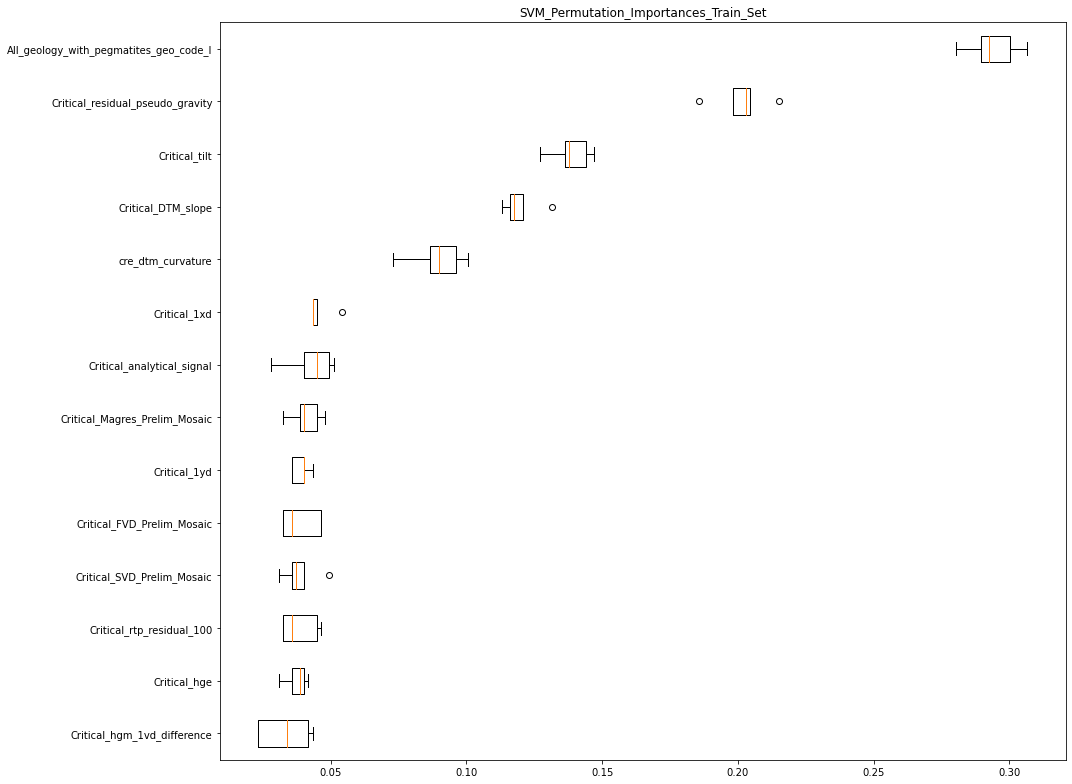

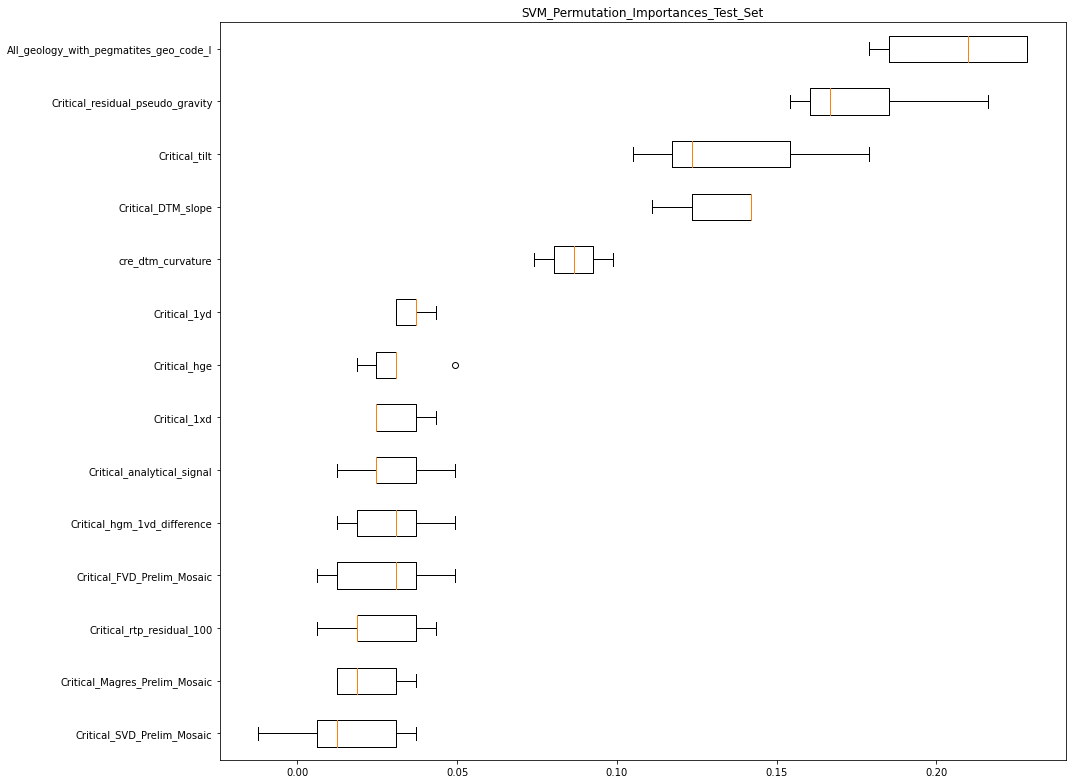

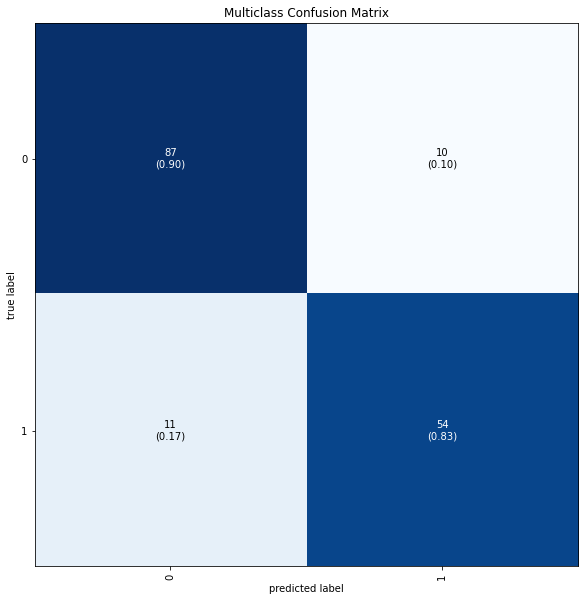

inferred resolution from coordinates is 5

5 geotiffs written.
Baseline_Model_July28_Li/predictions/SVM_predictions/predictions.tif
Baseline_Model_July28_Li/predictions/SVM_predictions/0_probability.tif
Baseline_Model_July28_Li/predictions/SVM_predictions/1_probability.tif
Baseline_Model_July28_Li/predictions/SVM_predictions/maxProb.tif
Baseline_Model_July28_Li/predictions/SVM_predictions/entropy.tif


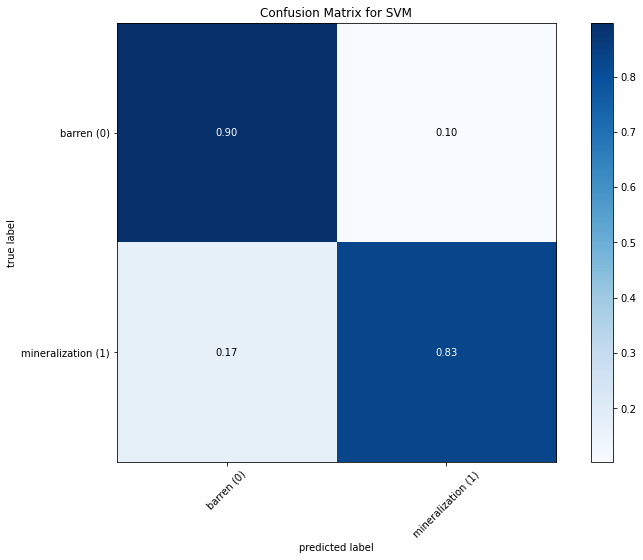

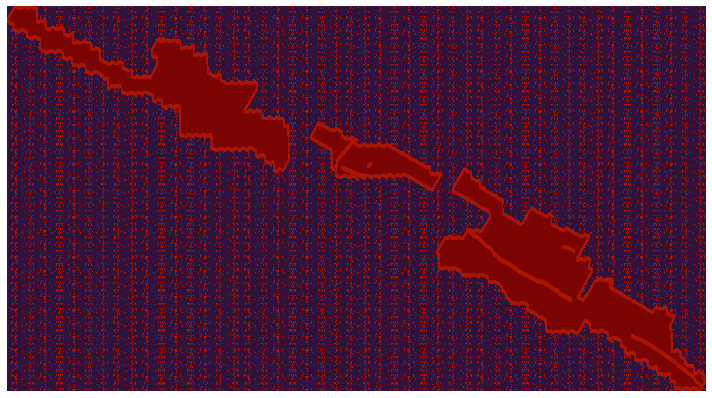

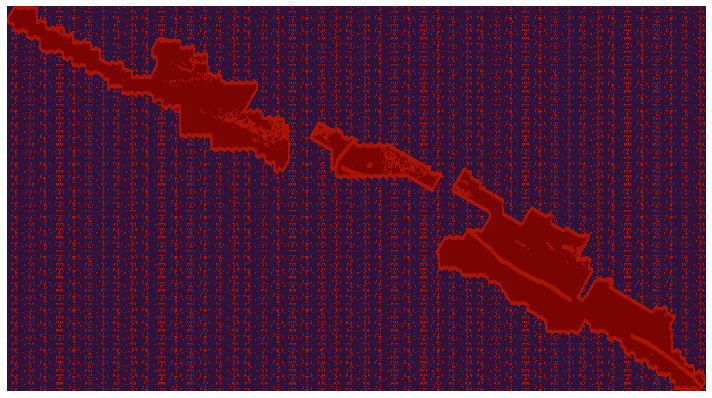

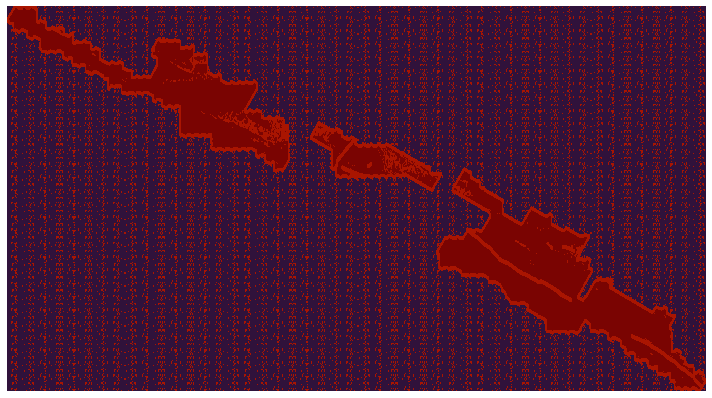

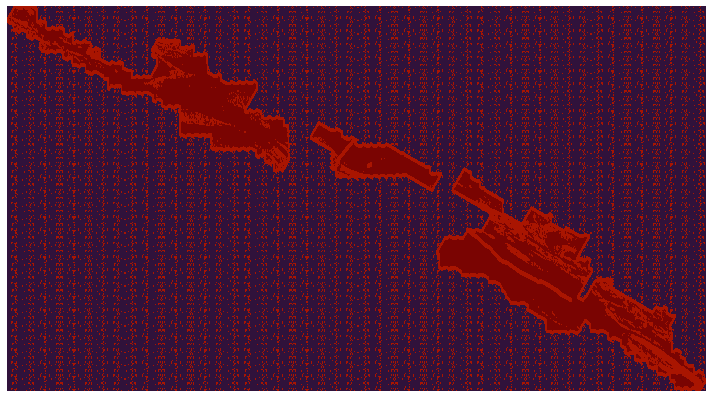

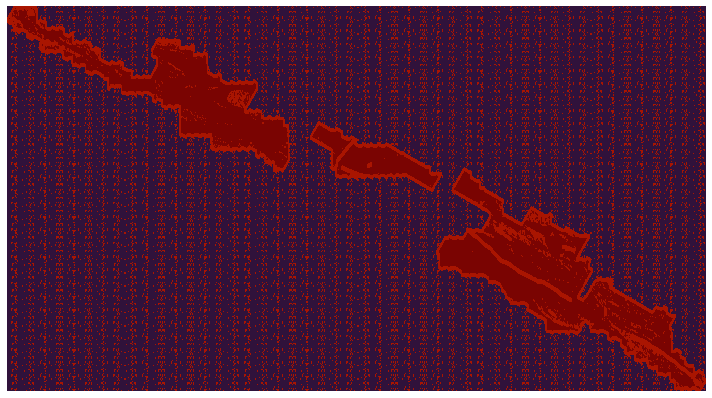

CatBoost_bestpipeline_fitted_model


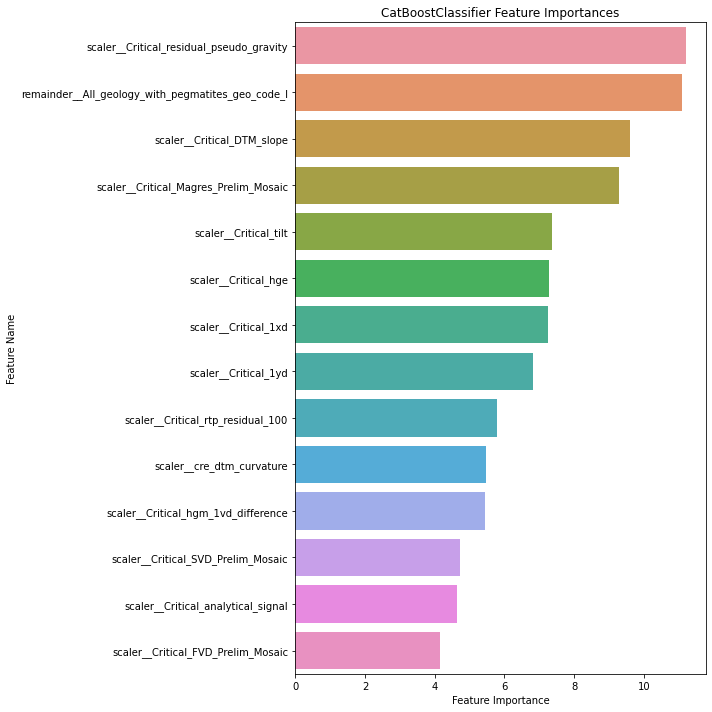

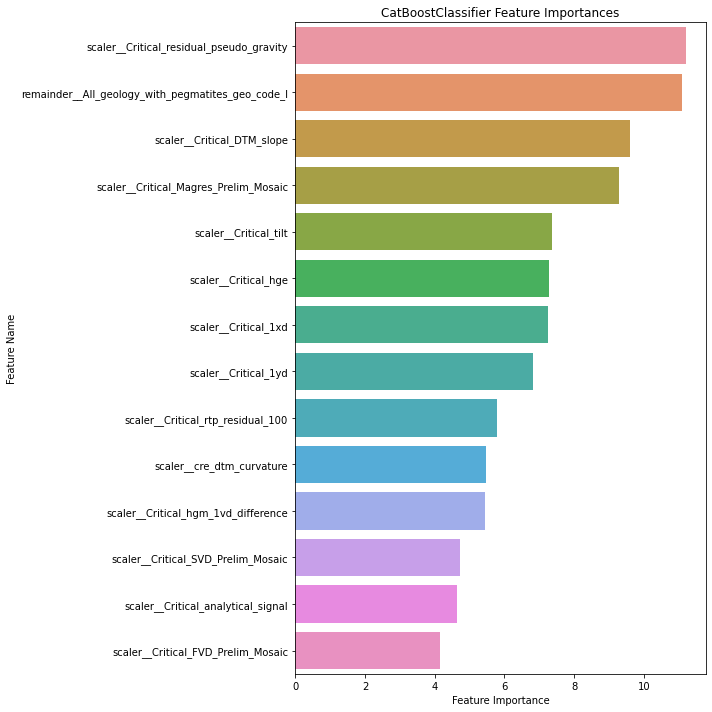

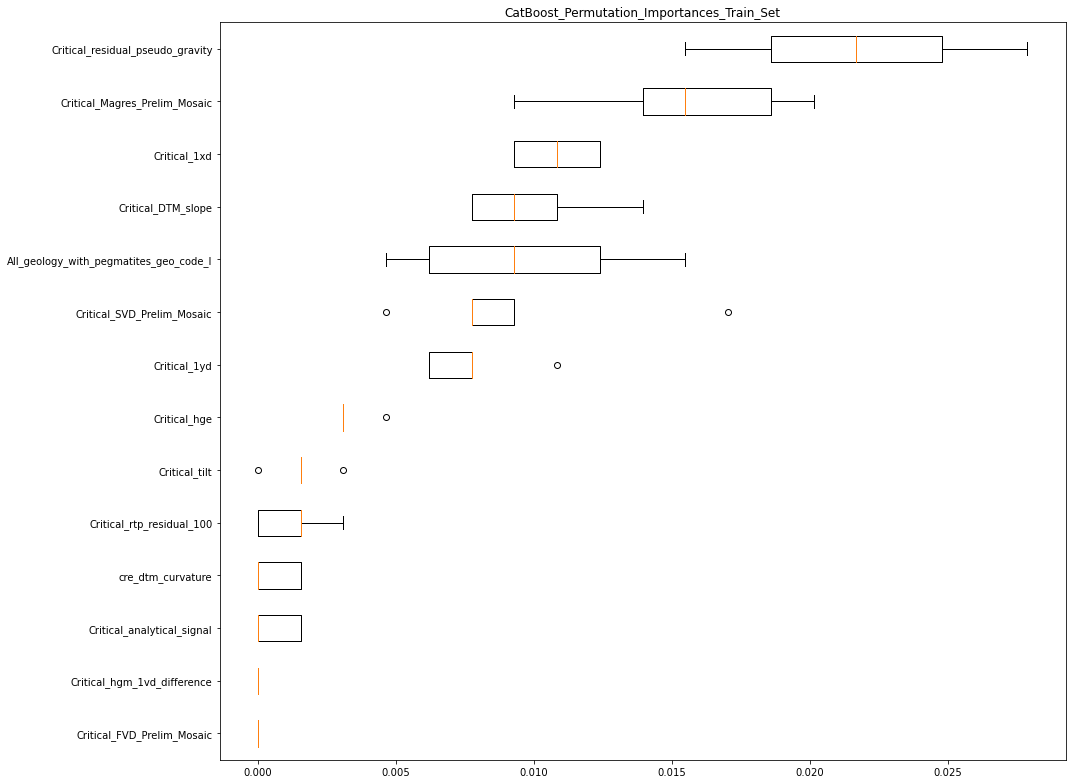

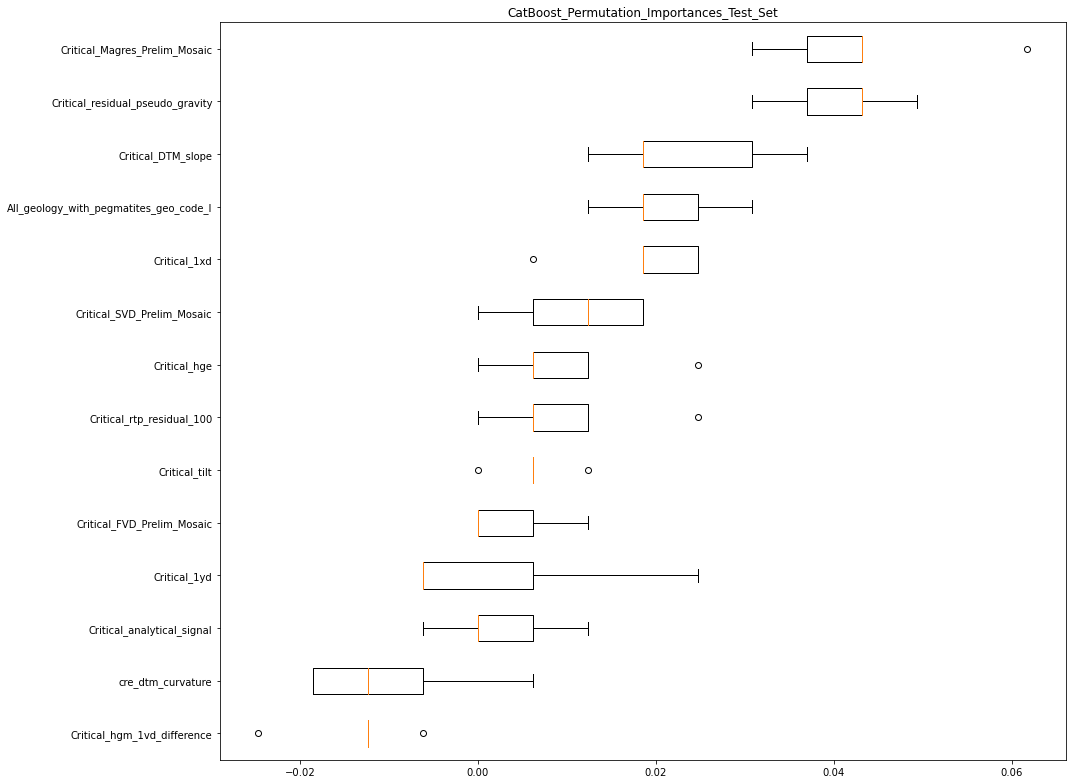

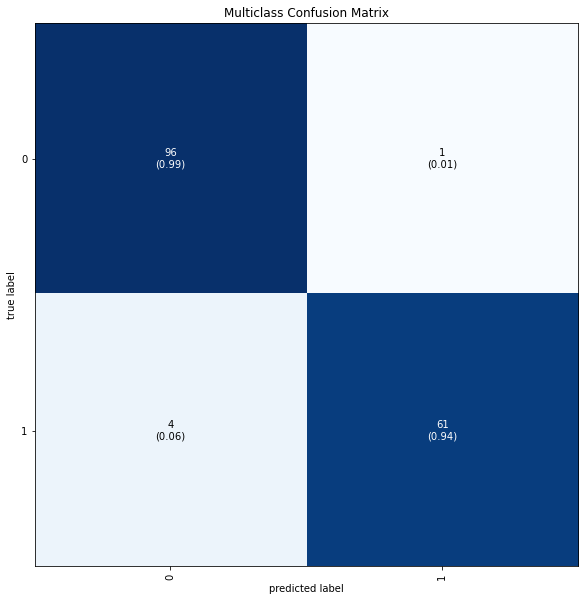

inferred resolution from coordinates is 5

5 geotiffs written.
Baseline_Model_July28_Li/predictions/CatBoost_predictions/predictions.tif
Baseline_Model_July28_Li/predictions/CatBoost_predictions/0_probability.tif
Baseline_Model_July28_Li/predictions/CatBoost_predictions/1_probability.tif
Baseline_Model_July28_Li/predictions/CatBoost_predictions/maxProb.tif
Baseline_Model_July28_Li/predictions/CatBoost_predictions/entropy.tif


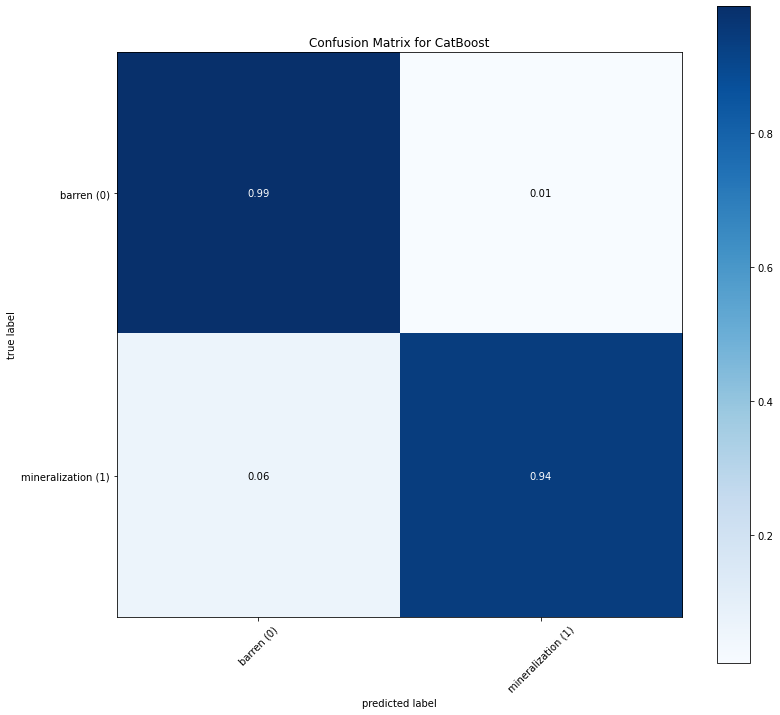

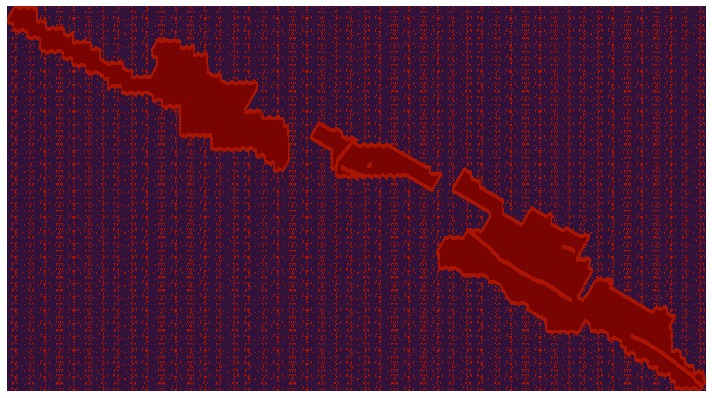

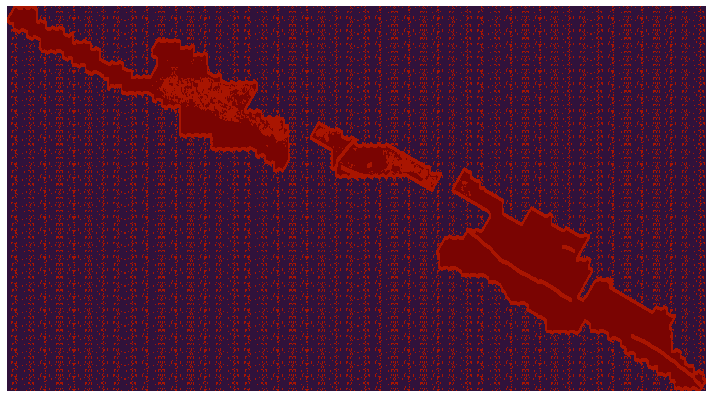

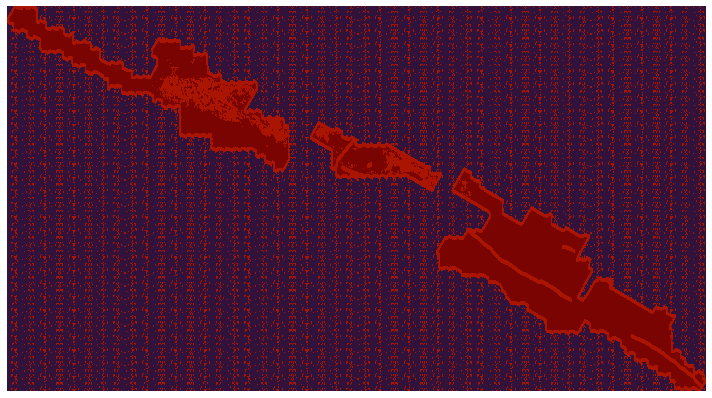

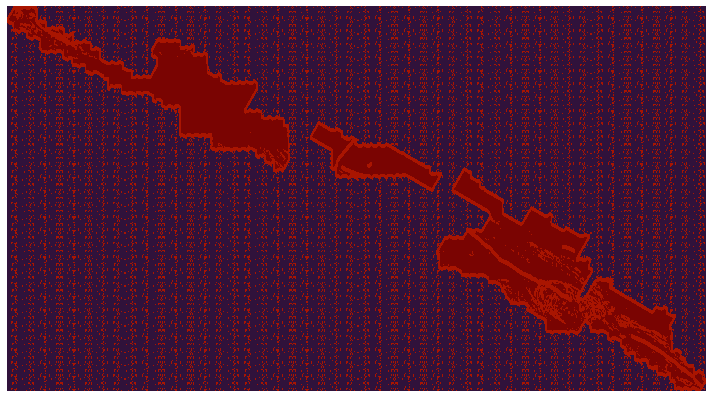

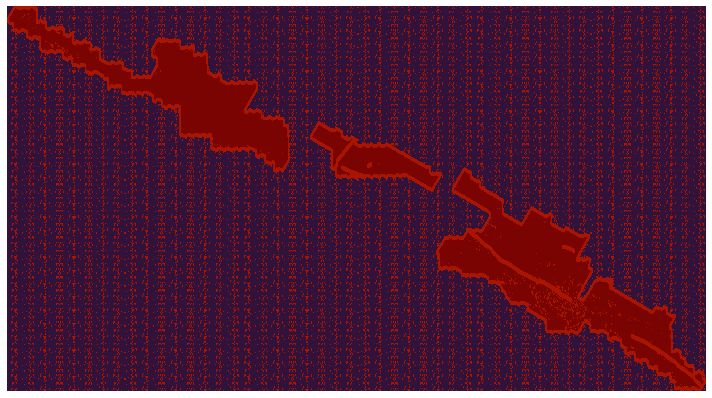

LGBM_bestpipeline_fitted_model


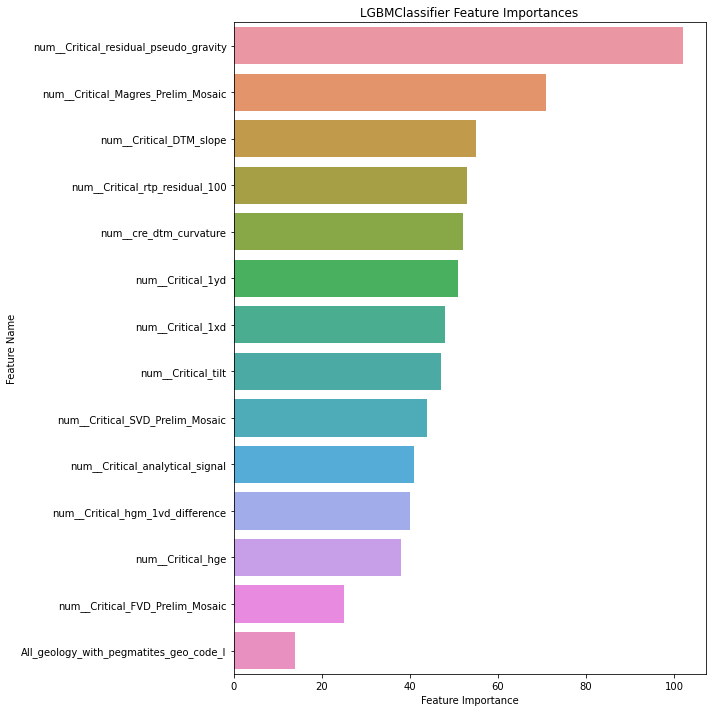

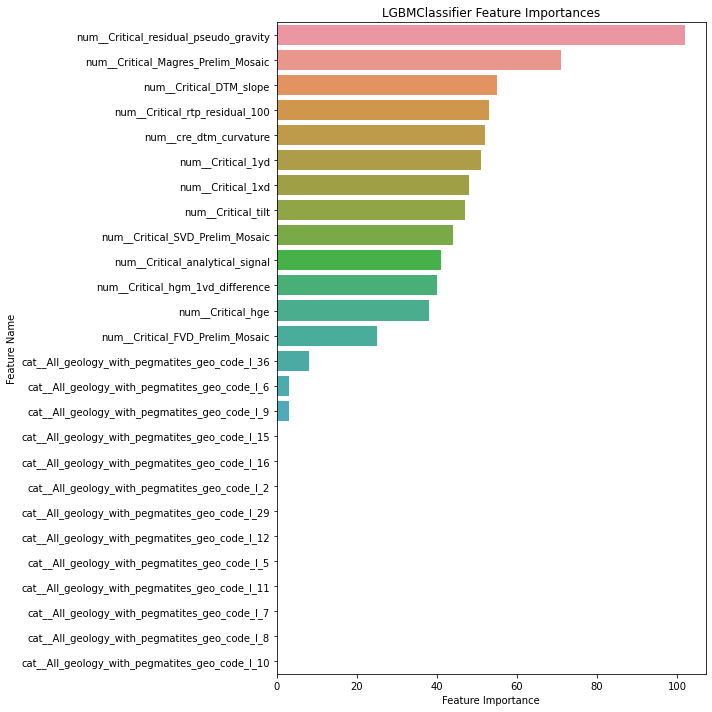

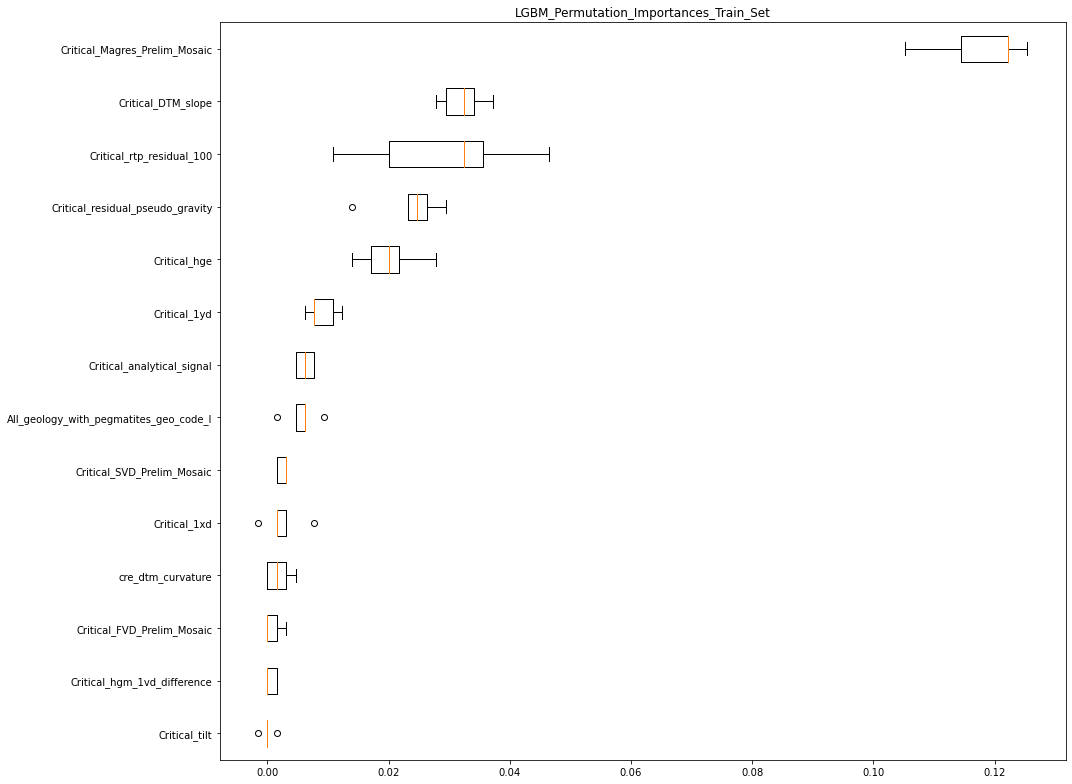

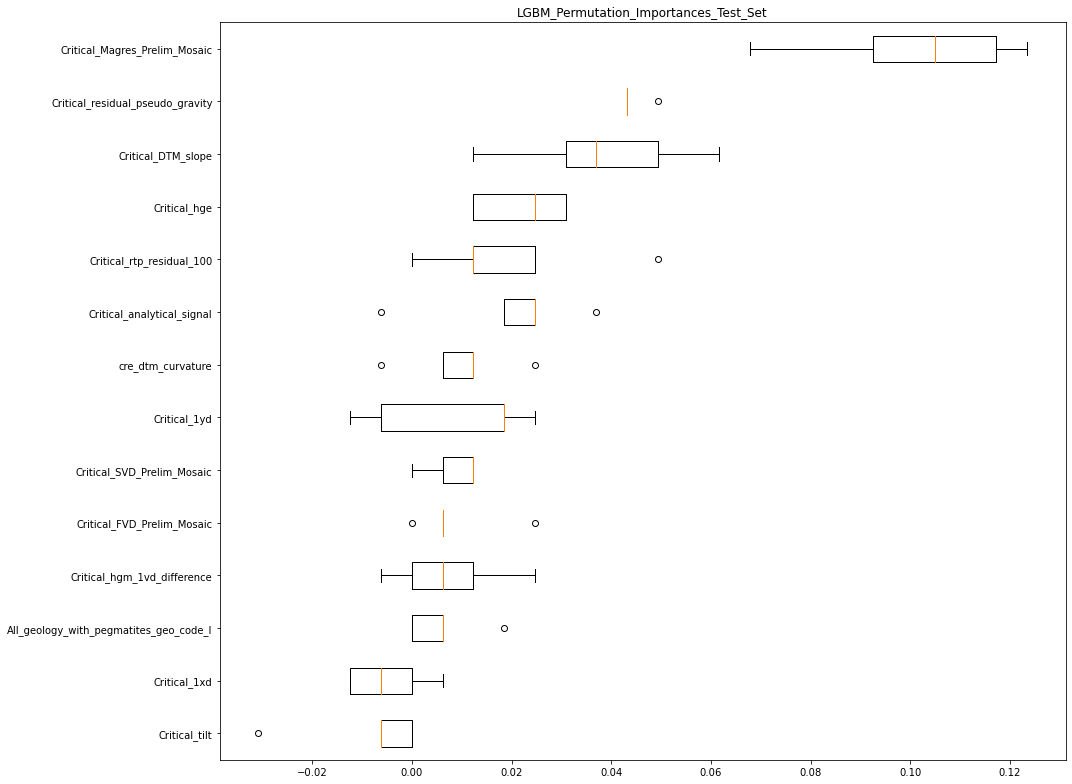

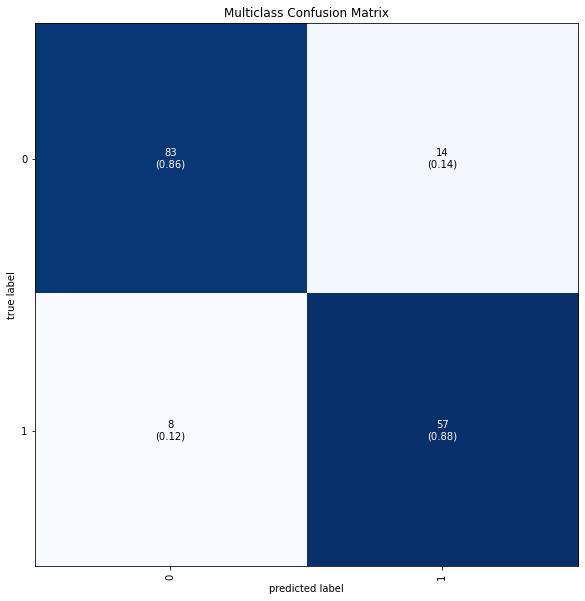

inferred resolution from coordinates is 5

5 geotiffs written.
Baseline_Model_July28_Li/predictions/LGBM_predictions/predictions.tif
Baseline_Model_July28_Li/predictions/LGBM_predictions/0_probability.tif
Baseline_Model_July28_Li/predictions/LGBM_predictions/1_probability.tif
Baseline_Model_July28_Li/predictions/LGBM_predictions/maxProb.tif
Baseline_Model_July28_Li/predictions/LGBM_predictions/entropy.tif


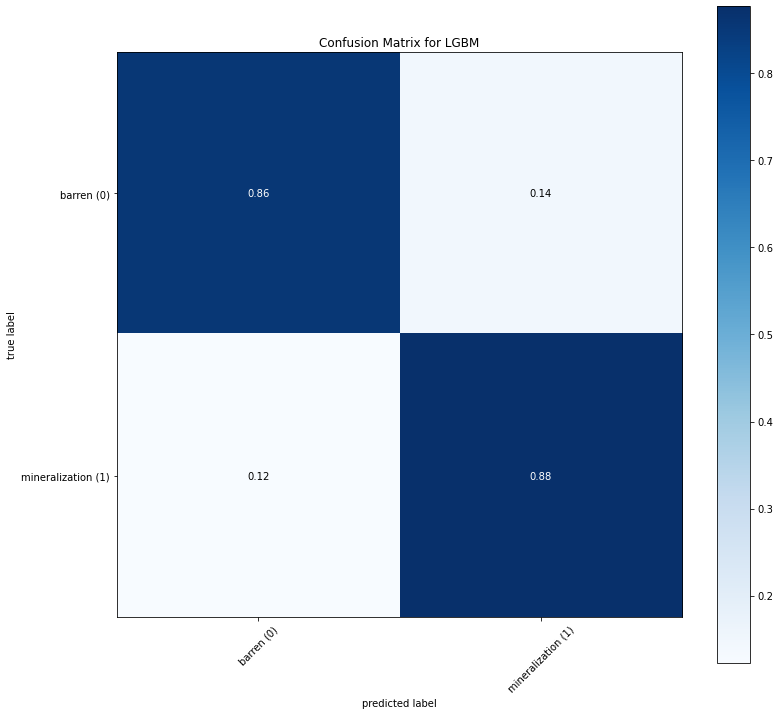

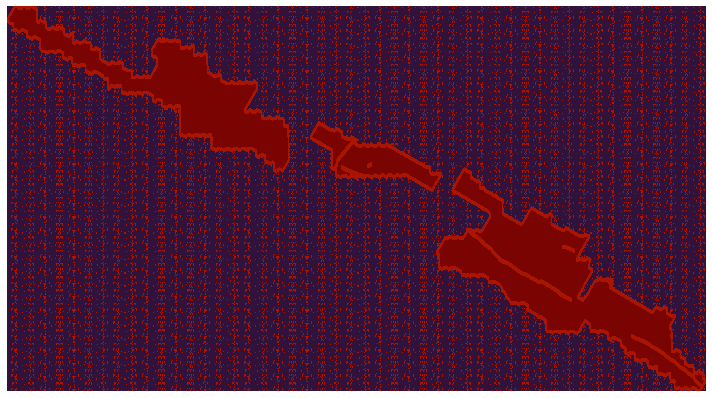

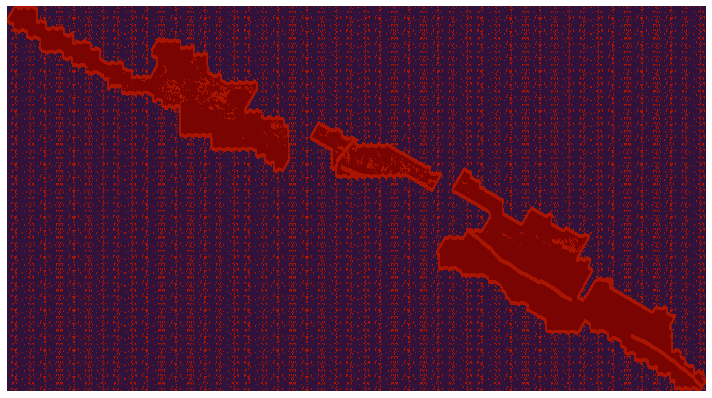

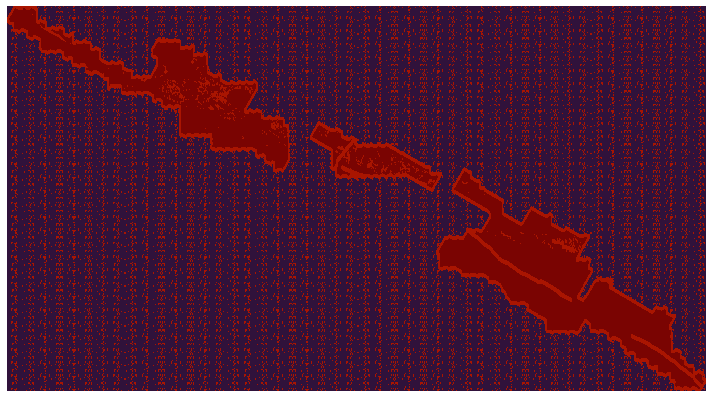

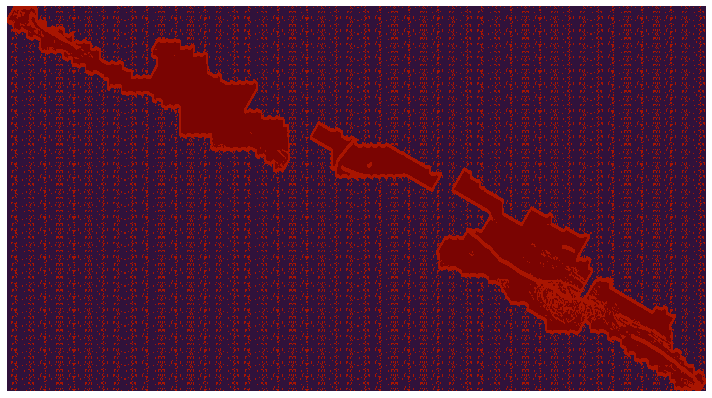

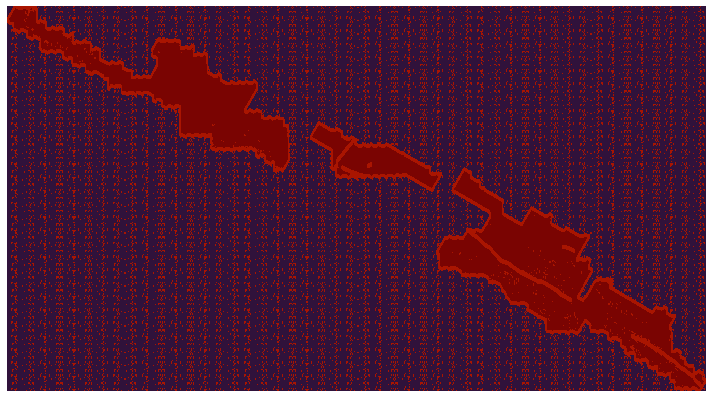

RandomForest_bestpipeline_fitted_model


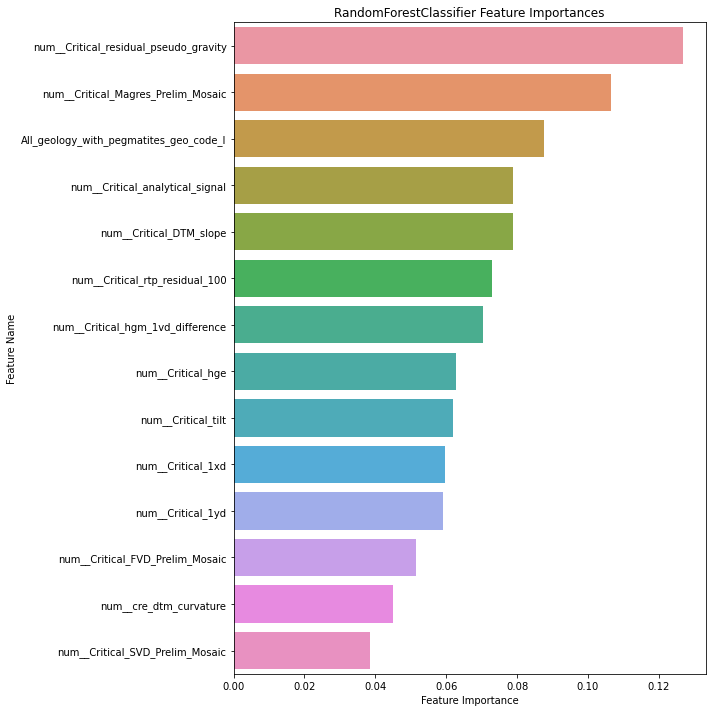

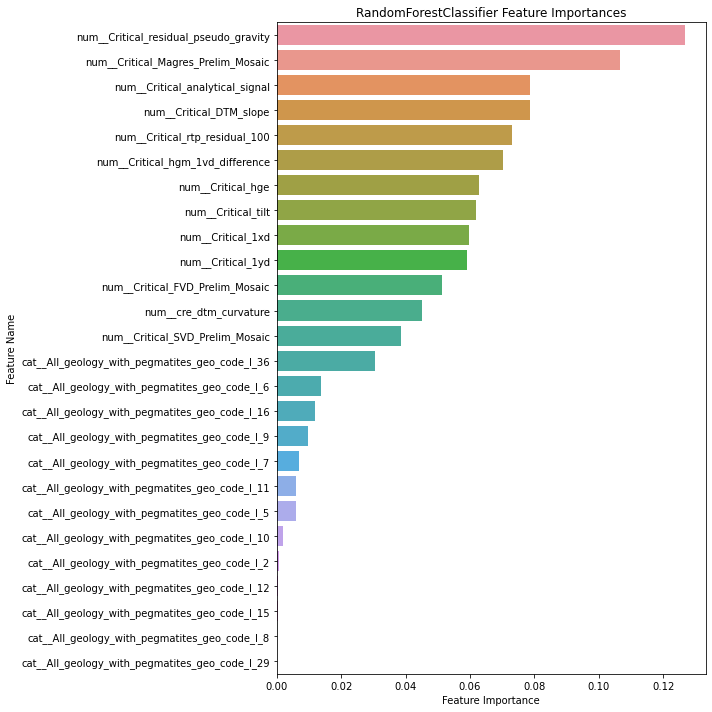

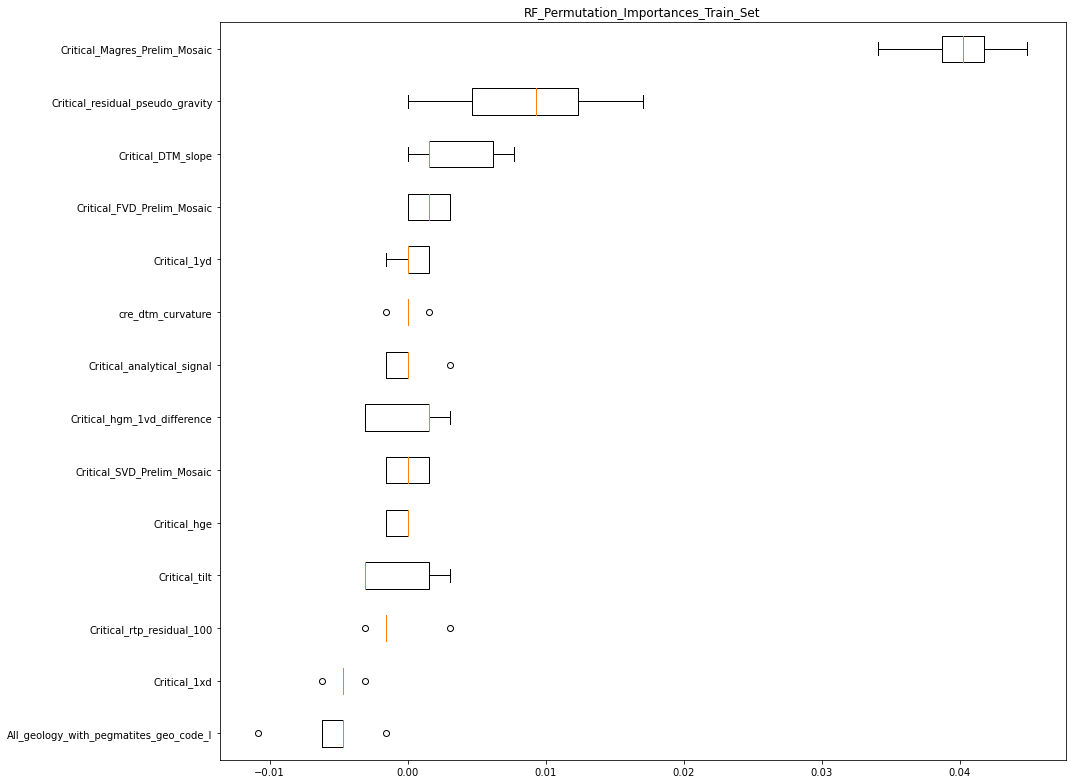

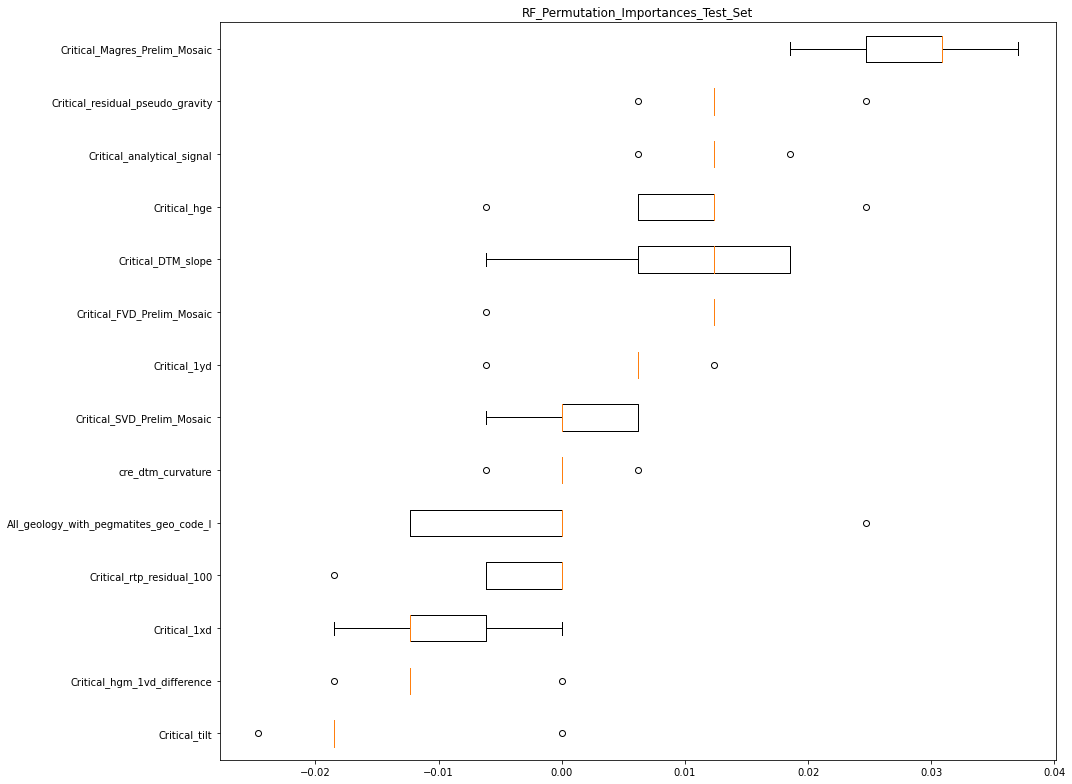

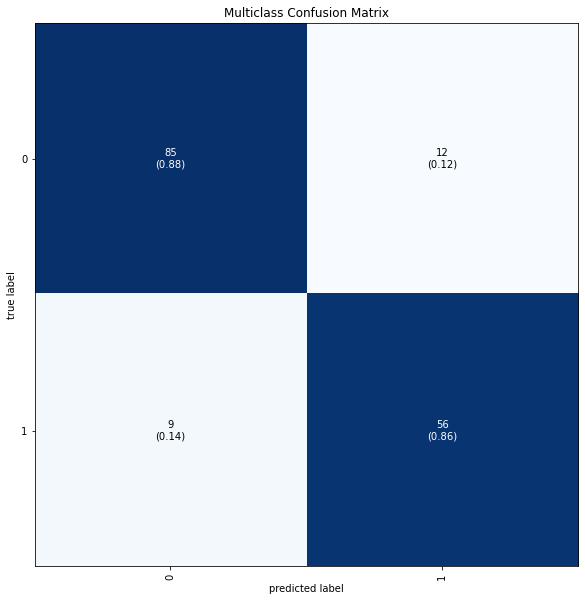

inferred resolution from coordinates is 5

5 geotiffs written.
Baseline_Model_July28_Li/predictions/RF_predictions/predictions.tif
Baseline_Model_July28_Li/predictions/RF_predictions/0_probability.tif
Baseline_Model_July28_Li/predictions/RF_predictions/1_probability.tif
Baseline_Model_July28_Li/predictions/RF_predictions/maxProb.tif
Baseline_Model_July28_Li/predictions/RF_predictions/entropy.tif


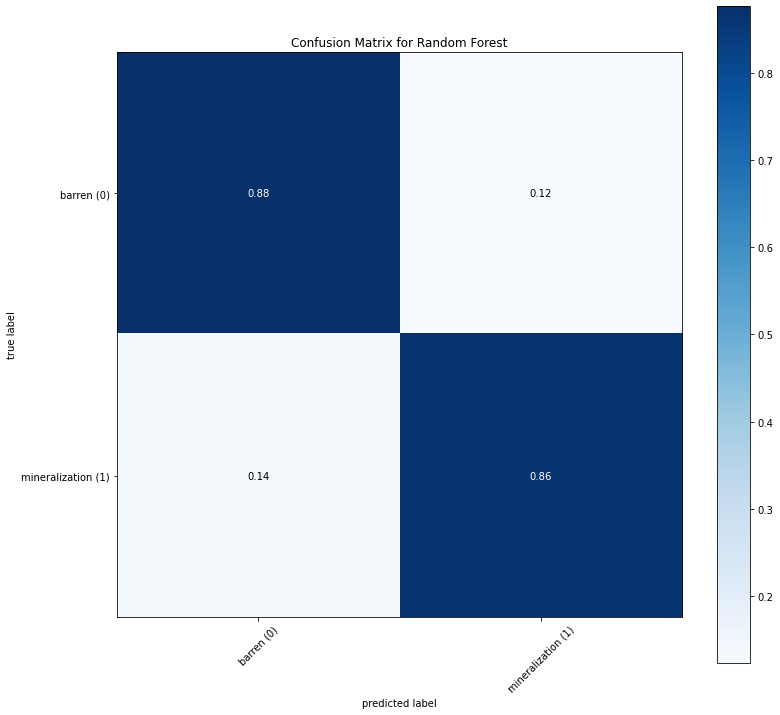

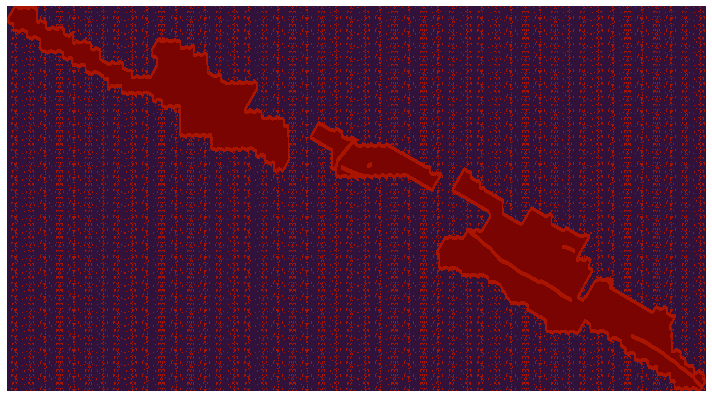

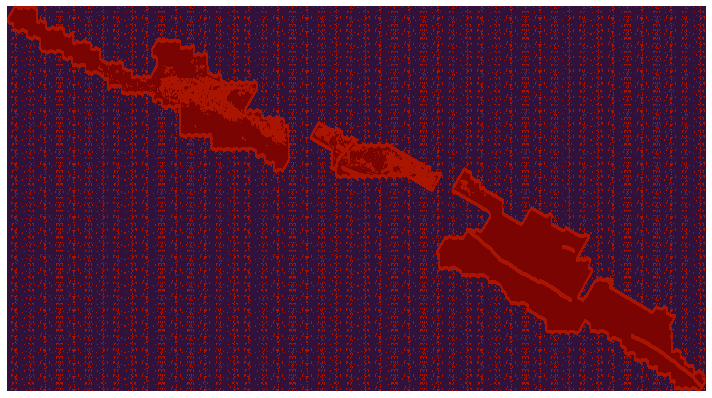

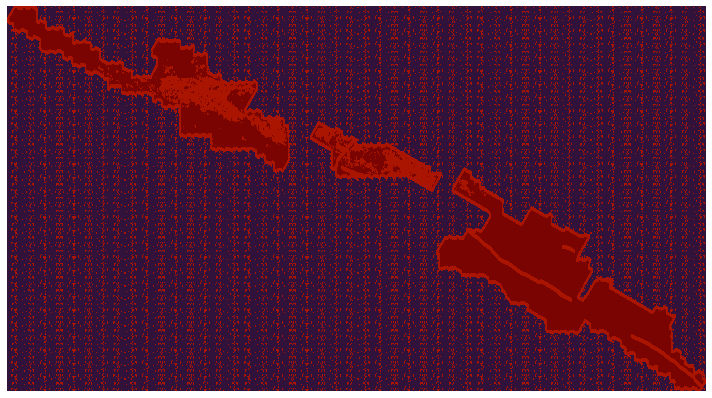

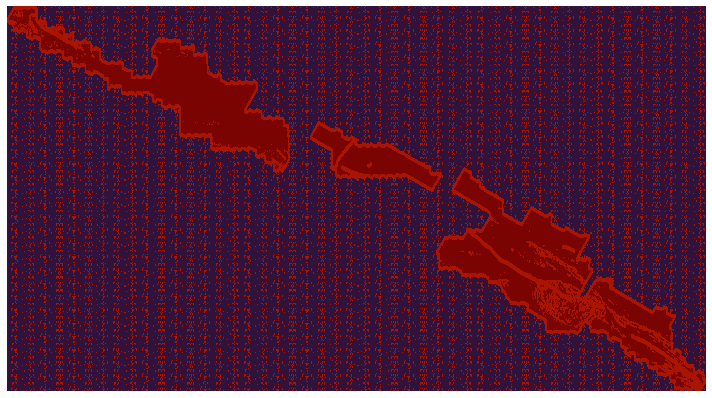

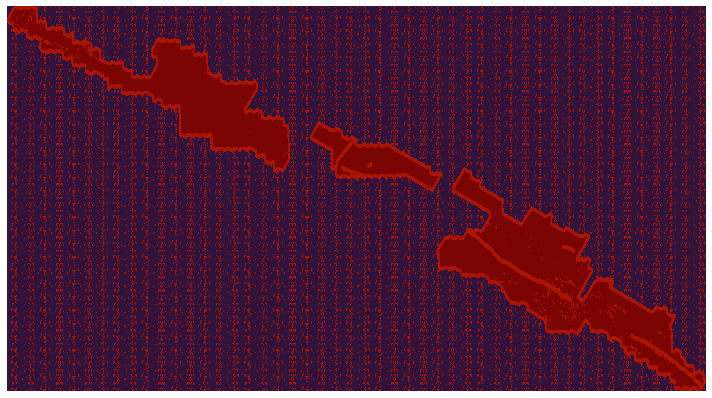

In [66]:
best_fitted_models = hyperparameterstuning.loadJobsFromFolder(output_folder+"/models/")
metrics = {}

for model in best_fitted_models.keys():
    print(model)
    model_path = output_folder + 'models/' + f'{model}.joblib'
    
    # load models from disk
    if model == 'SVM_bestpipeline_fitted_model':
        SVM_bestpipeline_fitted_model = load(model_path)
        plot_permutation_importance(SVM_bestpipeline_fitted_model, X_train, y_train, output_directory=SVM_predictions_folder, 
                            title= 'SVM_Permutation_Importances_Train_Set')
        plot_permutation_importance(SVM_bestpipeline_fitted_model, X_test, y_test, output_directory=SVM_predictions_folder, 
                            title= 'SVM_Permutation_Importances_Test_Set')

        # Predictions on the test set
        y_pred = SVM_bestpipeline_fitted_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        prec = precision_score(y_test, y_pred, average="macro")
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        metrics["SVM"] = {"f1": f1, "Precision": prec, "Recall":recall, "Accuracy":acc}
        
        all_predictions = SVM_bestpipeline_fitted_model.predict(all_X)
        all_predicted_prob = SVM_bestpipeline_fitted_model.predict_proba(all_X)

        prob_class = ['0_probability','1_probability']
        predictions = cube.subset(['coordinates'])
        predictions['predictions'] = all_predictions.tolist()
        predictions[prob_class] = all_predicted_prob
        predictions['maxProb'] = np.max(all_predicted_prob, 1)
        from scipy.stats import entropy
        predictions['entropy'] = entropy(all_predicted_prob, axis = 1)/np.log(len(np.unique(y_train)))
        correspondance_dict = {0: "0", 1: "1"}

        actual_classes = y_test.unique().tolist()
        actual_classes.sort()
        classes = replace_classes(actual_classes, correspondance_dict)

        reporting.multiclass_confusion_matrix_plot(y_test, y_pred, actual_classes, SVM_predictions_folder)
        confusion_matrix_plot(y_test, y_pred, title="SVM", output_directory=SVM_predictions_folder)

        predictions_columns = ['predictions', '0_probability', '1_probability', 'maxProb', 'entropy']
        #utilities.csv_to_raster(predictions, os.path.join(SVM_predictions_folder), predictions_columns, None, 'x','y', crs)
        #for predictions_column in predictions_columns:
        #    csv_to_raster_geocube(predictions, 
        #                      os.path.join(SVM_predictions_folder, predictions_column + '.tif'), 
        #                      crs,
        #                      'x', 
        #                      'y', 
        #                      predictions_column, 
        #                      xRes=pixel_size, 
        #                      yRes=pixel_size)
        
        df_to_gtiffs(
                predictions,
                crs,
                outfolder=os.path.join(SVM_predictions_folder),
                x_col='x',
                y_col='y',
                features=None,
                nodata=-9999,
                verbose=True)
        
        tifs = glob.glob(SVM_predictions_folder + '*.tif')        
        
        for t in tifs:
            filename,  extension, directory= utilities.Path_Info(t)
            utilities.geotiff_to_jpg(t, os.path.join(SVM_predictions_folder, filename + '.jpg')) 
        
    if model == 'CatBoost_bestpipeline_fitted_model':
        CatBoost_bestpipeline_fitted_model = load(model_path)
        plot_feature_importance(CatBoost_bestpipeline_fitted_model,
                          output_directory=CatBoost_predictions_folder, 
                          title= 'CatBoost_Feature_Importances_Combined.png')
        plot_feature_importance(CatBoost_bestpipeline_fitted_model,
                          combine_cat_class_importances = False,
                          output_directory=CatBoost_predictions_folder, 
                          title= 'CatBoost_Feature_Importances_Individual.png')
                
        plot_permutation_importance(CatBoost_bestpipeline_fitted_model, X_train, y_train, output_directory=CatBoost_predictions_folder, 
                            title= 'CatBoost_Permutation_Importances_Train_Set')
        plot_permutation_importance(CatBoost_bestpipeline_fitted_model, X_test, y_test, output_directory=CatBoost_predictions_folder, 
                            title= 'CatBoost_Permutation_Importances_Test_Set')
        
        # Predictions on the test set
        y_pred = CatBoost_bestpipeline_fitted_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        prec = precision_score(y_test, y_pred, average="macro")
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        metrics["CatBoost"] = {"f1": f1, "Precision": prec, "Recall":recall, "Accuracy":acc}
        
        all_predictions = CatBoost_bestpipeline_fitted_model.predict(all_X)
        all_predicted_prob = CatBoost_bestpipeline_fitted_model.predict_proba(all_X)

        prob_class = ['0_probability','1_probability']
        predictions = cube.subset(['coordinates'])
        predictions['predictions'] = all_predictions.tolist()
        predictions[prob_class] = all_predicted_prob
        predictions['maxProb'] = np.max(all_predicted_prob, 1)
        from scipy.stats import entropy
        predictions['entropy'] = entropy(all_predicted_prob, axis = 1)/np.log(len(np.unique(y_train)))
        correspondance_dict = {0: "0", 1: "1"}

        actual_classes = y_test.unique().tolist()
        actual_classes.sort()
        classes = replace_classes(actual_classes, correspondance_dict)

        reporting.multiclass_confusion_matrix_plot(y_test, y_pred, actual_classes, CatBoost_predictions_folder)
        confusion_matrix_plot(y_test, y_pred, title="CatBoost", output_directory=CatBoost_predictions_folder)

        predictions_columns = ['predictions', '0_probability', '1_probability', 'maxProb', 'entropy']
        #utilities.csv_to_raster(predictions, os.path.join(CatBoost_predictions_folder), predictions_columns, None, 'x','y', crs)
        #for predictions_column in predictions_columns:
        #    csv_to_raster_geocube(predictions, 
        #                      os.path.join(CatBoost_predictions_folder, predictions_column + '.tif'), 
        #                      crs,
        #                      'x', 
        #                      'y', 
        #                      predictions_column, 
        #                      xRes=pixel_size, 
        #                      yRes=pixel_size)
        
        df_to_gtiffs(
                predictions,
                crs,
                outfolder=os.path.join(CatBoost_predictions_folder),
                x_col='x',
                y_col='y',
                features=None,
                nodata=-9999,
                verbose=True)
        
        tifs = glob.glob(CatBoost_predictions_folder + '*.tif')

        for t in tifs:
            filename,  extension, directory= utilities.Path_Info(t)
            utilities.geotiff_to_jpg(t, os.path.join(CatBoost_predictions_folder, filename + '.jpg'))
        
    if model == 'XGBoost_bestpipeline_fitted_model':
        XGBoost_bestpipeline_fitted_model = load(model_path)
        plot_feature_importance(XGBoost_bestpipeline_fitted_model,
                          output_directory=XGBoost_predictions_folder, 
                          title= 'XGBoost_Feature_Importances_Combined.png')
        plot_feature_importance(XGBoost_bestpipeline_fitted_model,
                          combine_cat_class_importances = False,
                          output_directory=XGBoost_predictions_folder, 
                          title= 'XGBoost_Feature_Importances_Individual.png')

        plot_permutation_importance(XGBoost_bestpipeline_fitted_model, X_train, y_train, output_directory=XGBoost_predictions_folder, 
                            title= 'XGBoost_Permutation_Importances_Train_Set')
        plot_permutation_importance(XGBoost_bestpipeline_fitted_model, X_test, y_test, output_directory=XGBoost_predictions_folder, 
                            title= 'XGBoost_Permutation_Importances_Test_Set')
        
        # Predictions on the test set
        y_pred = XGBoost_bestpipeline_fitted_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        prec = precision_score(y_test, y_pred, average="macro")
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        metrics["XGBoost"] = {"f1": f1, "Precision": prec, "Recall":recall, "Accuracy":acc}
        
        all_predictions = XGBoost_bestpipeline_fitted_model.predict(all_X)
        all_predicted_prob = XGBoost_bestpipeline_fitted_model.predict_proba(all_X)

        prob_class = ['0_probability','1_probability']
        predictions = cube.subset(['coordinates'])
        predictions['predictions'] = all_predictions.tolist()
        predictions[prob_class] = all_predicted_prob
        predictions['maxProb'] = np.max(all_predicted_prob, 1)
        from scipy.stats import entropy
        predictions['entropy'] = entropy(all_predicted_prob, axis = 1)/np.log(len(np.unique(y_train)))
        correspondance_dict = {0: "0", 1: "1"}

        actual_classes = y_test.unique().tolist()
        actual_classes.sort()
        classes = replace_classes(actual_classes, correspondance_dict)

        reporting.multiclass_confusion_matrix_plot(y_test, y_pred, actual_classes, XGBoost_predictions_folder)
        confusion_matrix_plot(y_test, y_pred, title="XGBoost", output_directory=XGBoost_predictions_folder)

        predictions_columns = ['predictions', '0_probability', '1_probability', 'maxProb', 'entropy']
        #utilities.csv_to_raster(predictions, os.path.join(XGBoost_predictions_folder), predictions_columns, None, 'x','y', crs)
        #for predictions_column in predictions_columns:
        #    csv_to_raster_geocube(predictions, 
        #                      os.path.join(XGBoost_predictions_folder, predictions_column + '.tif'), 
        #                      crs,
        #                      'x', 
        #                      'y', 
        #                      predictions_column, 
        #                      xRes=pixel_size, 
        #                      yRes=pixel_size)
        
        df_to_gtiffs(
                predictions,
                crs,
                outfolder=os.path.join(XGBoost_predictions_folder),
                x_col='x',
                y_col='y',
                features=None,
                nodata=-9999,
                verbose=True)      
    
        tifs = glob.glob(XGBoost_predictions_folder + '*.tif')

        for t in tifs:
            filename,  extension, directory= utilities.Path_Info(t)
            utilities.geotiff_to_jpg(t, os.path.join(XGBoost_predictions_folder, filename + '.jpg'))
                
    if model == 'LGBM_bestpipeline_fitted_model':
        LGBM_bestpipeline_fitted_model = load(model_path)
        
        plot_feature_importance(LGBM_bestpipeline_fitted_model,
                          output_directory=LGBM_predictions_folder, 
                          title= 'LGBM_Feature_Importances_Combined.png')
        plot_feature_importance(LGBM_bestpipeline_fitted_model,
                          combine_cat_class_importances = False,
                          output_directory=LGBM_predictions_folder, 
                          title= 'LGBM_Feature_Importances_Individual.png') 
        
        plot_permutation_importance(LGBM_bestpipeline_fitted_model, X_train, y_train, output_directory=LGBM_predictions_folder, 
                            title= 'LGBM_Permutation_Importances_Train_Set')
        plot_permutation_importance(LGBM_bestpipeline_fitted_model, X_test, y_test, output_directory=LGBM_predictions_folder, 
                            title= 'LGBM_Permutation_Importances_Test_Set')
        
        # Predictions on the test set
        y_pred = LGBM_bestpipeline_fitted_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        prec = precision_score(y_test, y_pred, average="macro")
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        metrics["LGBM"] = {"f1": f1, "Precision": prec, "Recall":recall, "Accuracy":acc}
        
        all_predictions = LGBM_bestpipeline_fitted_model.predict(all_X)
        all_predicted_prob = LGBM_bestpipeline_fitted_model.predict_proba(all_X)

        prob_class = ['0_probability','1_probability']
        predictions = cube.subset(['coordinates'])
        predictions['predictions'] = all_predictions.tolist()
        predictions[prob_class] = all_predicted_prob
        predictions['maxProb'] = np.max(all_predicted_prob, 1)
        from scipy.stats import entropy
        predictions['entropy'] = entropy(all_predicted_prob, axis = 1)/np.log(len(np.unique(y_train)))
        correspondance_dict = {0: "0", 1: "1"}

        actual_classes = y_test.unique().tolist()
        actual_classes.sort()
        classes = replace_classes(actual_classes, correspondance_dict)

        reporting.multiclass_confusion_matrix_plot(y_test, y_pred, actual_classes, LGBM_predictions_folder)
        confusion_matrix_plot(y_test, y_pred, title="LGBM", output_directory=LGBM_predictions_folder)

        predictions_columns = ['predictions', '0_probability', '1_probability', 'maxProb', 'entropy']
        #utilities.csv_to_raster(predictions, os.path.join(LGBM_predictions_folder), predictions_columns, None, 'x','y', crs)
        #for predictions_column in predictions_columns:
        #    csv_to_raster_geocube(predictions, 
        #                      os.path.join(LGBM_predictions_folder, predictions_column + '.tif'), 
        #                      crs,
        #                      'x', 
        #                      'y', 
        #                      predictions_column, 
        #                      xRes=pixel_size, 
        #                      yRes=pixel_size)
            
        df_to_gtiffs(
                predictions,
                crs,
                outfolder=os.path.join(LGBM_predictions_folder),
                x_col='x',
                y_col='y',
                features=None,
                nodata=-9999,
                verbose=True) 
        
        tifs = glob.glob(LGBM_predictions_folder + '*.tif')

        for t in tifs:
            filename,  extension, directory= utilities.Path_Info(t)
            utilities.geotiff_to_jpg(t, os.path.join(LGBM_predictions_folder, filename + '.jpg'))
        
    if model == 'RandomForest_bestpipeline_fitted_model':
        RandomForest_bestpipeline_fitted_model = load(model_path)
        
        plot_feature_importance(RandomForest_bestpipeline_fitted_model,
                          output_directory=RF_predictions_folder, 
                          title= 'RF_Feature_Importances_Combined.png')
        plot_feature_importance(RandomForest_bestpipeline_fitted_model,
                          combine_cat_class_importances = False,
                          output_directory=RF_predictions_folder, 
                          title= 'RF_Feature_Importances_Individual.png')
        
        plot_permutation_importance(RandomForest_bestpipeline_fitted_model, X_train, y_train, output_directory=RF_predictions_folder, 
                            title= 'RF_Permutation_Importances_Train_Set')
        plot_permutation_importance(RandomForest_bestpipeline_fitted_model, X_test, y_test, output_directory=RF_predictions_folder, 
                            title= 'RF_Permutation_Importances_Test_Set')
        
        # Predictions on the test set
        y_pred = RandomForest_bestpipeline_fitted_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        prec = precision_score(y_test, y_pred, average="macro")
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        metrics["Random Forest"] = {"f1": f1, "Precision": prec, "Recall":recall, "Accuracy":acc}
        
        all_predictions = RandomForest_bestpipeline_fitted_model.predict(all_X)
        all_predicted_prob = RandomForest_bestpipeline_fitted_model.predict_proba(all_X)

        prob_class = ['0_probability','1_probability']
        predictions = cube.subset(['coordinates'])
        predictions['predictions'] = all_predictions.tolist()
        predictions[prob_class] = all_predicted_prob
        predictions['maxProb'] = np.max(all_predicted_prob, 1)
        from scipy.stats import entropy
        predictions['entropy'] = entropy(all_predicted_prob, axis = 1)/np.log(len(np.unique(y_train)))
        correspondance_dict = {0: "0", 1: "1"}

        actual_classes = y_test.unique().tolist()
        actual_classes.sort()
        classes = replace_classes(actual_classes, correspondance_dict)

        reporting.multiclass_confusion_matrix_plot(y_test, y_pred, actual_classes, RF_predictions_folder)
        confusion_matrix_plot(y_test, y_pred, title="Random Forest", output_directory=RF_predictions_folder)

        predictions_columns = ['predictions', '0_probability', '1_probability', 'maxProb', 'entropy']
        #utilities.csv_to_raster(predictions, os.path.join(RF_predictions_folder), predictions_columns, None, 'x','y', crs)
        #for predictions_column in predictions_columns:
        #    csv_to_raster_geocube(predictions, 
        #                      os.path.join(RF_predictions_folder, predictions_column + '.tif'), 
        #                      crs,
        #                      'x', 
        #                      'y', 
        #                      predictions_column, 
        #                      xRes=pixel_size, 
        #                      yRes=pixel_size)
       
        df_to_gtiffs(
                predictions,
                crs,
                outfolder=os.path.join(RF_predictions_folder),
                x_col='x',
                y_col='y',
                features=None,
                nodata=-9999,
                verbose=True)     
    
        tifs = glob.glob(RF_predictions_folder + '*.tif')

        for t in tifs:
            filename,  extension, directory= utilities.Path_Info(t)
            utilities.geotiff_to_jpg(t, os.path.join(RF_predictions_folder, filename + '.jpg'))
         

In [23]:
def geotiff_to_jpg(input_geotiff, output_path, nb_quantiles=20):
    """
    Convert a raster (geotiff) to jpg and show it in the console.
    Parameters
    ----------
    input_geotiff : str
        path to input geotiff
    output_path : str
        full path to save the jpg.
    nb_quantiles : int, default=20
        number of quantiles to use to bin the data into equals interval for the colorscale (Turbo). Default = 20
    Returns
    -------
    fig : Matplotlib.Figure
        Figure from matplotlib
    ax : Matplotlib.Axe
        Axe object from matplotlib
    Examples
    --------
        Convert a batch of PCs geotiffs from a folder and save them as jpg.
        >>> import glob
        >>> import os
        >>> input_folder = 'my_pcs_rasters/'
        >>> my_output_folder = 'my_jpgs/'
        >>> tifs = glob.glob(input_folder + '*.tif')
        >>> for t in tifs:
        >>>     filename,  extension, directory= utilities.Path_Info(t)
        >>>     utilities.raster_to_jpg(t, os.path.join(my_output_folder, filename + '.jpg'))
    """
    dataset = gdal.Open(input_geotiff, gdal.GA_ReadOnly)
    # Note GetRasterBand() takes band no. starting from 1 not 0
    band = dataset.GetRasterBand(1)
    arr = band.ReadAsArray()
    data = np.array(arr)
    #need to flip the data (y are negative
    data = np.flipud(data)
    increment = 1 / nb_quantiles
    bounds = np.nanquantile(data, np.arange(0, 1, increment))
    cmap = colors.Colormap('turbo')
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N)
    plt.rcParams["figure.figsize"] = (10, 10)
    fig, ax = plt.subplots()
    plt.imshow(data, origin='lower',cmap='turbo', norm=norm, interpolation='bicubic')  # norm=colors.TwoSlopeNorm(vcenter=0))

    plt.axis('off')
    # X-axis tick label
    # plt.xticks(color='w')
    # Y-axis tick label
    # plt.yticks(color='w')
    # plt.tick_params(left=False,bottom=False)
    plt.box(False)
    plt.tight_layout()
    # be sure not to cause crashe
    filename, extension, directory = Path_Info(input_geotiff)
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig(output_path)
    plt.show()

    return fig, ax


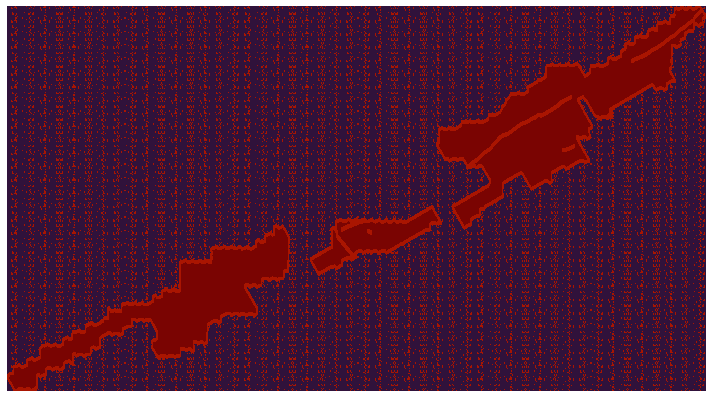

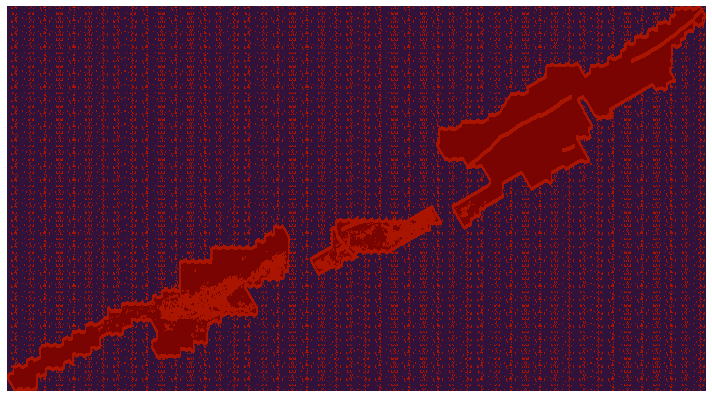

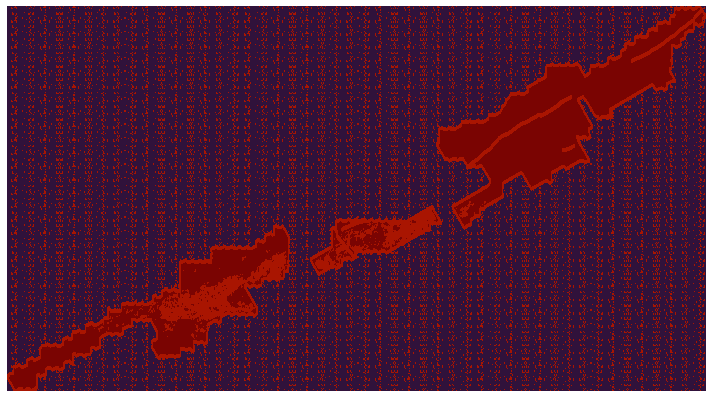

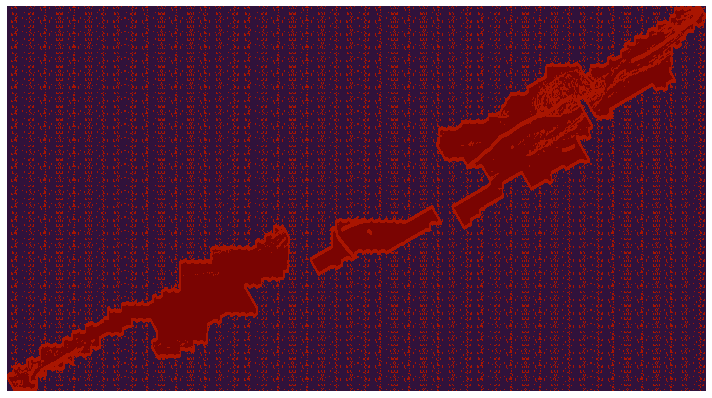

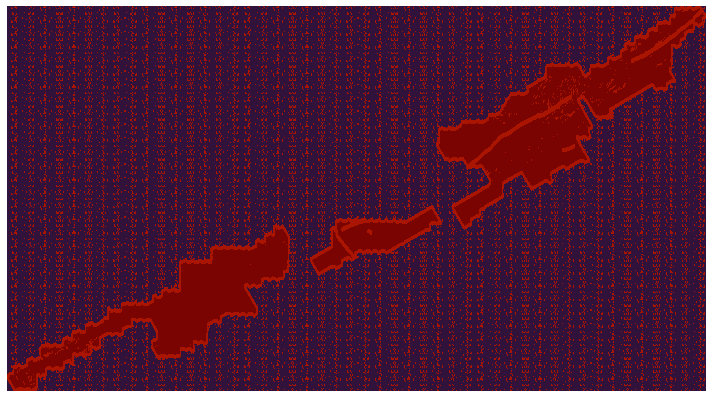

In [24]:
tifs = glob.glob(RF_predictions_folder + '*.tif')

for t in tifs:
    filename,  extension, directory= utilities.Path_Info(t)
    geotiff_to_jpg(t, os.path.join(RF_predictions_folder, filename + '.jpg'))

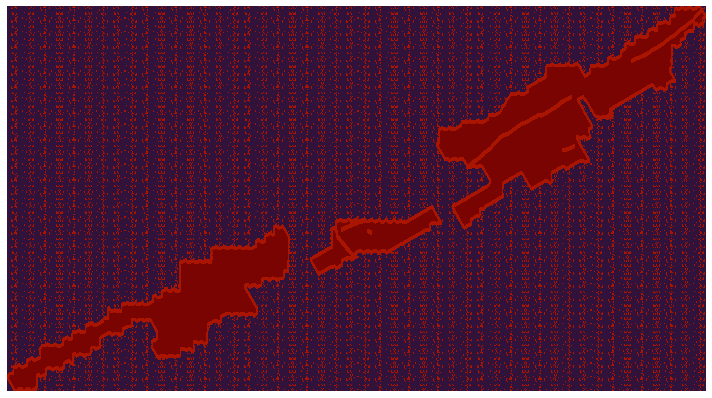

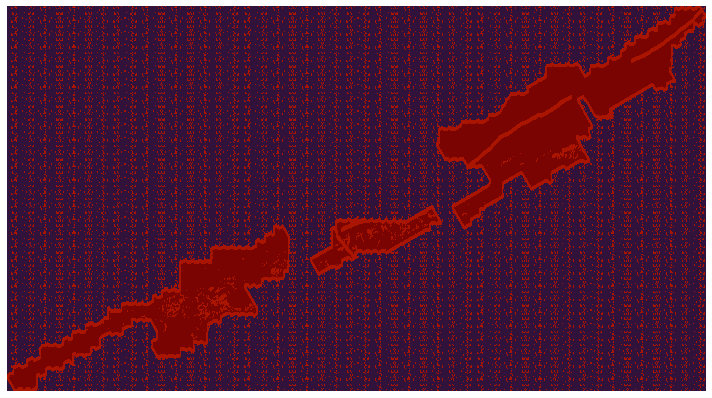

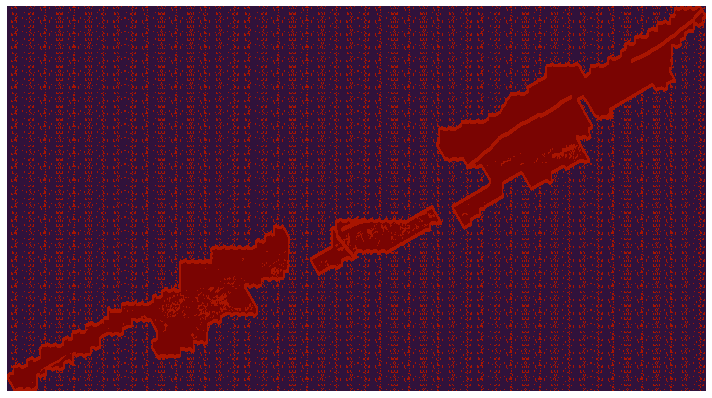

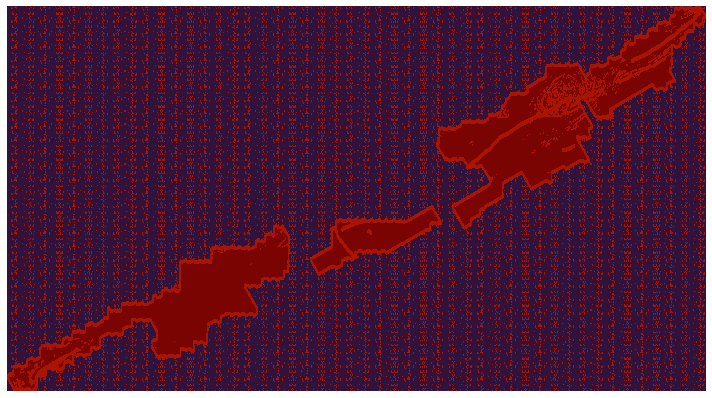

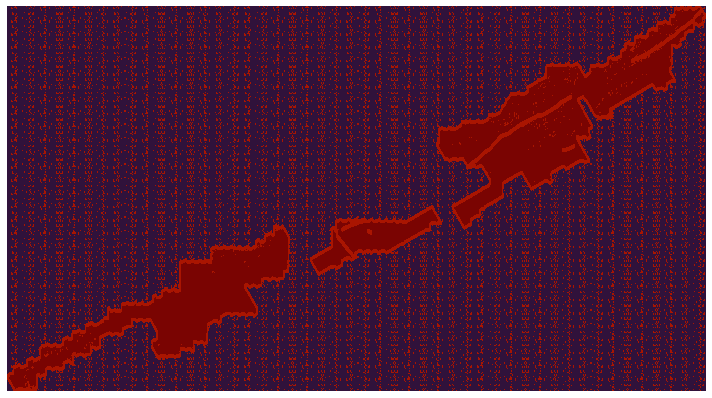

In [25]:
tifs = glob.glob(LGBM_predictions_folder + '*.tif')

for t in tifs:
    filename,  extension, directory= utilities.Path_Info(t)
    geotiff_to_jpg(t, os.path.join(LGBM_predictions_folder, filename + '.jpg'))

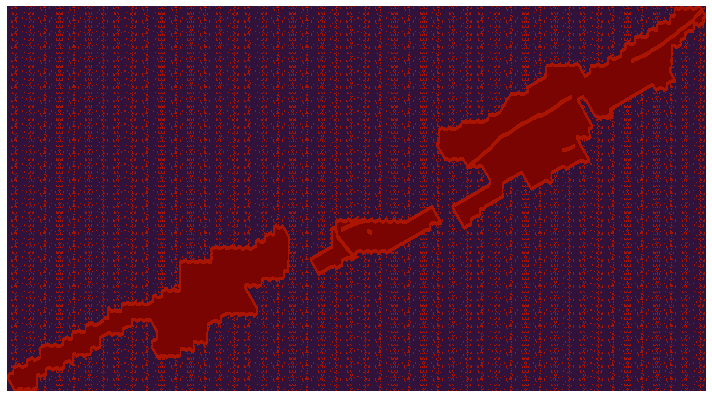

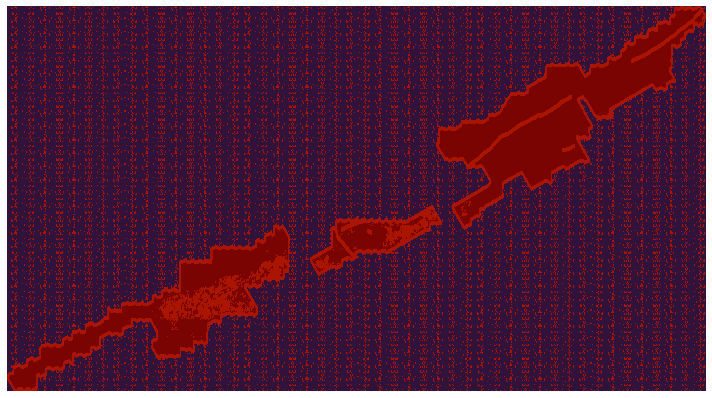

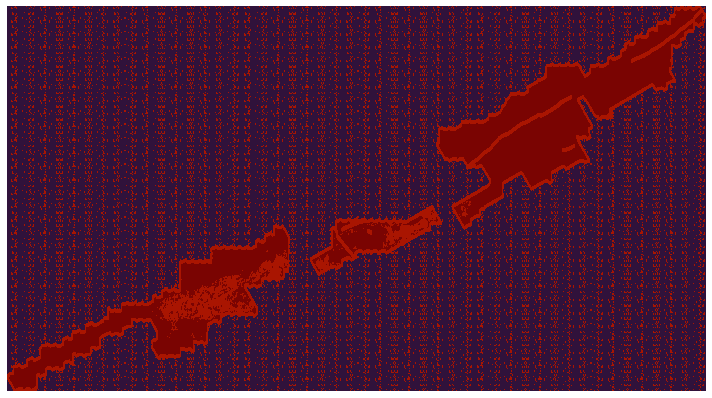

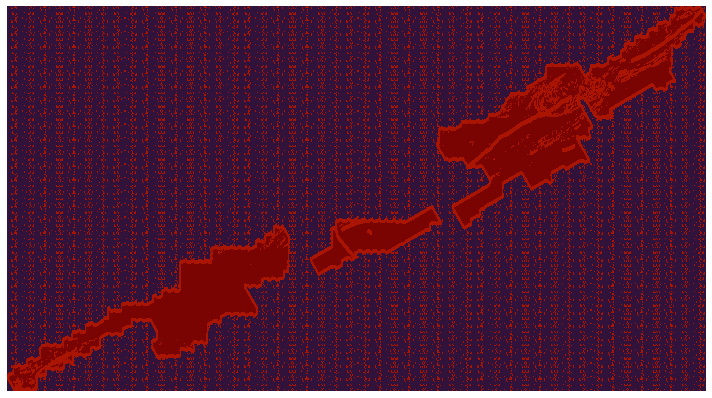

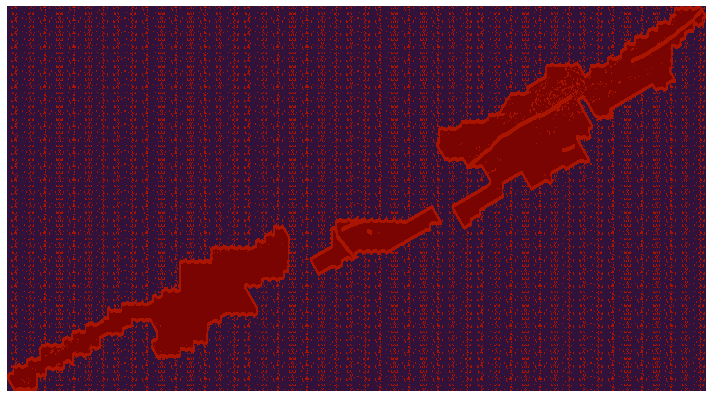

In [26]:
tifs = glob.glob(CatBoost_predictions_folder + '*.tif')

for t in tifs:
    filename,  extension, directory= utilities.Path_Info(t)
    geotiff_to_jpg(t, os.path.join(CatBoost_predictions_folder, filename + '.jpg'))

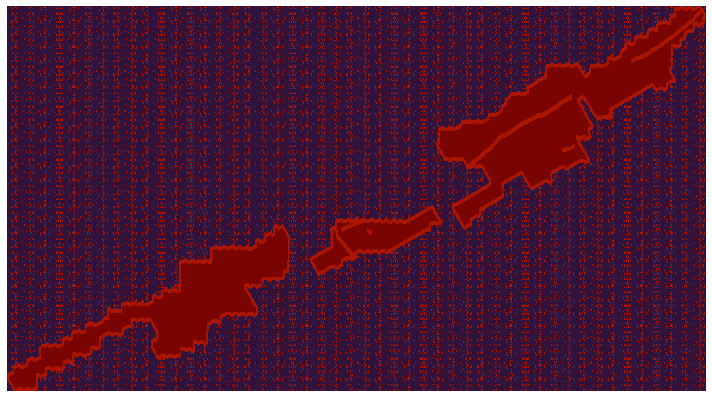

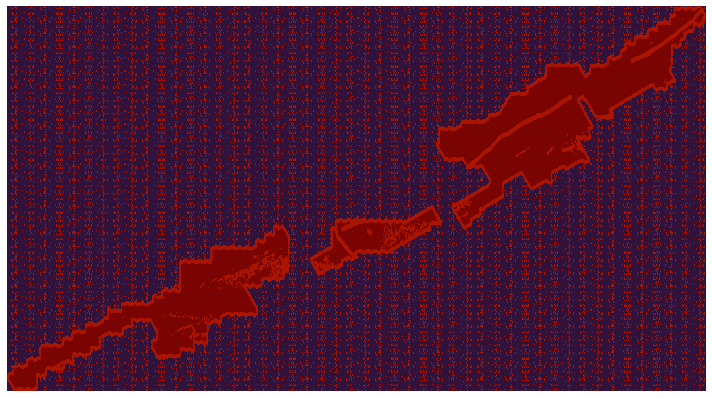

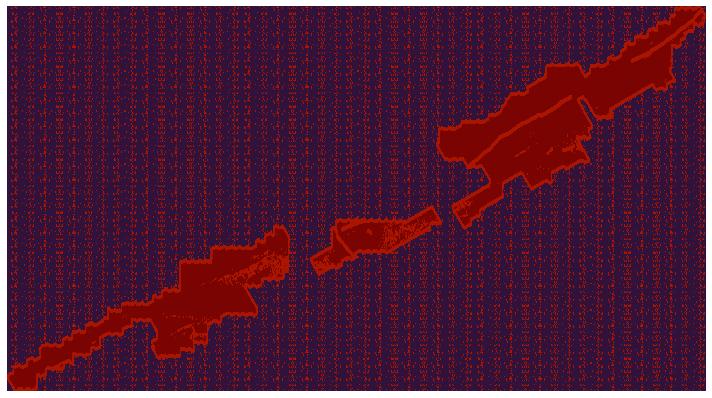

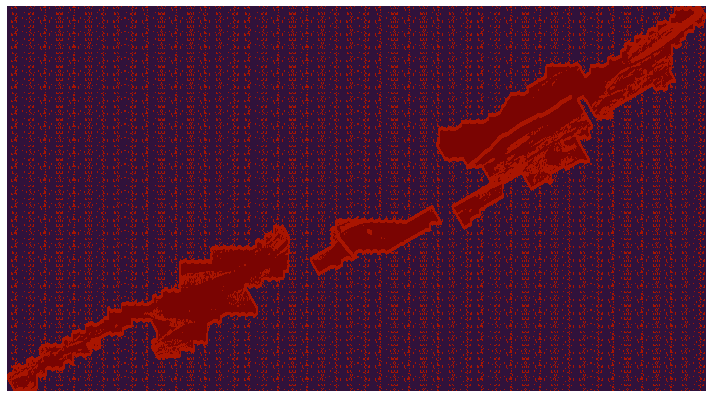

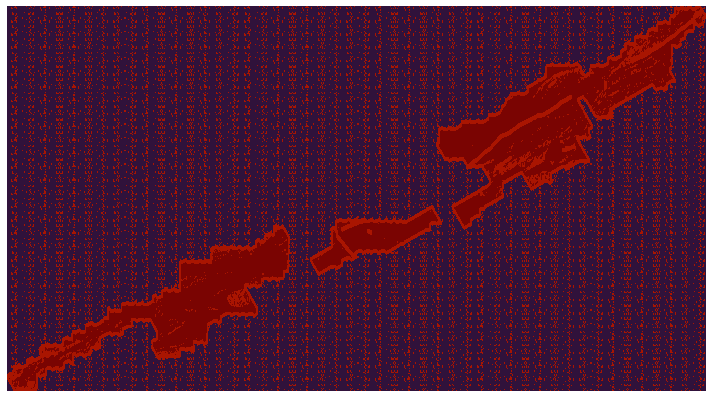

In [27]:
tifs = glob.glob(SVM_predictions_folder + '*.tif')        
        
for t in tifs:
    filename,  extension, directory= utilities.Path_Info(t)
    geotiff_to_jpg(t, os.path.join(SVM_predictions_folder, filename + '.jpg')) 

In [64]:
actual_classes

[0, 1]

In [65]:
predictions

,x,y,predictions,0_probability,1_probability,maxProb,entropy
40804394,492807.5,5753132.5,1,0.471399,0.528601,0.528601,0.997638
40804395,492812.5,5753132.5,1,0.477457,0.522543,0.522543,0.998533
40804396,492817.5,5753132.5,0,0.503276,0.496724,0.503276,0.999969
40804397,492822.5,5753132.5,1,0.452458,0.547542,0.547542,0.993469
40804398,492827.5,5753132.5,1,0.452458,0.547542,0.547542,0.993469
...,...,...,...,...,...,...,...
306634297,406122.5,5703232.5,1,0.419482,0.580518,0.580518,0.981212
306634298,406127.5,5703232.5,1,0.401723,0.598277,0.598277,0.971950
306634299,406132.5,5703232.5,1,0.379252,0.620748,0.620748,0.957512
306634300,406137.5,5703232.5,1,0.379252,0.620748,0.620748,0.957512


In [66]:
#from dask.dataframe import from_pandas

In [31]:
#ddf = from_pandas(predictions, npartitions=100)

In [32]:
#ddf.to_csv(os.path.join(output_folder, 'predictions-*.csv'))

In [33]:
#ddf_cube = from_pandas(cube.df, npartitions=100)

In [34]:
#ddf_cube.to_csv(os.path.join(output_folder, 'cube-*.csv'))

In [28]:
def plot_shap_values(model, X_test, **kwargs):
    """
    Create a plot of shap values for a given pre-fitted estimator. SHAP VALUES DO NOT SUPPORT STACKING CLASSIFIERS
    Parameters
    ----------
    model : imblearn.pipeline.Pipeline model or sklearn classifier
    X_test : pandas.DataFrame
        The test portion of a dataset
    set_size : OPTIONAL, tuple
        Set the figure size in inches -> Example: (15, 11)
    output_directory : OPTIONAL, str
        The path of the plot
    """
    # REFERENCES :
    # https://github.com/slundberg/shap/issues/406
    # PROBLEM #1 : plot shap_values was plotting categorical variables in gray (see ref above)
    # FIXED #1 : PROBLEM #1 has been resolved. 'features' object of shap.summary_plot must be a numpy array, not a dataframe.

    # PROBLEM #2 : Plot shap values of OneHotEncoded columns in terms of original categorical property (Next Update)
        
    if type(model) == imblearn.pipeline.Pipeline:
        # If the user is using a pipeline model, 
        # the shap values are calculated in this if block!

        pre_model = model['pre'] # Pre step of the pipeline
        classifier = model['clf'] # Classifier of the pipeline
        ct = model.named_steps['pre'] # Define the column transform for the given pipeline model          
        
        if type(classifier) == catboost.core.CatBoostClassifier:
            explainer = fasttreeshap.TreeExplainer(classifier, feature_names=X_test.columns.tolist())
            (n, d) = X_test.shape
       
        elif type(classifier) != catboost.core.CatBoostClassifier:
            # When the user uses a non-CatBoost model (Random Forest, LGBM, XGBoost) with some categorical variables, 
            # the "pre" step of the pipeline applies OneHotEncoder for categorical variables. 
            # In other words, the dimension of X_train and X_test change at the "pre" stage of the pipeline. 
            # For this reason, the columns of X_test are not recognized by the bestpipeline_fitted_model, 
            # but the columns of the column-transformed version are. 
            # Therefore, we need to apply a column transform first and then check the shap values of individual OneHotEncoder columns.
            
            # In the next update, the shap values of the OneHotEncoder columns will be collected and written 
            # in terms of the original categorical feature.
                        
            X_test_transform = pd.DataFrame(ct.transform(X_test), columns= pre_model.get_feature_names_out().tolist())    
            explainer = fasttreeshap.TreeExplainer(classifier, feature_names=X_test_transform.columns.tolist())
            (n, d) = X_test_transform.shape    
    
    else:
        explainer = fasttreeshap.TreeExplainer(model, feature_names=X_test.columns.tolist())
        (n, d) = X_test.shape    

    # Plotting part starts here!
    # The plotting part can be written in a cleaner way.
    # However, shap.summary_plot calls 'plt.show()' to ensure the plot displays, which makes it
    # a bit difficult to save two consecutive summary plots.
    # Therefore, we have to set 'show=False' for the first shap.summary_plot.
    # If an output_directory is set, only the second plot will be displayed, but both plots will be saved separately.
    # If an output_directory is NOT set, then both plots will be displayed. However, none of them will be saved.
    
    if "output_directory" in kwargs:
        show=False
        if not os.path.exists(kwargs['output_directory']):
            os.makedirs(kwargs['output_directory'])
    else:
        show=True    
    
    # Let's compute shap values and plot the first summary_plot
    if type(model) == imblearn.pipeline.Pipeline:
        if type(classifier) == catboost.core.CatBoostClassifier:
            shap_vals = explainer.shap_values(X_test)
            fasttreeshap.summary_plot(shap_vals, features=np.array(X_test), feature_names=X_test.columns, max_display = d, show=show)
        elif type(classifier) != catboost.core.CatBoostClassifier:
            shap_vals = explainer.shap_values(X_test_transform)
            fasttreeshap.summary_plot(shap_vals, features=np.array(X_test_transform), feature_names=X_test_transform.columns, max_display = d, show=show)
    else:
        shap_vals = explainer.shap_values(X_test)
        fasttreeshap.summary_plot(shap_vals, features=np.array(X_test), feature_names=X_test.columns, max_display = d, show=show)
    
    # "set_size" is OPTIONAL to change the size of the figures
    if "set_size" in kwargs:
        fig1 = plt.gcf()
        fig1.set_size_inches(kwargs['set_size'][0], kwargs['set_size'][1])
        fig1.tight_layout()
    else:
        fig1 = plt.gcf()
        fig1.set_size_inches(12, 12)
        fig1.tight_layout()

    if "output_directory" in kwargs:
        fig1.savefig(os.path.join(kwargs['output_directory'], 'shap_summary.png'))
        fig1.clf()

    # Let's plot the second summary_plot with a plot_type="bar"   
    if type(model) == imblearn.pipeline.Pipeline:
        if type(classifier) == catboost.core.CatBoostClassifier:
            fasttreeshap.summary_plot(shap_vals, features=np.array(X_test), feature_names=X_test.columns, plot_type="bar", max_display = d, show=show)
        elif type(classifier) != catboost.core.CatBoostClassifier:
            fasttreeshap.summary_plot(shap_vals, features=np.array(X_test_transform), feature_names=X_test_transform.columns, plot_type="bar", max_display = d, show=show)
    else:
        fasttreeshap.summary_plot(shap_vals, features=np.array(X_test), feature_names=X_test.columns, plot_type="bar", max_display = d, show=show)
    
    # "set_size" is OPTIONAL to change the size of the figures
    if "set_size" in kwargs:
        fig2 = plt.gcf()
        fig2.set_size_inches(kwargs['set_size'][0], kwargs['set_size'][1])
        fig2.tight_layout()
    else:
        fig2 = plt.gcf()
        fig2.set_size_inches(12, 12)
        fig2.tight_layout()    
    
    if "output_directory" in kwargs:
        fig2.savefig(os.path.join(kwargs['output_directory'], 'shap_summary_barplot.png'))
        
    return 

In [29]:
plot_shap_values(RandomForest_bestpipeline_fitted_model,
    X_test,
    output_directory=RF_predictions_folder, 
    title= 'RF_Feature_Importances.png')

NameError: name 'RandomForest_bestpipeline_fitted_model' is not defined

,col_name,feature_importance_vals
0,Critical_Magres_Prelim_Mosaic,1.033176
9,Critical_1yd,0.848968
13,All_geology_with_pegmatites_geo_code_l,0.720234
3,Critical_DTM_slope,0.702890
7,Critical_1xd,0.668282
8,Critical_tilt,0.453480
6,Critical_rtp_residual_100,0.440713
4,Critical_hgm_1vd_difference,0.298338
12,Critical_residual_pseudo_gravity,0.254046
10,Critical_hge,0.235007


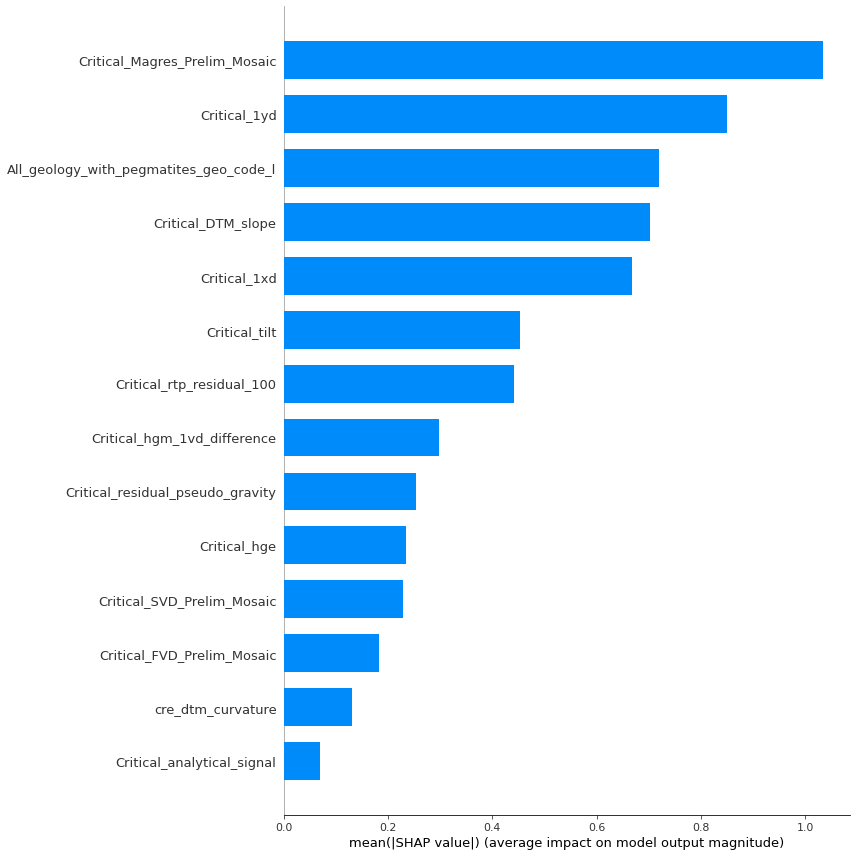

In [67]:
plot_shap_values(CatBoost_bestpipeline_fitted_model,
                 X_test,
                 output_directory=CatBoost_predictions_folder, 
                 title= 'CatBoost_SHAP_values.png')

In [68]:
metrics

{'SVM': {'f1': 0.8647584973166369,
  'Precision': 0.8657525510204082,
  'Recall': 0.8638382236320381,
  'Accuracy': 0.8703703703703703},
 'CatBoost': {'f1': 0.967624605299972,
  'Precision': 0.9719354838709677,
  'Recall': 0.9640761300555115,
  'Accuracy': 0.9691358024691358},
 'LGBM': {'f1': 0.8606070087609512,
  'Precision': 0.8574524067481815,
  'Recall': 0.8662965900079302,
  'Accuracy': 0.8641975308641975},
 'Random Forest': {'f1': 0.8660788095894186,
  'Precision': 0.863892365456821,
  'Recall': 0.868913560666138,
  'Accuracy': 0.8703703703703703}}

In [69]:
def compare_models(metrics, **kwargs):
    """
    Compare models and create a plot of metrics provided in the nested dictionary
    
    Parameters
    ----------
    metrics : dict
        Dictionary with all models and related metrics
    set_size : OPTIONAL, tuple
        Set the figure size in inches -> Example: (15, 11)
    output_directory : OPTIONAL, str
        The path of the plot
    
    Example:
    
    metrics = {}
    metrics["CatBoost"] = {"f1": 0.78, "prec": 0.79, "acc":0.77}
    metrics["Random Forest"] = {"f1": 0.68, "prec": 0.69, "acc":0.67}
   
    compare_models(metrics, output_directory="./")
    
    """
    
    metrics_df = pd.DataFrame(metrics)
    metrics_df = metrics_df.reindex(metrics_df.mean().sort_values().index, axis=1)
        
    if "set_size" in kwargs:
        ax = metrics_df.transpose().plot.barh(figsize=(kwargs['set_size'][0], kwargs['set_size'][1]), zorder=10)
    else:
        ax = metrics_df.transpose().plot.barh(figsize=(12,8), zorder=10)
    
    ax.set_title('Model Comparison', fontsize=20)
    ax.set_xlabel("Score", size = 20)
    ax.set_yticklabels(metrics_df.transpose().index.values.tolist(), rotation=45, 
                   rotation_mode="anchor", 
                   size = 15)
    ax.set_xlim([0.0, 1.0])
    ax.set_xticks(np.linspace(0, 1, 11, endpoint = True))
    ax.legend()
    ax.grid(zorder=5)
    leg = ax.legend(loc='upper right', fontsize=15, ncol=1, framealpha=.5)
    leg.set_zorder(100)
       
    if "output_directory" in kwargs:
        plt.savefig(os.path.join(kwargs['output_directory'], 'model_comparison.png'), dpi=100)
    
    return metrics_df

,LGBM,SVM,Random Forest,CatBoost
f1,0.860607,0.864758,0.866079,0.967625
Precision,0.857452,0.865753,0.863892,0.971935
Recall,0.866297,0.863838,0.868914,0.964076
Accuracy,0.864198,0.870370,0.870370,0.969136


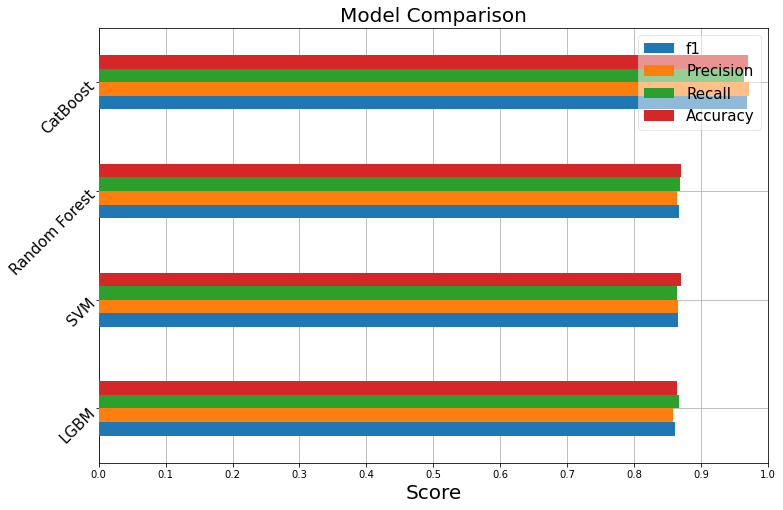

In [70]:
compare_models(metrics, output_directory=os.path.join(reporting_folder))

In [71]:
predictions[predictions['predictions'] == 0]

,x,y,predictions,0_probability,1_probability,maxProb,entropy
0,492807.5,5753132.5,0,0.872426,0.127574,0.872426,0.550748
1,492812.5,5753132.5,0,0.870137,0.129863,0.870137,0.557062
2,492817.5,5753132.5,0,0.883867,0.116133,0.883867,0.518141
3,492822.5,5753132.5,0,0.856979,0.143021,0.856979,0.592095
4,492827.5,5753132.5,0,0.856979,0.143021,0.856979,0.592095
...,...,...,...,...,...,...,...
215785,406107.5,5703232.5,0,0.624142,0.375858,0.624142,0.955064
215786,406112.5,5703232.5,0,0.624142,0.375858,0.624142,0.955064
215787,406117.5,5703232.5,0,0.632151,0.367849,0.632151,0.949006
215788,406122.5,5703232.5,0,0.546911,0.453089,0.546911,0.993641


In [72]:
predictions[predictions['predictions'] == 1]

,x,y,predictions,0_probability,1_probability,maxProb,entropy
728,492632.5,5753017.5,1,0.497712,0.502288,0.502288,0.999985
731,492647.5,5753017.5,1,0.481121,0.518879,0.518879,0.998971
732,492652.5,5753017.5,1,0.486270,0.513730,0.513730,0.999456
733,492657.5,5753017.5,1,0.414760,0.585240,0.585240,0.978932
734,492662.5,5753017.5,1,0.415904,0.584096,0.584096,0.979497
...,...,...,...,...,...,...,...
215780,404097.5,5703232.5,1,0.483410,0.516590,0.516590,0.999206
215781,404102.5,5703232.5,1,0.485698,0.514302,0.514302,0.999410
215790,406132.5,5703232.5,1,0.454233,0.545767,0.545767,0.993948
215791,406137.5,5703232.5,1,0.456522,0.543478,0.543478,0.994539


In [80]:
y_train

89496520     1
219161322    0
57426217     0
141465076    1
281781652    1
            ..
279784017    0
272381772    0
279784018    0
275098571    0
59689776     0
Name: CRE_all_Li_ne_and_pos_raster, Length: 646, dtype: int32

In [81]:
#y_train_df = cube.subset(['coordinates'])
#y_test_df = cube.subset(['coordinates'])

In [82]:
#y_train_df['y_train'] = y_train
#y_test_df['y_test'] = y_test

In [35]:
#predictions_columns = ['y_train']
#categories = ['y_train']

#for predictions_column in predictions_columns:
#    csv_to_raster_geocube(y_train_df, 
#        os.path.join(output_folder, predictions_column + '.tif'), 
#        crs,
#        'x', 
#        'y', 
#        predictions_column, 
#        xRes=pixel_size, 
#        yRes=pixel_size)

In [36]:
#predictions_columns = ['y_test']
#categories = ['y_test']

#for predictions_column in predictions_columns:
#    csv_to_raster_geocube(y_test_df, 
#        os.path.join(output_folder, predictions_column + '.tif'), 
#        crs,
#        'x', 
#        'y', 
#        predictions_column, 
#        xRes=pixel_size, 
#        yRes=pixel_size)

In [37]:
#input_raster = os.path.join(output_folder, 'y_train.tif')
#dst_shapefile = os.path.join(output_folder, 'y_train_shp')

#utilities.raster_to_shapefile(input_raster, dst_shapefile, output_type='int')

In [38]:
#input_raster = os.path.join(output_folder, 'y_test.tif')
#dst_shapefile = os.path.join(output_folder, 'y_test_shp')

#utilities.raster_to_shapefile(input_raster, dst_shapefile, output_type='int')

In [73]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pandas as pd
import os
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.utils import get_column_letter
from openpyxl.styles import Alignment
from openpyxl.drawing.image import Image
from openpyxl.worksheet.datavalidation import DataValidation

from openpyxl.formatting.rule import ColorScaleRule
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from GeoDS import utilities


def correlation_matrix_plot(df, output_path, corr_threshold=None, method='spearman', **kwargs):
    """
    Plot a Spearman correlation matrix to assess linear correlation between each columns in a DataFrame
    Parameters
    ----------
    df : pandas.DataFrame
        input data
    output_path : str
        Path where to save a excel containing the correlation coefficient
    corr_threshold : float
        Threshold to use. It keeps and plots only variables with correlation above given threshold.
    method :{'pearson', 'kendall', 'spearman'} or callable
        Method of correlation, as per pandas.DataFrame.corr
    **kwargs : optional seaborn.heatmap keyword arguments    
     
    Examples
    ----------
    correlation_matrix_plot(df_ica, output_folder, method='spearman')
    correlation_matrix_plot(df_ica, output_folder, corr_threshold=0.60, method='spearman') 
    correlation_matrix_plot(df_ica, output_folder, corr_threshold=0.60, method='spearman', annot=True) 
    
    Returns
    -------
    None
    """
    method_title = str(method).capitalize()
    cmap = mpl.cm.Reds    

    fig, ax = plt.subplots(figsize=(100, 80))
    
    if corr_threshold == None:
        corr = df.corr(method=method).abs()
        mask = np.triu(np.ones_like(corr))     
    else:
        corr = df.corr(method=method).abs()
        corr = corr[(corr >= corr_threshold) & (corr !=1.000)]
        mask = np.triu(np.ones_like(corr, dtype=bool))
    
    ax = sns.heatmap(corr,
                ax = ax,
                cmap=cmap, vmin=0.0, vmax=1.0, linewidths=10, linecolor='w',
                annot_kws={'size': 50, 'weight': 'bold'}, fmt='.2f', 
                square=True, mask=mask,
                cbar=True,
                cbar_kws={
                    'pad': .01, 
                    'ticks': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                    'shrink': .82,
                    'extend': 'both'
                         },  
                **kwargs)
    
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=120)
    
    # Add Tick Labels
    labels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    cax.set_yticklabels(labels, fontsize=80, weight='bold')
    cax.set_ylabel(f'\n\n{method_title} Correlation', fontsize=80, weight='bold')
    
    # Setup Ticks and Labels
    plt.title(f"Features Heat Map with {method_title} Correlation\n", pad=30, fontsize=120, fontweight='bold')
    plt.xlabel('\n\nFeatures', labelpad=30, fontsize=120, fontweight='bold')  # x-axis label with fontsize 15
    plt.ylabel('Features\n\n', labelpad=30, fontsize=120, fontweight='bold')  # y-axis label with fontsize 15
    plt.xticks(fontsize=60, fontweight='bold', rotation=90)
    plt.yticks(fontsize=60, fontweight='bold', rotation=0)
    plt.tight_layout()
    fig.savefig(os.path.join(output_path, f'{method_title}_Correlations.png'), dpi=100)    
    plt.show()
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    pd.DataFrame(corr).to_excel(os.path.join(output_path, "correlation_matrix.xlsx"))

    return fig, ax

In [ ]:
correlation_matrix_plot(cube.df[columns['numerical']], 
                        reporting_folder, 
                        corr_threshold=None, 
                        method='spearman', 
                        annot=True) 

In [ ]:
correlation_matrix_plot(cube.df[columns['numerical']], 
                        reporting_folder, 
                        corr_threshold=None, 
                        method='pearson', 
                        annot=True) 